<a href="https://colab.research.google.com/github/pradeep-isawasan/criminogenic-biblio/blob/main/notebooks/03_topic_modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Topic Modeling - v7

**WOS Data Collected:** 27 October 2025
**Search syntax:** "criminogenic*"


# Section 0: Setup

This section prepares the environment for the notebook.

We will:
1. Install required libraries (Google Colab)
2. Import Python packages
3. Load the OpenAI API key from Colab `userdata`

> **Run Section 0 top-to-bottom before running anything else.**


In [ ]:
# Install all required libraries (Colab only)
!pip install \
    bertopic \
    transformers \
    umap-learn \
    hdbscan \
    ripser \
    kmapper \
    openai \
    gensim==4.3.3 > /dev/null

print("✔️ Libraries installed")

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
jax 0.7.2 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
jaxlib 0.7.2 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
tsfresh 0.21.1 requires scipy>=1.14.0; python_version >= "3.10", but you have scipy 1.13.1 which is incompatible.
pytensor 2.35.1 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
shap 0.50.0 requires numpy>=2, but you have numpy 1.26.4 which is incompatible.
opencv-contrib-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompa

## 0.2) Imports

In [ ]:

import os
import re
import json
import numpy as np
import pandas as pd

import torch
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModel

from bertopic import BERTopic

import umap
import hdbscan

import matplotlib.pyplot as plt
import seaborn as sns

from openai import OpenAI


/usr/local/lib/python3.12/dist-packages/hdbscan/robust_single_linkage_.py:175: SyntaxWarning: invalid escape sequence '\{'
  $max \{ core_k(a), core_k(b), 1/\alpha d(a,b) \}$.


## 0.3) Load OpenAI API key from Colab userdata

In [ ]:

from google.colab import userdata

OPENAI_KEY = userdata.get("OPENAI_API_KEY")

if OPENAI_KEY is None:
    raise ValueError("Please add your OpenAI API key in Colab: Runtime → Secrets → User Data")

os.environ["OPENAI_API_KEY"] = OPENAI_KEY

client = OpenAI()

print("✔️ OpenAI key loaded")


✔️ OpenAI key loaded


# Section 1: Data Preparation

In [ ]:
# Mount Google Drive (run once per session)

from google.colab import drive
drive.mount('/content/drive')

print("✔️ Google Drive mounted.")


Mounted at /content/drive
✔️ Google Drive mounted.


## 1.1) Load dataset from project folder

In [ ]:

# 👇 This is the ONE folder where everything lives
PROJECT_DIR = "/content/drive/MyDrive/Colab Notebooks/biblio-criminogenic"

CSV_PATH = f"{PROJECT_DIR}/bibfile_data.csv"

# Load
df = pd.read_csv(CSV_PATH, low_memory=False)
df = df.rename(columns={"Unnamed: 0": "id"})

# Expected columns check
expected = ['unique_id', 'abstract', 'author_keywords', 'keywords', 'title']
missing = [c for c in expected if c not in df.columns]
if missing:
    print("⚠️ Warning: Missing expected columns:", missing)
else:
    print("✅ Columns OK:", expected)

print(f"📄 Loaded {len(df)} rows from {CSV_PATH!r}.")


✅ Columns OK: ['unique_id', 'abstract', 'author_keywords', 'keywords', 'title']
📄 Loaded 1359 rows from '/content/drive/MyDrive/Colab Notebooks/biblio-criminogenic/bibfile_data.csv'.


## 1.2) Remove duplicates based on unique_id

In [ ]:

before = len(df)

# Identify rows with duplicate unique_id values
dup_mask = df.duplicated(subset=['unique_id'], keep=False)
duplicates = df[dup_mask]

if not duplicates.empty:
    print(f"⚠️ Found {duplicates['unique_id'].nunique()} duplicated unique_id values.")

    # Drop duplicates, keep the first occurrence
    df = df.drop_duplicates(subset=['unique_id'], keep='first').reset_index(drop=True)

    after = len(df)
    print(f"🧹 Removed {before - after} duplicate rows. Remaining rows: {after}.")
else:
    print("✅ No duplicate unique_id entries found.")


✅ No duplicate unique_id entries found.


## 1.3) Build SPECTER2-Style Text (`__text__`)

In this step, we prepare a **single unified text field** that will be sent to the SPECTER2 / transformer embedding model.

We combine four bibliographic fields:

- **title**
- **abstract**
- **author_keywords**
- **keywords**

into one structured string using the SPECTER2-style format:

title [SEP] abstract [SEP] author_keywords [SEP] keywords

### What happens in this step:

1. **Clean missing values**
   - Convert `"unknown"`, `"nan"`, empty strings, and `None` into `NaN`.

2. **Normalize keyword fields**
   - Split on `,`, `;`, and `|`
   - Trim each keyword
   - Rejoin using a standard format: `kw1; kw2; kw3`

3. **Normalize title and abstract**
   - Collapse multiple spaces
   - Keep original casing and punctuation  
     *(full cleaning happens later in Step 1.4)*

4. **Assemble the final text**
   - Include only non-empty fields
   - Join all parts with ` [SEP] `
   - Save into:  
     ```
     df["__text__"]
     ```

### Why this matters

Using structured `[SEP]` segments helps SPECTER2 understand the logical parts of a scientific article, leading to **better-quality embeddings** and **more coherent topic modeling** later in the workflow.


In [ ]:
# ---------------------------------------------------------------
# Text Preparation (SPECTER2-ready, no double-cleaning)
# - Builds: title [SEP] abstract [SEP] author_keywords [SEP] keywords
# - Preserves semicolons in keywords (normalized to "; ")
# - Leaves case, URLs, punctuation cleanup to basic_clean()
# ---------------------------------------------------------------
import re
import pandas as pd
import numpy as np

TEXT_COLS = ["abstract", "author_keywords", "keywords", "title"]

def _to_nan(x):
    """Convert 'unknown'/'nan'/''/None -> np.nan; otherwise trimmed string."""
    if x is None or (isinstance(x, float) and np.isnan(x)):
        return np.nan
    s = str(x).strip()
    if s == "" or s.lower() in {"nan", "none", "unknown"}:
        return np.nan
    return s

# Apply _to_nan to all text columns (if they exist)
for c in TEXT_COLS:
    if c in df.columns:
        df[c] = df[c].apply(_to_nan)

def _normalize_keywords(s: str) -> str:
    """Normalize separators in keyword fields, keep '; ' as main separator."""
    s = s.strip()
    # Turn commas, pipes, slashes into semicolons
    s = re.sub(r"\s*[,|/]\s*", "; ", s)
    # Normalize multiple semicolons / spacing
    s = re.sub(r"\s*;\s*", "; ", s)
    return s

def _build_text(row: pd.Series) -> str:
    """Build SPECTER2 text: title [SEP] abstract [SEP] author_keywords [SEP] keywords."""
    parts = []

    # Title
    v = row.get("title")
    if pd.notnull(v):
        parts.append(str(v).strip())

    # Abstract
    v = row.get("abstract")
    if pd.notnull(v):
        parts.append(str(v).strip())

    # Author keywords
    v = row.get("author_keywords")
    if pd.notnull(v):
        parts.append(_normalize_keywords(str(v)))

    # Keywords
    v = row.get("keywords")
    if pd.notnull(v):
        parts.append(_normalize_keywords(str(v)))

    return " [SEP] ".join([p for p in parts if p])

df["__text__"] = df.apply(_build_text, axis=1)

print("✅ Text prep done for SPECTER2-base.")
print("   Order: title [SEP] abstract [SEP] author_keywords [SEP] keywords")



✅ Text prep done for SPECTER2-base.
   Order: title [SEP] abstract [SEP] author_keywords [SEP] keywords


In [ ]:
df[["title", "abstract", "author_keywords", "keywords", "__text__"]].head(2)

,title,abstract,author_keywords,keywords,__text__
0,Social media nicotine markets: Criminogenic af...,Illicit drug markets continuously evolve in re...,Affordance; Illicit markets; Nicotine vape; So...,NaN,Social media nicotine markets: Criminogenic af...
1,Exploring the factors that differentiate indiv...,Not much is known about the characteristics of...,Co-offending; Cybercrime; Cyber-dependent crim...,CRIMINAL ATTITUDES; CYBERCRIMINAL NETWORKS; EM...,Exploring the factors that differentiate indiv...


## 1.4) Basic Text Cleaning → `__clean__`

In this step, we apply a **light cleaning** to the structured text stored in `__text__`, and save the result into:

`df["__clean__"]`

This cleaned text is used for:

- text quality checks (short/long documents)
- preparing input for embeddings (`__embed_text__`)
- providing a stable base before phrase/keyword normalization

We intentionally avoid heavy cleaning because transformer embeddings (e.g., SPECTER2) work best when the text still looks like natural language. The goal is to remove noise while **preserving meaning and structure**, especially the `[SEP]` separators.

---

### 🔍 What `basic_clean()` does

The cleaning function performs the following steps:

1. **Normalize special tokens and punctuation**
   - Convert variants like `[ sep ]`, `[SEP]`, `[Sep]` into a consistent `[SEP]`
   - Convert curly quotes (`’`, `‘`) into `'`
   - Convert en/em dashes (`–`, `—`) into `-`

2. **Protect `[SEP]` before lowercasing**
   - Temporarily replace `[SEP]` with a placeholder (e.g. `__sep__`)
   - Lowercase the entire text
   - This avoids breaking the `[SEP]` token during cleaning

3. **Remove URLs**
   - Strip out patterns like `http://...` or `www...` to reduce noise

4. **Remove unusual characters but keep useful ones**
   - Allow:
     - letters (`a–z`)
     - digits (`0–9`)
     - underscores (`_`)
     - punctuation (`; : . , ! ? ' -`)
     - square brackets (for `[SEP]`)
   - Replace everything else with a space

5. **Normalize semicolon spacing**
   - Ensure keyword-style text follows a consistent format, e.g.:  
     `kw1; kw2; kw3`

6. **Normalize whitespace**
   - Collapse multiple spaces into one
   - Trim leading and trailing spaces

7. **Remove standalone single-letter words that add noise**
   - Remove `b–h` and `j–z`
   - Keep valid English single-letter words:
     - `a`
     - `i`

8. **Restore `[SEP]`**
   - Convert the placeholder back to `[SEP]`



In [ ]:
# ---------------------------------------------------------------
# 1.4 Basic Text Cleaning + Light Normalization
# - keeps [SEP], semicolons, apostrophes
# - removes noise characters
# - removes single-letter words except 'a' and 'i'
# ---------------------------------------------------------------
import re

def basic_clean(s: str) -> str:
    if s is None:
        return ""
    s = str(s)

    # 0) Normalize [SEP] variants and unicode punctuation
    s = re.sub(r"\[\s*sep\s*\]", "[SEP]", s, flags=re.IGNORECASE)  # any [ sep ] → [SEP]
    s = s.replace("\u2019", "'").replace("\u2018", "'")             # curly quotes → '
    s = s.replace("\u2013", "-").replace("\u2014", "-")             # en/em dashes → -

    # 1) Protect [SEP] before lowercasing
    s = s.replace("[SEP]", " __sep__ ")

    # 2) Lowercase
    s = s.lower()

    # 3) Remove URLs (just in case)
    s = re.sub(r"http\S+|www\.\S+", " ", s)

    # 4) Keep only letters, digits, spaces and basic punctuation
    #    allowed: a-z, 0-9, space, _ ; : . , ! ? ' -
    s = re.sub(r"[^a-z0-9_ ;:.,!?'\-\s]", " ", s)

    # 5) Normalize semicolon spacing (for keywords)
    s = re.sub(r"\s*;\s*", "; ", s)

    # 6) Collapse multiple spaces
    s = re.sub(r"\s+", " ", s).strip()

    # 7) Remove standalone single-letter words EXCEPT 'a' and 'i'
    s = re.sub(r"\b[b-hj-z]\b", " ", s)  # remove b–h and j–z
    s = re.sub(r"\s+", " ", s).strip()

    # 8) Restore [SEP]
    s = s.replace("__sep__", "[SEP]")

    return s

# Apply to build text for topic modelling / QC
df["__clean__"] = df["__text__"].astype(str).apply(basic_clean)

print("✅ Basic text cleaning complete (keeps [SEP], ';', apostrophes, and preserves 'a' and 'i').")


✅ Basic text cleaning complete (keeps [SEP], ';', apostrophes, and preserves 'a' and 'i').


In [ ]:
df[["__text__", "__clean__"]].head(2)

,__text__,__clean__
0,Social media nicotine markets: Criminogenic af...,social media nicotine markets: criminogenic af...
1,Exploring the factors that differentiate indiv...,exploring the factors that differentiate indiv...


## 1.5) Token Length Analysis

To check the quality of our cleaned text, we compute the number of tokens (words) in each document using:

`df["__clean__"]`

This helps us identify:

- **Very short documents** (e.g., < 15 tokens)  
  These may not contain enough information for reliable embeddings or topic modelling.

- **Very long documents** (e.g., > 400 tokens)  
  These could indicate:
  - merged abstracts
  - references accidentally included
  - PDF extraction errors
  - unusually verbose descriptions

Analyzing token length distribution helps ensure our dataset is suitable for SPECTER2 embeddings and BERTopic.

---

### What we do in this step:

1. Compute token length for each document.
2. Save the result in a new column:
3. Print descriptive statistics:
- mean  
- min/max  
- quartiles  
4. Plot a histogram to visually inspect:
- outliers
- skewness
- typical document sizes

This step does **not** modify any text.  
It simply provides quality insight so we can clean or filter problematic records later.

📊 Token length summary:
count    1359.000000
mean      189.675497
std        73.789414
min         3.000000
25%       147.500000
50%       184.000000
75%       224.500000
max      1081.000000
Name: len_tokens, dtype: float64


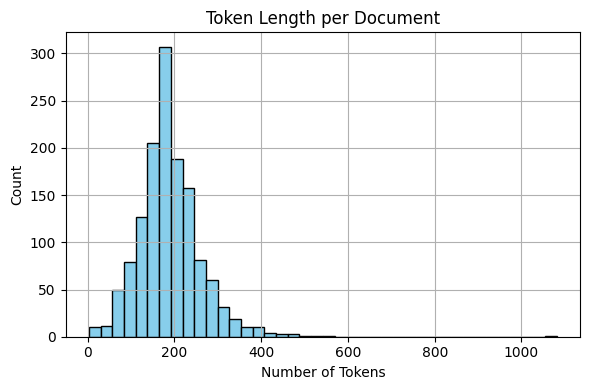

In [ ]:
# ---------------------------------------------------------------
# 1.5 Token Length Analysis
# ---------------------------------------------------------------

# Count tokens in __clean__
df["len_tokens"] = df["__clean__"].str.split().apply(len)

print("📊 Token length summary:")
print(df["len_tokens"].describe())

# Histogram
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
df["len_tokens"].hist(bins=40, color="skyblue", edgecolor="black")
plt.title("Token Length per Document")
plt.xlabel("Number of Tokens")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


## 1.6) Text Quality Summary (Short vs Long Documents)

After computing the token length in `len_tokens` (from `__clean__`), we now check how many documents are:

- **Very short** → fewer than **15 tokens**
- **Very long** → more than **400 tokens**

These are useful heuristics:

- **Very short documents (< 15 tokens)**  
  - Often titles only  
  - Incomplete abstracts  
  - Records with almost no useful context  
  - May become noise in embeddings and topic modelling

- **Very long documents (> 400 tokens)**  
  - Possible merged abstracts or full-text chunks  
  - References or extra sections accidentally included  
  - Can dominate similarity space and distort topics

In this step, we:

1. Count how many documents fall below 15 tokens and above 400 tokens.
2. Print a summary of these counts.
3. Optionally display **a few example records** (ID, unique_id, and `__clean__`) for:
   - very short documents  
   - very long documents  

This step does **not** modify the dataset yet.  
It simply helps us decide later whether we should remove or manually inspect these outliers.


In [ ]:
# ---------------------------------------------------------------
# 1.6 Text Quality Summary (based on __clean__)
# ---------------------------------------------------------------

# Identify short and long docs
df_short = df[df["len_tokens"] < 15][["id", "unique_id", "__clean__", "len_tokens"]]
df_long  = df[df["len_tokens"] > 400][["id", "unique_id", "__clean__", "len_tokens"]]

print(f"⚠️ Very short docs (<15 tokens): {len(df_short)}")
print(f"⚠️ Very long docs (>400 tokens): {len(df_long)}")

# Better display settings for Google Colab
pd.set_option('display.max_colwidth', None)    # show full text
pd.set_option('display.max_rows', 200)         # see more docs at once

# Show short docs (scrollable)
if len(df_short) > 0:
    print("\n🔍 **Short Documents (<15 tokens)**")
    display(df_short)

# Show long docs (scrollable)
if len(df_long) > 0:
    print("\n🔍 **Long Documents (>400 tokens)**")
    display(df_long)


⚠️ Very short docs (<15 tokens): 7
⚠️ Very long docs (>400 tokens): 16

🔍 **Short Documents (<15 tokens)**


,id,unique_id,__clean__,len_tokens
1308,1308,WOS:000184095000002,the relationship between human needs and criminogenic needs,8
1349,1349,WOS:A1991GM24400005,homelessness - a criminogenic situation,5
1350,1350,WOS:A1988T483300002,are there any successful men from criminogenic backgrounds,8
1355,1355,WOS:A1977ED65300006,notes on criminogenic hypothesis - case-study of american liquor industry,10
1356,1356,WOS:A1975BB29500003,criminogenic market structure - automobile-industry,5
1357,1357,WOS:A1974AL61200004,criminogenics of marihuana,3
1358,1358,WOS:A1970Y290800006,automakers and dealers - study of criminogenic market forces,9



🔍 **Long Documents (>400 tokens)**


,id,unique_id,__clean__,len_tokens
177,177,WOS:001222198200012,"problems of criminological determination and causation in the scientific doctrine of professor vitaliy anatolyevich nomokonov [SEP] a famous russian criminologist, doctor of law, professor, corresponding member of the russian academy of natural sciences, vice -president of the russian criminological association, author of over 400 research works and textbooks vitaliy anatolyevich nomokonov has celebrated his 75th birthday. he is a well-known figure in both russian and foreign criminology famous for his works, his conceptual and fundamental scientific views and approaches, unfailing principles and loyalty to universal human values when developing the strategy and tactics of corruption counteraction. being one of the founders of a highly complex problem area in the field of criminology - the theory of crime determination and causation - he also consistently studies the modern aspects of this theory. the professor was also one of the first scientists who researched the mechanisms of counteracting organized crime and corruption. he has been studying the regional aspects of these interconnected forms of crime over a long period of time, as well as promoting the ideas of its prevention at the political and public levels. advocating the proactive development of criminology and its methodological basis along the lines of the transforming society, the professor has been developing new directions in criminology stressing the anticriminal and anticorruption policy. positive criminology is a trend in his works, he argues for the humane -personal approach in the theory of the criminal' personality and proves the importance of understanding the regularities of positive law-abiding behavior and identifying the anti-criminogenic factors underlying it. the number of his students and followers is constantly growing. over 15 researcher, who wrote their dissertation thesis under .a. nomokonov' supervision, have become the founders of the theory of cybercrime, they promote his ideas regarding anticorruption policy, drug abuse, human trafficking, etc., and have the law enforcement experience that they successfully use in their current work. the professor' approaches to understanding organized crime and corruption, as well as the basic and special measures of counteracting these dangerous phenomena, are a safe basis for the corresponding criminological theory, they reflect his forward -thinking and astute attitude. his scientific intuition allows the professor to be ahead of other research in the sphere of counteracting corruption and provide highly professional predictions on the future regularities of criminal behavior, thus contributing to the development and enriching the theory of criminology and its practical significance. [SEP] criminologist; vitaliy anatolyevich nomokonov; causation and determination of crime; anti-criminal policy; anti-corruption policy",412
180,180,WOS:001130127800001,"measuring criminal thinking among convicts imprisoned in punjab prisons of pakistan [SEP] purposethis study aims to differentiate crime-related characteristics such as the number of cases filed against current convictions and criminal history based on the criminal thinking prevailing among convicts. however, because of the low reliability of subscales and poor structural validity of indigenous and translated versions of international instruments, a new instrument criminal attitude measure cam was extracted to measure criminal thinking patterns among convicts incarcerated in central prisons of punjab.design methodology approacha cross-sectional research design was used. data was collected from 1,949 male convicts extracting mutually exclusive data from 649 respondents for efa and 1,300 respondents for confirmatory factor analysis cfa . both data samples were collected from convicts incarcerated in the nine all central jails of punjab, pakistan.findingsthe results of this study showed poor model f

## 1.7) Manual Removal of Low-Quality Documents

Based on the inspection in **1.6 (Text Quality Summary)**, some documents may be:

- too short (e.g. just a title or a fragment)
- extremely long (merged text, PDF extraction errors)
- clearly irrelevant or corrupted (even if length is normal)

Instead of automatically removing all documents below/above a fixed token threshold,  
we use a **manual curation approach**:

1. Inspect:
   - very short docs (`len_tokens < 15`)
   - very long docs (`len_tokens > 400`)
   - any other suspicious records
2. Decide which ones are truly low-quality or unusable.
3. Collect their `id` values into a list.
4. Remove only those specific `id`s from the dataset.

This avoids accidentally deleting valid articles with short or long abstracts.

In this step, we:

- define a manual list of `id`s to remove (`REMOVE_IDS`)
- filter them out from `df`
- report how many documents were removed
- keep the cleaned DataFrame for subsequent steps (embeddings and topic modelling)


In [ ]:
# ---------------------------------------------------------------
# 1.7 Manual Removal of Low-Quality Documents
# ---------------------------------------------------------------

# 🔧 1) Manually list the document IDs to remove
#    → Fill this list after reviewing the outputs from Step 1.6
REMOVE_IDS = [1308, 1349, 1350, 1355, 1356, 1357, 1358]

before = len(df)

if len(REMOVE_IDS) > 0:
    df = df[~df["id"].isin(REMOVE_IDS)].reset_index(drop=True)
    after = len(df)
    print(f"🧹 Removed {before - after} documents using manual ID list.")
    print(f"📄 Remaining documents: {after}")
else:
    print("ℹ️ No IDs specified in REMOVE_IDS. No documents were removed.")

# Optional: quick check of token length distribution after removal
print("\n📊 Updated token length summary (len_tokens):")
print(df["len_tokens"].describe())


🧹 Removed 7 documents using manual ID list.
📄 Remaining documents: 1352

📊 Updated token length summary (len_tokens):
count    1352.000000
mean      190.622041
std        72.794164
min        16.000000
25%       148.000000
50%       184.000000
75%       225.000000
max      1081.000000
Name: len_tokens, dtype: float64


---

## 1.8) Conclusion

In this section, we prepared our bibliographic dataset for downstream
embeddings and topic modelling. We cleaned and structured the text in a
way that supports transformer-based semantic embeddings (SPECTER2) and
BERTopic’s vectorizer.

### What we accomplished

1. **Loaded and validated the dataset**  
   - Fixed missing or malformed fields  
   - Ensured consistent column naming (e.g., `id`, `unique_id`)

2. **Built SPECTER2-style text (`__text__`)**  
   - Combined title, abstract, author keywords, and keywords  
   - Used `[SEP]` tokens to separate logical document sections

3. **Performed light but effective cleaning (`__clean__`)**  
   - Normalized punctuation and spacing  
   - Preserved `[SEP]`  
   - Removed noisy characters  
   - Removed single-letter words except valid ones (`a`, `i`)

4. **Evaluated text quality (`len_tokens`)**  
   - Identified very short and very long documents  
   - Viewed them clearly in Google Colab for manual inspection

5. **Manually removed problematic documents (`REMOVE_IDS`)**  
   - Removed only documents confirmed as corrupted, irrelevant, or unusable  
   - Preserved legitimate short/long documents to avoid losing valuable data

### Outputs produced in Section 1

- `__text__` — structured document with `[SEP]` separators  
- `__clean__` — cleaned version for QC and embedding preparation  
- `len_tokens` — token counts for each document  
- A curated dataset after manual removals

### What’s next?

We now have a **clean, consistent, high-quality dataset**, ready for:

- **`__embed_text__` construction**  
- **SPECTER2 embeddings (Section 2)**  
- BERTopic topic modelling  
- TDA (Mapper + Ripser)  
- Visual analytics

No metadata processing is required at this stage; metadata can be extracted later during topic interpretation.

---



# Section 2: Embeddings (SPECTER2)

In this section, we prepare text for transformer-based embeddings using
the SPECTER2 model. The goal is to generate a dense vector
representation for each document that captures its semantic content.

We separate the concerns as follows:

- `__clean__` → light-cleaned text from Section 1  
- `__embed_text__` → embedding-ready text (concept-normalized, still natural language)  
- later: embeddings → used by BERTopic and TDA


### 2.1a) N-gram nalysis

In [ ]:
# ---------------------------------------------------------------
# 2.1a.1 Noun Phrase Extraction (spaCy) + tqdm Progress Bar
# ---------------------------------------------------------------
import spacy
from tqdm.auto import tqdm
from collections import Counter
import pandas as pd

# Load spaCy English model
# If not installed:
# !python -m spacy download en_core_web_sm

nlp_np = spacy.load("en_core_web_sm")  # full pipeline (noun_chunks needs parser)

texts = df["__clean__"].fillna("").astype(str).tolist()

noun_phrases = []

# tqdm-protected pipeline
for doc in tqdm(nlp_np.pipe(texts, batch_size=32), total=len(texts), desc="Extracting noun phrases"):
    noun_phrases.extend([np.text.lower().strip() for np in doc.noun_chunks])

# Count NP frequencies
np_counts = Counter(noun_phrases)

np_df = (
    pd.DataFrame({"phrase": list(np_counts.keys()), "freq": list(np_counts.values())})
    .sort_values("freq", ascending=False)
    .reset_index(drop=True)
)

print(f"📦 Unique noun phrases: {len(np_df)}")
display(np_df.head(40))


Extracting noun phrases:   0%|          | 0/1352 [00:00<?, ?it/s]

📦 Unique noun phrases: 32999


,phrase,freq
0,crime,812
1,that,811
2,we,800
3,recidivism,657
4,this study,479
5,it,467
6,which,456
7,who,430
8,offenders,423
9,risk,404


In [ ]:
# ---------------------------------------------------------------
# 2.1a.2 PMI-Based Collocations (Bigrams + Trigrams)
# ---------------------------------------------------------------
import nltk

from nltk.collocations import BigramAssocMeasures, BigramCollocationFinder
from nltk.collocations import TrigramAssocMeasures, TrigramCollocationFinder

# Download tokenizer if not already
nltk.download('punkt')
nltk.download('punkt_tab')

# Tokenize corpus
tokens_per_doc = [
    nltk.word_tokenize(text.lower())
    for text in df["__clean__"].fillna("").astype(str).tolist()
]

all_tokens = [t for doc in tokens_per_doc for t in doc]

# Bigram PMI
bigram_measures = BigramAssocMeasures()
bigram_finder = BigramCollocationFinder.from_words(all_tokens)
bigram_finder.apply_freq_filter(3)  # at least 3 occurrences
bigram_scored = bigram_finder.score_ngrams(bigram_measures.pmi)

bigram_df = (
    pd.DataFrame(
        [{"phrase": " ".join(b), "pmi": score} for b, score in bigram_scored]
    )
    .sort_values("pmi", ascending=False)
    .reset_index(drop=True)
)

print(f"📦 Bigram PMI candidates: {len(bigram_df)}")
display(bigram_df.head(40))

# Trigram PMI
trigram_measures = TrigramAssocMeasures()
trigram_finder = TrigramCollocationFinder.from_words(all_tokens)
trigram_finder.apply_freq_filter(3)
trigram_scored = trigram_finder.score_ngrams(trigram_measures.pmi)

trigram_df = (
    pd.DataFrame(
        [{"phrase": " ".join(t), "pmi": score} for t, score in trigram_scored]
    )
    .sort_values("pmi", ascending=False)
    .reset_index(drop=True)
)

print(f"📦 Trigram PMI candidates: {len(trigram_df)}")
display(trigram_df.head(40))


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


📦 Bigram PMI candidates: 18241


,phrase,pmi
0,anaerobic digestion,16.603424
1,me mot,16.603424
2,vitaliy anatolyevich,16.603424
3,minas gerais,16.603424
4,saint lucia,16.603424
5,out-of-school suspensions,16.188386
6,coral gables,16.188386
7,anatolyevich nomokonov,16.188386
8,'industrie financiere,16.188386
9,parking lots,15.866458


📦 Trigram PMI candidates: 11460


,phrase,pmi
0,vitaliy anatolyevich nomokonov,32.791810
1,john wiley sons,30.206847
2,hostile attributional biases,29.299956
3,vagally mediated heart,28.814530
4,cox proportional hazards,28.762062
5,inject drugs pwid,28.399492
6,malicious hoax calls,28.332378
7,outlaw motorcycle gangs,28.054844
8,red light district,27.939367
9,ordinary least squares,27.796828


In [ ]:
# ---------------------------------------------------------------
# 2.1a.3 Keyphrase Extraction with KeyBERT
# ---------------------------------------------------------------
!pip install keybert

from keybert import KeyBERT

kw_model = KeyBERT()  # uses a default sentence-transformer model

# For efficiency, sample or concatenate docs
corpus_text = " ".join(df["__clean__"].fillna("").astype(str).tolist())

keyphrases = kw_model.extract_keywords(
    corpus_text,
    keyphrase_ngram_range=(2, 4),
    stop_words="english",
    top_n=100
)

kb_df = pd.DataFrame(
    [{"phrase": kp, "score": score} for kp, score in keyphrases]
).sort_values("score", ascending=False)

print(f"📦 KeyBERT keyphrases: {len(kb_df)}")
display(kb_df.head(40))


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.4/41.4 kB 3.3 MB/s eta 0:00:00


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

📦 KeyBERT keyphrases: 100


,phrase,score
0,social media nicotine markets,0.7956
1,nicotine markets social media,0.7899
2,online nicotine markets social,0.7584
3,nicotine markets social,0.7283
4,illicit markets nicotine,0.7029
5,danish online nicotine markets,0.7004
6,affordance illicit markets nicotine,0.6939
7,media based nicotine markets,0.6893
8,illicit markets nicotine vape,0.6870
9,illicit nicotine vape markets,0.6843


In [ ]:
display(kb_df.head(70))

,phrase,score
0,social media nicotine markets,0.7956
1,nicotine markets social media,0.7899
2,online nicotine markets social,0.7584
3,nicotine markets social,0.7283
4,illicit markets nicotine,0.7029
5,danish online nicotine markets,0.7004
6,affordance illicit markets nicotine,0.6939
7,media based nicotine markets,0.6893
8,illicit markets nicotine vape,0.6870
9,illicit nicotine vape markets,0.6843


In [ ]:
# ---------------------------------------------------------------
# 2.1a.4 Merge NP + PMI + KeyBERT Candidates (2–3 grams only)
# ---------------------------------------------------------------
def count_words(s):
    return len(s.split())

# Reformat each source table consistently
concept_candidates_np = np_df.rename(columns={"phrase": "term", "freq": "metric"})
concept_candidates_np["source"] = "noun_phrase"
concept_candidates_np["score_type"] = "freq"

concept_candidates_bigram = bigram_df.rename(columns={"phrase": "term", "pmi": "metric"})
concept_candidates_bigram["source"] = "bigram_pmi"
concept_candidates_bigram["score_type"] = "pmi"

concept_candidates_trigram = trigram_df.rename(columns={"phrase": "term", "pmi": "metric"})
concept_candidates_trigram["source"] = "trigram_pmi"
concept_candidates_trigram["score_type"] = "pmi"

concept_candidates_kb = kb_df.rename(columns={"phrase": "term", "score": "metric"})
concept_candidates_kb["source"] = "keybert"
concept_candidates_kb["score_type"] = "semantic_score"

# Merge all candidates
all_candidates = pd.concat(
    [
        concept_candidates_np,
        concept_candidates_bigram,
        concept_candidates_trigram,
        concept_candidates_kb,
    ],
    ignore_index=True
)

# Filter to keep only 2–3 word phrases
filtered_candidates = all_candidates[
    all_candidates["term"].apply(lambda x: 2 <= count_words(x) <= 3)
].copy()

# Aggregate: keep max metric per term
filtered_candidates_agg = (
    filtered_candidates
    .groupby("term", as_index=False)
    .agg({"metric": "max"})
    .sort_values("metric", ascending=False)
)

# Suggested underscore format
filtered_candidates_agg["suggested_token"] = filtered_candidates_agg["term"].str.replace(" ", "_")

print(f"📌 Unique 2–3 gram candidate terms: {len(filtered_candidates_agg)}")
display(filtered_candidates_agg.head(50))


📌 Unique 2–3 gram candidate terms: 49029


,term,metric,suggested_token
45164,this study,479.0,this_study
15289,criminogenic needs,280.0,criminogenic_needs
42791,the results,207.0,the_results
44830,this article,199.0,this_article
42696,the relationship,188.0,the_relationship
7166,a sample,172.0,a_sample
45057,this paper,164.0,this_paper
40152,the current study,134.0,the_current_study
40453,the effects,131.0,the_effects
43326,the study,128.0,the_study


In [ ]:
# ---------------------------------------------------------------
# 2.1a.5 Inspect Top Candidates to Select 'AUTO_PHRASES'
# ---------------------------------------------------------------

# 🔧 Fix: Re-aggregate to ensure we keep the 'source' column
# (The previous aggregation dropped it, so we rebuild it from filtered_candidates)
if "filtered_candidates" in globals():
    filtered_candidates_agg = (
        filtered_candidates
        .sort_values("metric", ascending=False)
        .groupby("term", as_index=False)
        .first()  # Keeps the row with max metric + preserves 'source'
    )

# 1. Top Frequent Noun Phrases (Frequency > 10)
top_freq = filtered_candidates_agg[
    (filtered_candidates_agg["source"] == "noun_phrase") &
    (filtered_candidates_agg["metric"] > 10)
].sort_values("metric", ascending=False).head(50)

# 2. Top PMI Collocations (Strong statistical phrases)
top_pmi = filtered_candidates_agg[
    (filtered_candidates_agg["source"].str.contains("pmi")) &
    (filtered_candidates_agg["metric"] > 5)  # PMI threshold
].sort_values("metric", ascending=False).head(50)

# 3. Top KeyBERT Semantic Phrases
top_sem = filtered_candidates_agg[
    (filtered_candidates_agg["source"] == "keybert")
].sort_values("metric", ascending=False).head(50)

print("\n📊 TOP 50 FREQUENT PHRASES (Good for general domain concepts):")
print(top_freq[["term", "metric"]].to_string(index=False))

print("\n🔗 TOP 50 HIGH-PMI PHRASES (Good for specific technical terms/names):")
print(top_pmi[["term", "metric"]].to_string(index=False))

print("\n🤖 TOP 50 SEMANTIC KEYPHRASES (Good for topic labels):")
print(top_sem[["term", "metric"]].to_string(index=False))

# ---------------------------------------------------------------
# Optional: Keyword Search within Candidates
# ---------------------------------------------------------------
search_term = "risk"
subset = filtered_candidates_agg[
    filtered_candidates_agg["term"].str.contains(search_term, case=False)
].sort_values("metric", ascending=False).head(20)

print(f"\n🔍 Top matches for '{search_term}':")
print(subset[["term", "metric", "source"]].to_string(index=False))


📊 TOP 50 FREQUENT PHRASES (Good for general domain concepts):
                     term  metric
               this study   479.0
       criminogenic needs   280.0
              the results   207.0
             this article   199.0
         the relationship   188.0
                 a sample   172.0
               this paper   164.0
        the current study   134.0
              the effects   131.0
                the study   128.0
                 the role   118.0
             the findings   113.0
           mental illness   109.0
            substance use   107.0
               the impact   107.0
             risk factors    88.0
          risk assessment    86.0
           these findings    83.0
                 the risk    82.0
situational action theory    76.0
               the effect    73.0
                  the use    73.0
        the present study    73.0
                the level    68.0
        criminal behavior    67.0
            violent crime    67.0
          the devel

### 2.1b) Concept Normalization for Criminogenic

Before creating embeddings, we normalize key criminology and AI
concepts so that different surface forms map to the **same canonical
phrase**. For example:

- "SAT" and "situational action theory" → `situational action theory`  
- "RAT" and "routine activity theory" → `routine activity theory`  
- "RNR" and "risk-need-responsivity" → `risk need responsivity`  
- "AI" and "artificial intelligence" → `artificial intelligence`

This reduces fragmentation in the embedding space caused by acronyms,
spelling variants, and short forms.

We implement this with:

1. A list of regex patterns and their canonical replacements
   (`CONCEPT_PATTERNS`).
2. A helper function `normalize_concepts(text, style)` that:
   - replaces all pattern matches with the canonical phrase
   - supports:
     - `style="spaces"` → natural phrases (for embeddings)
     - `style="underscores"` → protected tokens (for topic vectorization)


In [ ]:
import re

# ---------------------------------------------------------------
# 2.1 Concept patterns: unify acronyms/variants → long form
# ---------------------------------------------------------------
CONCEPT_PATTERNS_CORE = [
    # --- Criminology theories ---
    (r"\bsituational action theory\b|\bsat\b", "situational action theory"),
    (r"\broutine activity theory\b|\brat\b", "routine activity theory"),
    (r"\bbroken window[s]?\s+theory\b|\bbwt\b", "broken windows theory"),
    (r"\bsocial disorganization theory\b|\bsdt\b", "social disorganization theory"),
    (r"\bgeneral strain theory\b|\bgst\b", "general strain theory"),
    (r"\bsocial learning theory\b|\bslt\b", "social learning theory"),
    (r"\blabeling theory\b|\blt\b", "labeling theory"),
    (r"\bsocial control theory\b|\bsct\b", "social control theory"),
    (r"\brational choice theory\b|\brct\b", "rational choice theory"),
    (r"\brational choice\b", "rational choice theory"),

    (r"\bcriminogenic needs\b", "criminogenic need"),
    (r"\bcriminogenic need\b", "criminogenic need"),

    (r"\bcriminogenic factors\b", "criminogenic factor"),
    (r"\bcriminogenic factor\b", "criminogenic factor"),

    (r"\brisk factors\b", "risk factors"),
    (r"\brisk factor\b", "risk factors"),

    (r"\bjuvenile offenders\b", "juvenile offender"),
    (r"\bjuvenile offender\b", "juvenile offender"),

    # --- Risk/Needs assessment tools ---
    (r"\blevel of service inventory[\-\s]*revised\b|\blsi[\-\s]?r\b", "level of service inventory revised"),
    (r"\blevel of service\s*/\s*case management inventory\b|\bls[\-\s]?cmi\b", "level of service case management inventory"),
    (r"\byouth level of service\s*/\s*case management inventory\b|\byls[\-\s]?cmi\b", "youth level of service case management inventory"),
    (r"\bcase management inventory\b|\bcmi\b", "case management inventory"),
    (r"\byouth level of service\b|\byls\b", "youth level of service"),
    (r"\blevel of service\b|\bls\b", "level of service"),
    (r"\boffender risk assessment and case prioritisation questionnaire\b|\boracpq\b",
     "offender risk assessment and case prioritisation questionnaire"),

    # --- Assessment & rehabilitation frameworks ---
    (r"\bpsychopathy checklist(?:[\-\u2013\u2014]\s*revised)?\b|\bpcl[\-\s]?r\b|\bpclr\b", "psychopathy checklist revised"),
    (r"\bpsychopathy checklist\b|\bpcl\b", "psychopathy checklist"),
    (r"\brisk[\-\s]?need[\-\s]?responsivit(?:y|ies)(?:\s*model)?\b|\brnr\b", "risk need responsivity"),
    (r"\bgood\s+lives\s+model\b|\bglm\b", "good lives model"),

    # --- Other criminogenic constructs ---
    (r"\bunstructured socializing with peer[s]?\b|\buswp\b", "unstructured socializing with peers"),
    (r"\bintimate partner violence\b|\bipv\b", "intimate partner violence"),
    (r"\btraumatic brain injury\b|\btbi\b", "traumatic brain injury"),
    (r"\bpost[\-\s]?traumatic\s+stress\s+disorder\b|\bptsd\b", "post traumatic stress disorder"),
    (r"\bchild sexual abuse\b|\bcsa\b", "child sexual abuse"),
    (r"\burban greenspace\b|\bugs\b", "urban greenspace"),

    # User added from analysis
    (r"\bout[\-\s]of[\-\s]home\s+care\b|\boohc\b", "out of home care"),

    # --- AI / ML terminology ---
    (r"\bartificial intelligence\b|\bai\b", "artificial intelligence"),
    (r"\bmachine learning\b|\bml\b", "machine learning"),
]


# 2) Auto rules (selected from 2.1a.4 candidates)
#    👉 Manually copy-paste terms from `filtered_candidates_agg["term"]`
AUTO_PHRASES = [
   "mental health", "criminal behavior", "substance use",
   "drug use", "criminogenic thinking", "violent crime", "mental illness",
   "criminogenic risk", "risk assessment", "criminogenic risk",
   "risk terrain modelling", "hostile attributional biases",
   "adult-child sex advocacy", "motor vehicle theft", "red light district",
   "malicious hoax calls", "papua new guinea", "outlaw motorcycle gangs"
]

CONCEPT_PATTERNS_AUTO = [
    (rf"\b{re.escape(p)}\b", p) for p in AUTO_PHRASES
]


# 3) Final combined concept patterns (keep original name)
CONCEPT_PATTERNS = CONCEPT_PATTERNS_CORE + CONCEPT_PATTERNS_AUTO


# Pre-compile patterns
_CONCEPT_RX = [(re.compile(p, re.IGNORECASE), canon) for p, canon in CONCEPT_PATTERNS]

# ---------------------------------------------------------------
# 2.1 Normalization function
# ---------------------------------------------------------------
def normalize_concepts(text: str, style: str = "spaces") -> str:
    """style='spaces' -> natural phrase; style='underscores' -> protected unigram."""
    if not isinstance(text, str) or not text:
        return ""
    out = text
    for rx, canon in _CONCEPT_RX:
        repl = canon if style == "spaces" else canon.replace(" ", "_")
        out = rx.sub(repl, out)
    return out

### 2.1c) Concept Normalization Diagnostics (Optional)

Before we build `__embed_text__`, we can quickly check **which concepts
are actually being detected** by our regex patterns.

This helps to:

- verify that acronyms (e.g., SAT, RAT, RNR, AI) are being picked up
- see which criminology and AI concepts are most common
- debug patterns that might be too broad or too narrow

We will:

1. Scan `__clean__` using the same compiled patterns (`_CONCEPT_RX`).
2. For each document, list which canonical concepts were found.
3. Aggregate counts to see how often each concept appears overall.


In [ ]:
# ---------------------------------------------------------------
# 2.1b Concept Normalization Diagnostics (Optional)
# ---------------------------------------------------------------
from collections import Counter

def detect_concepts(text: str):
    """Return a sorted list of canonical concepts matched in this text."""
    if not isinstance(text, str) or not text:
        return []
    found = set()
    for rx, canon in _CONCEPT_RX:
        if rx.search(text):
            found.add(canon)
    return sorted(found)

# Per-document detected concepts (based on __clean__)
df["__concept_hits__"] = df["__clean__"].apply(detect_concepts)

# Global frequency across the whole corpus
all_hits = [c for hits in df["__concept_hits__"] for c in hits]
counts = Counter(all_hits)

print("🔎 Detected canonical concepts (from CONCEPT_PATTERNS):")
for canon, n in counts.most_common():
    print(f"- {canon}: {n} documents")

print("\n Example rows with detected concepts:")



🔎 Detected canonical concepts (from CONCEPT_PATTERNS):
- criminogenic need: 355 documents
- risk factors: 220 documents
- risk assessment: 149 documents
- criminogenic risk: 148 documents
- mental health: 132 documents
- substance use: 117 documents
- criminogenic factor: 87 documents
- risk need responsivity: 82 documents
- violent crime: 80 documents
- mental illness: 77 documents
- level of service: 74 documents
- criminal behavior: 72 documents
- case management inventory: 56 documents
- situational action theory: 50 documents
- juvenile offender: 42 documents
- general strain theory: 40 documents
- youth level of service: 37 documents
- drug use: 31 documents
- intimate partner violence: 31 documents
- youth level of service case management inventory: 29 documents
- criminogenic thinking: 24 documents
- rational choice theory: 18 documents
- psychopathy checklist: 18 documents
- level of service inventory revised: 17 documents
- good lives model: 16 documents
- level of service ca

In [ ]:
display(df[["id", "unique_id", "__clean__", "__concept_hits__"]].head(2))

,id,unique_id,__clean__,__concept_hits__
0,0,WOS:001579689900001,"social media nicotine markets: criminogenic affordances and market displacements [SEP] illicit drug markets continuously evolve in response to legal regulations, and digital markets similarly adapt, balancing the convenience of online contact with the security of offline transactions. the regulation of nicotine products follows a similar trajectory. in denmark, efforts to curb youth nicotine consumption have led to legislation targeting single-use flavoured vape products, in turn leading to the emergence of illicit social media-based nicotine markets. this criminological paper investigates the dynamics of these markets on snapchat, facebook, instagram, and tiktok, focusing on the interplay between platform affordances and seller behaviours. data: this study draws on ethnographic observations of danish online nicotine markets on social media over a period of 12 months, complemented by 12 qualitative interviews with sellers within these markets. findings: grey markets for nicotine products flourish on surface-level social media and displacement occurs within social media markets and seller practices. further we document how platform features facilitate opportunities for buyers to drift towards markets for illicit drugs and other illegal products and services. sellers describe the market as open, with low barriers of entry. nicotine vapes are also perceived as a preferable product to sell with low punitive measures and enforcement priority, while being less harmful than cigarettes and drugs. conclusion: illicit nicotine vape markets are available on every social media platform. they mimic the structures of illicit drug markets, and share to a degree the same online spaces as algorithms push users from one site to the next. platform algorithms, coupled with features like enhanced user reach and anonymity, create an environment that seller sperceive as low-risk and highly profitable. the combination of these factors is ultimately very damaging for those buying and consuming the products, who are for the most part young people. efforts must also address the unintended negative consequences of current regulations. [SEP] affordance; illicit markets; nicotine vape; social media; digital drift; online ethnography; illegal drugs; criminology",[]
1,1,WOS:001590485400001,"exploring the factors that differentiate individual and group offenders in cyber-dependent crime [SEP] not much is known about the characteristics of solo offenders relative to group offenders engaged in cyberdependent crime. this cross-sectional survey study utilized a general population sample of 1240 dutch young people. respondents completed a battery of validated measurements that measured lifetime offending behaviors and screened for risk factors. multinominal regression models were estimated to explore the factors that differentiate solo offenders from group offenders engaged in low-tech and high-tech forms of cybercrime. analyses revealed that solo offenders showed a different profile than those who offend together with others, and that correlates were particularly dependent on the level of technical sophistication of crimes. low-tech solo offenders seemed to act more opportunistically, whereas high-tech solo offenders had programming skills and higher levels of self-control. findings imply that co-offending in cyber-dependent crime may be more of an instrumental choice for offenders who have insufficient capabilities to offend alone. [SEP] co-offending; cybercrime; cyber-dependent crime; solo offending; criminogenic needs [SEP] criminal attitudes; cybercriminal networks; empirical status; concise measure; validity; sample; scale; solo; victimization; organization","[criminogenic need, risk factors]"


## 2.2) Build Embedding Text (`__embed_text__`)

Using the `normalize_concepts()` function, we now construct the
embedding-ready text:

- Start from `__clean__`  
- Apply concept normalization with `style="spaces"`  
- Store the result in:

`df["__embed_text__"]`

This column will be the **input text for SPECTER2 embeddings** in the
next step.

In [ ]:
# ---------------------------------------------------------------
# 2.2 Build embedding text from __clean__
# ---------------------------------------------------------------
df["__embed_text__"] = df["__clean__"].apply(lambda s: normalize_concepts(s, "spaces"))

print("✅ Created __embed_text__ for SPECTER2 embeddings.")


✅ Created __embed_text__ for SPECTER2 embeddings.


## 2.3) Generate SPECTER2 Embeddings

In this step, we convert each document into a dense semantic vector using the SPECTER2 transformer model from AllenAI. These embeddings represent the conceptual meaning of the text and will later be used by BERTopic and TDA.

### 🔍 Why SPECTER2?

SPECTER2 is trained specifically on scientific literature, which allows it to better understand academic text, citation contexts, research topics, and domain terminology. This leads to richer and more accurate embeddings than general-purpose language models.

### 🧠 Input Text Used for Embedding

We embed the column **`__embed_text__`**, which was created in Step 2.2. This column contains lightly cleaned language with criminology and AI concepts normalized into consistent canonical phrases.

If `__embed_text__` is not available (e.g., for debugging), the process safely falls back to the column **`__clean__`**.

### ⚙️ What Happens During Embedding?

1. **Text selection**  
   The notebook chooses the correct column (`__embed_text__` or `__clean__`) and converts it into a list of raw text strings.

2. **Loading SPECTER2**  
   We load the model and tokenizer from the checkpoint:  
   `allenai/specter2_aug2023refresh_base`.

3. **GPU acceleration (if available)**  
   If Colab detects a CUDA-enabled GPU, the model runs significantly faster.

4. **Batch tokenization**  
   Texts are tokenized with padding and truncation (max length 512), and processed in batches for memory efficiency.

5. **Mean pooling**  
   For each document, token embeddings are averaged across all valid tokens to obtain one fixed-length vector.

6. **L2 normalization**  
   Each embedding is normalized so that vector magnitude does not affect BERTopic clustering or similarity calculations.

7. **Final embedding matrix**  
   All document vectors are stacked into one NumPy array called **`embeddings`**.

### 📦 Output of This Step

The final output is:

- **`embeddings`** → a matrix of shape `(num_documents, embedding_dimension)`  
  (usually `(N, 768)` for SPECTER2 Base)

This embedding matrix is the core numerical representation of your text and will be used directly in Section 3 for topic modelling.




In [ ]:
# ---------------------------------------------------------------
# Generate SPECTER2 embeddings from __embed_text__
# ---------------------------------------------------------------
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModel
from tqdm.auto import tqdm

MODEL_NAME = "allenai/specter2_aug2023refresh_base"
BATCH_SIZE = 16

# 1) Pick the text column (prefer __embed_text__)
text_col = "__embed_text__" if "__embed_text__" in df.columns else "__clean__"
texts = df[text_col].fillna("").astype(str).tolist()

print(f"📄 Number of documents to embed: {len(texts)}")
print(f"📝 Using text column: {text_col!r}")
print(f"🧠 Model: {MODEL_NAME}")

# 2) Device setup (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"💻 Using device: {device}")

# 3) Load tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModel.from_pretrained(MODEL_NAME).to(device)
model.eval()

# 4) Helper: mean pooling + L2-normalization
def encode_specter2(texts, batch_size=16):
    all_embeddings = []

    with torch.inference_mode():
        for i in tqdm(range(0, len(texts), batch_size), desc="Encoding"):
            batch_texts = texts[i:i + batch_size]

            enc = tokenizer(
                batch_texts,
                padding=True,
                truncation=True,
                max_length=512,
                return_tensors="pt"
            ).to(device)

            outputs = model(**enc)
            last_hidden = outputs.last_hidden_state          # [batch, seq_len, hidden]
            attn_mask = enc["attention_mask"].unsqueeze(-1)  # [batch, seq_len, 1]

            # Mean pooling over non-masked tokens
            summed = (last_hidden * attn_mask).sum(dim=1)
            counts = attn_mask.sum(dim=1).clamp(min=1)
            mean_pooled = (summed / counts).cpu().numpy()

            # L2 normalize each vector
            norms = np.linalg.norm(mean_pooled, axis=1, keepdims=True)
            mean_pooled = mean_pooled / np.clip(norms, 1e-8, None)

            all_embeddings.append(mean_pooled)

    return np.vstack(all_embeddings)

# 5) Run encoding
embeddings = encode_specter2(texts, batch_size=BATCH_SIZE)
print("✅ Embeddings computed.")
print("   Shape:", embeddings.shape)


📄 Number of documents to embed: 1352
📝 Using text column: '__embed_text__'
🧠 Model: allenai/specter2_aug2023refresh_base
💻 Using device: cuda


tokenizer_config.json:   0%|          | 0.00/394 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/736 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/440M [00:00<?, ?B/s]

Encoding:   0%|          | 0/85 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

✅ Embeddings computed.
   Shape: (1352, 768)


## 2.4) Save Embeddings for Reuse (Optional)

Computing SPECTER2 embeddings can be time-consuming, especially on large
datasets or when running on CPU.

To avoid recomputing embeddings every time we run the notebook, we can
optionally **save the embedding matrix** and a simple **index map** that
links DataFrame rows back to embedding rows.

This allows us to:

- load embeddings instantly on future runs  
- skip the entire embedding step  
- ensure BERTopic and TDA always use the same embedding vectors  

Saving is **disabled by default**.  
You can enable it later by removing the comment markers.


In [ ]:
# ---------------------------------------------------------------
# 2.4 (Optional) Save embeddings + index map
# ---------------------------------------------------------------

# Uncomment when needed:


# SAVE_PATH = f"{PROJECT_DIR}/specter2_embeddings.npy"
# INDEX_PATH = f"{PROJECT_DIR}/embedding_index_map.csv"

# # Save the embeddings
# np.save(SAVE_PATH, embeddings)

# # Save a simple index map (row_index links back to df rows)
# df[["id"]].assign(row_index=np.arange(len(df))).to_csv(INDEX_PATH, index=False)

# print(f"💾 Saved embeddings to: {SAVE_PATH}")
# print(f"📄 Saved index map to: {INDEX_PATH}")


---

## 2.5) Conclusion

In this section, we transformed the cleaned bibliographic text into
high-quality **semantic embeddings** using the SPECTER2 model from
AllenAI. These embeddings capture the conceptual meaning of each
document and form the core numerical representation that BERTopic and
TDA will operate on in the next section.

### ✔ What we accomplished

1. **Standardized criminology and AI terminology**
   - Using custom regex patterns, we normalized acronyms and variants
     (e.g., SAT → situational action theory, AI → artificial intelligence).
   - Ensured consistent conceptual language across the corpus.

2. **Built embedding-ready text (`__embed_text__`)**
   - Derived from `__clean__`
   - Preserved natural language
   - Applied canonical phrase normalization
   - Provided a stable input for the transformer model

3. **Generated SPECTER2 embeddings**
   - Loaded `allenai/specter2_aug2023refresh_base`
   - Tokenized and encoded documents in batches
   - Applied mean-pooling over token embeddings
   - L2-normalized each vector for stable clustering
   - Produced a dense semantic vector matrix called `embeddings`

4. **Prepared for reuse (optional saving)**
   - Added an optional (commented) step to save the embedding matrix and
     index map so future runs can skip the embedding process entirely.

### 📦 Outputs produced in Section 2

- `__embed_text__` — embedding-ready natural language text  
- `embeddings` — SPECTER2 semantic vectors (NumPy array)  
- (Optional) `specter2_embeddings.npy` — saved embedding file  
- (Optional) `embedding_index_map.csv` — mapping between DataFrame rows and embedding rows  

### 🚀 What’s next?

With the semantic vectors computed, we now move to:

**Section 3: Topic Modelling (BERTopic)**

In this next section we will:

- create the vectorizer text (`__vectorizer_text__`)
- initialize BERTopic with precomputed embeddings
- generate topic clusters
- inspect topic quality and keywords
- prepare topic tables for interpretation

The embeddings from Section 2 will now act as the foundation for all
topic discovery and downstream analysis.

---


# Section 3: Topic Modelling (BERTopic)

In this section, we use **BERTopic** to discover topics from our
documents. BERTopic combines:

- **transformer embeddings** (from Section 2)  
- **a bag-of-words representation** (C-TF-IDF)  

Therefore, we need a **separate text field** that is optimized for the
vectorizer, not for the embedding model.

---



## 3.1) Build Vectorizer Text (`__vectorizer_text__`)

For topic modelling, BERTopic uses a CountVectorizer-like representation
to build C-TF-IDF topic-word distributions. This representation has
different needs compared to SPECTER2 embeddings.

We construct a new text field:

`__vectorizer_text__`

from `__clean__` with the following steps:

1. **Remove the literal `[SEP]` tokens**
   - Replace `[SEP]` with a sentence boundary:
     ```
     .
     ```
   - This keeps the idea of separate sections but avoids treating `[SEP]`
     as a token.

2. **Normalize concepts with underscores**
   - Apply `normalize_concepts(..., style="underscores")`
   - Examples:
     - `situational action theory` → `situational_action_theory`
     - `routine activity theory` → `routine_activity_theory`
     - `artificial intelligence` → `artificial_intelligence`
   - This makes multi-word concepts act as **single tokens** in the
     vectorizer.

3. **Protect important phrases**
   - Optionally, we can wrap or preserve specific phrases so that the
     vectorizer does not break them apart.
   - This is done using a helper function `protect_phrases()`.

The result is a text field that is:

- still readable  
- tokenized in a way that preserves key criminology/AI concepts  
- optimized for CountVectorizer / C-TF-IDF in BERTopic

BERTopic will later use:

- `__vectorizer_text__` for its internal topic-word representations  
- `embeddings` (from Section 2) for its document-level clustering


In [ ]:
# ---------------------------------------------------------------
# 3.1 Build vectorizer text for BERTopic from __clean__
#    - remove [SEP] tokens (turn into sentence boundary)
#    - normalize concepts with underscores (single-token phrases)
#    - optional phrase protection hook
# ---------------------------------------------------------------

def protect_phrases(text: str) -> str:
    """
    Optional hook to further protect important phrases.
    Currently returns text unchanged, but you can extend this later
    if you want to enforce extra rules on top of underscore concepts.
    """
    if not isinstance(text, str):
        return ""
    return text

df["__vectorizer_text__"] = (
    df["__clean__"]
      # 1) Replace [SEP] with a sentence boundary
      .str.replace(r"\s*\[SEP\]\s*", ". ", regex=True)
      # 2) Normalize concepts to underscore form (for vectorizer tokens)
      .apply(lambda s: normalize_concepts(s, style="underscores"))
      # 3) Optional phrase-protection hook
      .apply(protect_phrases)
)

print("✅ Created __vectorizer_text__ for BERTopic.")



✅ Created __vectorizer_text__ for BERTopic.


In [ ]:
display(df[["__clean__", "__vectorizer_text__"]].head(2))

,__clean__,__vectorizer_text__
0,"social media nicotine markets: criminogenic affordances and market displacements [SEP] illicit drug markets continuously evolve in response to legal regulations, and digital markets similarly adapt, balancing the convenience of online contact with the security of offline transactions. the regulation of nicotine products follows a similar trajectory. in denmark, efforts to curb youth nicotine consumption have led to legislation targeting single-use flavoured vape products, in turn leading to the emergence of illicit social media-based nicotine markets. this criminological paper investigates the dynamics of these markets on snapchat, facebook, instagram, and tiktok, focusing on the interplay between platform affordances and seller behaviours. data: this study draws on ethnographic observations of danish online nicotine markets on social media over a period of 12 months, complemented by 12 qualitative interviews with sellers within these markets. findings: grey markets for nicotine products flourish on surface-level social media and displacement occurs within social media markets and seller practices. further we document how platform features facilitate opportunities for buyers to drift towards markets for illicit drugs and other illegal products and services. sellers describe the market as open, with low barriers of entry. nicotine vapes are also perceived as a preferable product to sell with low punitive measures and enforcement priority, while being less harmful than cigarettes and drugs. conclusion: illicit nicotine vape markets are available on every social media platform. they mimic the structures of illicit drug markets, and share to a degree the same online spaces as algorithms push users from one site to the next. platform algorithms, coupled with features like enhanced user reach and anonymity, create an environment that seller sperceive as low-risk and highly profitable. the combination of these factors is ultimately very damaging for those buying and consuming the products, who are for the most part young people. efforts must also address the unintended negative consequences of current regulations. [SEP] affordance; illicit markets; nicotine vape; social media; digital drift; online ethnography; illegal drugs; criminology","social media nicotine markets: criminogenic affordances and market displacements. illicit drug markets continuously evolve in response to legal regulations, and digital markets similarly adapt, balancing the convenience of online contact with the security of offline transactions. the regulation of nicotine products follows a similar trajectory. in denmark, efforts to curb youth nicotine consumption have led to legislation targeting single-use flavoured vape products, in turn leading to the emergence of illicit social media-based nicotine markets. this criminological paper investigates the dynamics of these markets on snapchat, facebook, instagram, and tiktok, focusing on the interplay between platform affordances and seller behaviours. data: this study draws on ethnographic observations of danish online nicotine markets on social media over a period of 12 months, complemented by 12 qualitative interviews with sellers within these markets. findings: grey markets for nicotine products flourish on surface-level social media and displacement occurs within social media markets and seller practices. further we document how platform features facilitate opportunities for buyers to drift towards markets for illicit drugs and other illegal products and services. sellers describe the market as open, with low barriers of entry. nicotine vapes are also perceived as a preferable product to sell with low punitive measures and enforcement priority, while being less harmful than cigarettes and drugs. conclusion: illicit nicotine vape markets are available on every social media platform. they mimic the structures of illicit drug markets, and share to a degree the same online spaces 

### 3.1a) Explore TF–IDF of Non-English Stopwords

Before defining custom stopwords and boilerplate terms, we first explore
which words are most common and most rare in our vectorizer text.

In this step, we:

1. Use `TfidfVectorizer` on `__vectorizer_text__`
2. Remove only **standard English stopwords** (sklearn)
3. Keep underscore-protected tokens (e.g., `situational_action_theory`)
4. Compute:
   - the total TF–IDF weight per term across the corpus
   - the document frequency (how many documents contain each term)
5. Inspect:
   - the **most influential terms** (highest summed TF–IDF)
   - the **least influential but still occurring terms**

This helps us decide which additional academic or domain-specific words
might be good candidates for custom stopword/boilerplate removal in the
next step (3.1b).


In [ ]:
# ---------------------------------------------------------------
# 3.1a TF–IDF Exploration of Non-English Stopwords Terms
# ---------------------------------------------------------------
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(
    stop_words="english",            # ✔ built-in stopwords
    token_pattern=r"(?u)\b\w+\b",    # keep underscore tokens
    lowercase=True
)

X_tfidf = tfidf_vectorizer.fit_transform(
    df["__vectorizer_text__"].fillna("").astype(str).tolist()
)

terms = np.array(tfidf_vectorizer.get_feature_names_out())

# Total TF–IDF weight per term
tfidf_sum = np.asarray(X_tfidf.sum(axis=0)).ravel()

# How many docs contain each term
doc_freq = np.asarray((X_tfidf > 0).sum(axis=0)).ravel()

tfidf_df = pd.DataFrame({
    "term": terms,
    "tfidf_sum": tfidf_sum,
    "doc_freq": doc_freq
})

top_terms = (
    tfidf_df.sort_values("tfidf_sum", ascending=False)
    .head(30)
    .reset_index(drop=True)
)

rare_terms = (
    tfidf_df[tfidf_df["doc_freq"].between(2, 5)]
    .sort_values("tfidf_sum", ascending=True)
    .head(30)
    .reset_index(drop=True)
)

print("🔝 Top 30 terms by total TF–IDF weight (non-English-stopwords):")
display(top_terms)

print("\n🧩 Rare terms (doc_freq between 2 and 5):")
display(rare_terms)


🔝 Top 30 terms by total TF–IDF weight (non-English-stopwords):


,term,tfidf_sum,doc_freq
0,crime,47.936432,634
1,risk,42.485152,618
2,offenders,39.877206,557
3,recidivism,37.074019,451
4,treatment,30.245796,308
5,criminal,30.170075,471
6,study,26.894162,805
7,justice,26.367599,317
8,youth,26.304422,224
9,criminogenic,24.632167,802



🧩 Rare terms (doc_freq between 2 and 5):


,term,tfidf_sum,doc_freq
0,defensible,0.097875,2
1,jaywalking,0.098115,2
2,coordinated,0.100283,2
3,feeling,0.104118,2
4,managerial,0.108658,2
5,exclusive,0.108884,2
6,168,0.110104,2
7,desperate,0.113131,2
8,tied,0.113164,2
9,acquired,0.114749,2


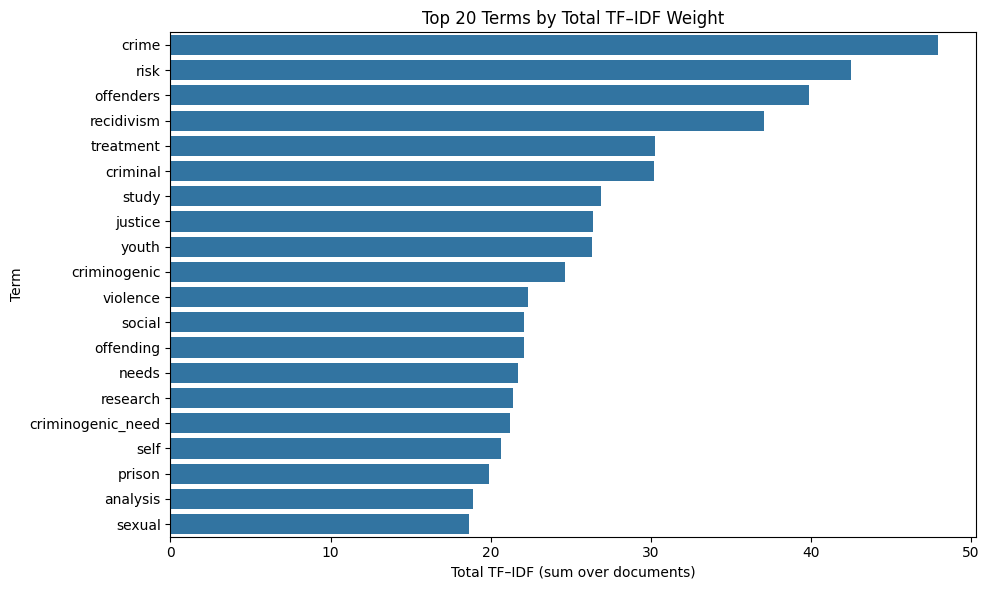

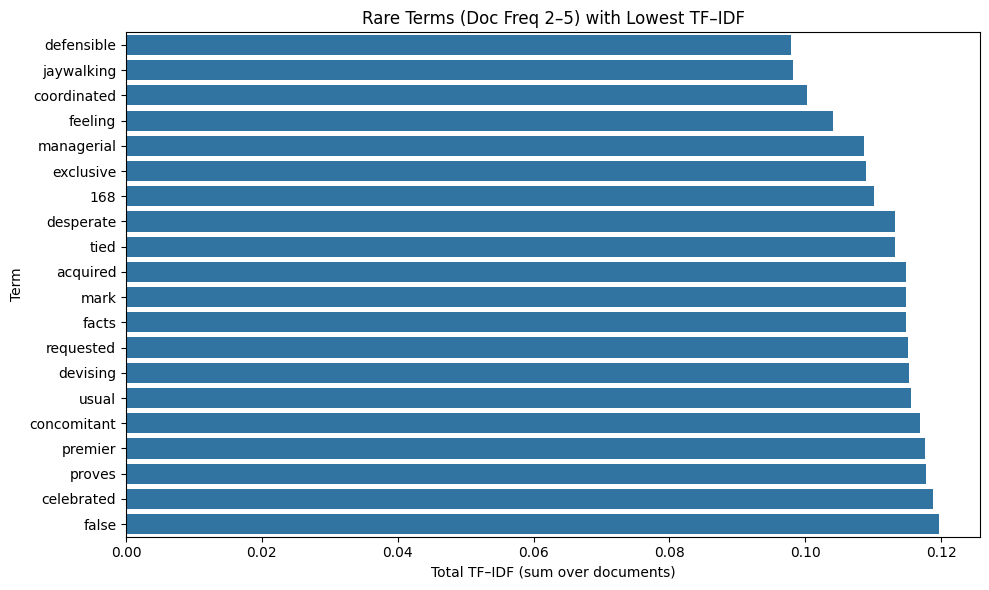

✅ Plots generated: common vs rare TF–IDF terms.


In [ ]:
# ---------------------------------------------------------------
# 3.1a-b Visualize Common vs Rare TF–IDF Terms
# ---------------------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns

# Safety check
if "tfidf_df" not in globals():
    raise ValueError("tfidf_df not found. Run the TF–IDF cell before this visualization cell.")

# 1) Top common / high-impact terms
top_terms = (
    tfidf_df.sort_values("tfidf_sum", ascending=False)
    .head(20)
    .reset_index(drop=True)
)

# 2) Rare-but-present terms (doc_freq between 2 and 5, lowest TF–IDF sum)
rare_terms = (
    tfidf_df[tfidf_df["doc_freq"].between(2, 5)]
    .sort_values("tfidf_sum", ascending=True)
    .head(20)
    .reset_index(drop=True)
)

# --- Plot 1: Common / High TF–IDF terms ---
plt.figure(figsize=(10, 6))
sns.barplot(
    data=top_terms,
    x="tfidf_sum",
    y="term"
)
plt.title("Top 20 Terms by Total TF–IDF Weight")
plt.xlabel("Total TF–IDF (sum over documents)")
plt.ylabel("Term")
plt.tight_layout()
plt.show()

# --- Plot 2: Rare Terms (Low TF–IDF, Appearing in 2–5 Documents) ---
plt.figure(figsize=(10, 6))
sns.barplot(
    data=rare_terms,
    x="tfidf_sum",
    y="term"
)
plt.title("Rare Terms (Doc Freq 2–5) with Lowest TF–IDF")
plt.xlabel("Total TF–IDF (sum over documents)")
plt.ylabel("Term")
plt.tight_layout()
plt.show()

print("✅ Plots generated: common vs rare TF–IDF terms.")


### How to Use TF–IDF Insights Before Proceeding to Step 3.1b

The TF–IDF exploration (Step 3.1a) gives us a data-driven view of which
terms appear frequently and which appear rarely across the corpus.  
This information is useful for refining our stopword and boilerplate
lists before running BERTopic.

Here is how to interpret the results and decide what to update:

---

#### 🔝 1. High TF–IDF Terms (Most Influential)
These words dominate the corpus and strongly affect C-TF-IDF topic
formation.

Look at the **Top Terms plot** and ask:

- Are there *generic* or *non-criminology* terms appearing at the top?
  Examples might include:
  - “system”, “model”, “technology”
  - “approach”, “information”, “method”
- If these words are not meaningful for distinguishing criminogenic
  topics, consider adding them to the **DOMAIN_STOPWORDS** list.

Avoid adding:
- core criminology concepts (e.g., “offender”, “crime”, “risk”)
- protected underscore phrases (e.g., `routine_activity_theory`)

---

#### 🧩 2. Rare Terms (Doc Frequency 2–5)
These are low-impact words, often due to:
- typos or spelling variants  
- overly specific terminology  
- peripheral concepts  

We **do not need to add these to stopwords**, because they occur too
rarely to influence topic formation.  
This plot is mainly for diagnostic purposes (spotting strange tokens).

---

#### 🧹 3. Adjusting the Stopword Lists
Based on the TF–IDF review, update:

1. **ACADEMIC_STOPWORDS**  
   - Keep lemma forms only (e.g., `study` not `studies`)  
   - Add/remove academic boilerplate depending on your dataset  

2. **DOMAIN_STOPWORDS**  
   - Add only *non-criminology* generic technical terms  
   - Never add core criminology terms (e.g., “crime”, “offender”)  

3. **BASE_STOPWORDS**  
   - Use the default sklearn English stopwords (already included)

Any changes here will directly influence how BERTopic constructs topics.

---

#### 🎯 When You Are Satisfied
Once you have reviewed the TF–IDF plots and adjusted your stopword lists,
you can safely proceed to:

### 👉 **3.1b Stopwords + Boilerplate Setup (Lemma-Friendly)**

This ensures that your topic modelling pipeline is built on clean,
interpretable, and domain-appropriate text.


### 3.1b) Define Stopwords and Boilerplate Terms (Lemma-Friendly)

Using the insights from the TF–IDF exploration, we now define the
stopword sets that will be used by BERTopic’s CountVectorizer.

At this stage, we only **prepare** the stopword lists. No text is
modified yet.

Our stopword lists come from three components:

1. **English Stopwords (sklearn)**  
   These remove common grammatical words such as “the”, “and”, “for”.
   They do not carry topic-relevant meaning.

2. **Academic / Boilerplate Stopwords**  
   These include high-frequency academic terms (e.g., “study”, “research”)
   that frequently appear in abstracts but do not define criminogenic
   themes.  
   These are stored in **lemma form**, because we will lemmatize the text
   before vectorization.

3. **Domain Stopwords (Non-criminology)**  
   These include generic technical words (e.g., “system”, “model”) that
   may be overly influential but not meaningful for topic separation.
   Based on TF–IDF, you can expand or reduce this list.

⚠ **Important**:  
We do *not* remove criminology core terms such as “crime”, “offender”, or
“criminal”, because these are essential for topic interpretation.

All three groups are merged into a single `FINAL_STOPWORDS` set.  
This set will be passed directly into BERTopic’s CountVectorizer in Step 3.3.


In [ ]:
# ---------------------------------------------------------------
# 3.1b Stopwords + Boilerplate Setup (lemma-friendly)
# ---------------------------------------------------------------
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

# 1) Base English stopwords (sklearn)
BASE_STOPWORDS = set(ENGLISH_STOP_WORDS)

# 2) Academic / boilerplate stopwords (lemma form only)
ACADEMIC_STOPWORDS = {
    "study", "paper", "research", "method", "analysis",
    "result", "finding", "implication", "purpose",
    "objective", "author", "introduction", "discussion",
    "conclusion"
}

# 3) Domain stopwords (generic technical terms - lemma form only)
# NOTE: Do NOT include criminology core terms like "crime", "offender"
DOMAIN_STOPWORDS = {
    "system",
    "information",
    "model",
    "approach",
    "technology"
}

# 4) Merge all stopwords
FINAL_STOPWORDS = (
    BASE_STOPWORDS
    .union(ACADEMIC_STOPWORDS)
    .union(DOMAIN_STOPWORDS)
)

print(f"📝 Total stopwords in FINAL_STOPWORDS: {len(FINAL_STOPWORDS)}")
print(f"📌 Academic stopwords (lemma): {sorted(list(ACADEMIC_STOPWORDS))[:10]}")
print(f"📌 Domain stopwords (lemma): {sorted(list(DOMAIN_STOPWORDS))}")


📝 Total stopwords in FINAL_STOPWORDS: 336
📌 Academic stopwords (lemma): ['analysis', 'author', 'conclusion', 'discussion', 'finding', 'implication', 'introduction', 'method', 'objective', 'paper']
📌 Domain stopwords (lemma): ['approach', 'information', 'model', 'system', 'technology']


### 3.1c) Lemmatization for `__vectorizer_text__` (with Underscore Protection)

To improve topic quality and ensure our stopword lists work correctly,
we lemmatize the text used by BERTopic's CountVectorizer.

Lemmatization reduces word variants to their base form:

- "models" → "model"  
- "technologies" → "technology"  
- "studies" → "study"  
- "findings" → "finding"

This step ensures that:
- our lemma-based stopwords (e.g., "model", "study") correctly match  
- BERTopic receives a cleaner, more consistent token space  
- topic keywords become sharper and less noisy  

We **do NOT** lemmatize the embedding text (`__embed_text__`), because
transformer models like SPECTER2 rely on natural grammar.

We also **preserve underscore-protected multiword concepts**, such as:

- `routine_activity_theory`
- `low_self_control`
- `risk_need_responsivity`

These terms must remain intact as single tokens because they represent
core criminological constructs.


In [ ]:
# ---------------------------------------------------------------
# 3.1c Lemmatization for __vectorizer_text__ (with tqdm progress bar)
# ---------------------------------------------------------------
import spacy
from tqdm import tqdm

# Load spaCy English model (disable parser/ner for speed)
# Run this once if not installed:
# !python -m spacy download en_core_web_sm

nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])

def lemmatize_token(tok):
    """Lemmatize a single token unless underscore-protected."""
    if "_" in tok:
        return tok  # preserve protected phrases
    doc = nlp(tok)
    return doc[0].lemma_

def lemmatize_vectorizer_text(text):
    """Lemmatize a full __vectorizer_text__ string."""
    if not isinstance(text, str):
        return ""
    tokens = text.split()
    return " ".join(lemmatize_token(t) for t in tokens)

# Apply with tqdm progress bar
df["__vectorizer_text__"] = [
    lemmatize_vectorizer_text(t)
    for t in tqdm(df["__vectorizer_text__"].astype(str), desc="Lemmatizing __vectorizer_text__")
]

print("🔤 Lemmatization complete for __vectorizer_text__")


Lemmatizing __vectorizer_text__: 100%|██████████| 1352/1352 [07:47<00:00,  2.89it/s]

🔤 Lemmatization complete for __vectorizer_text__


In [ ]:
display(df[["__clean__", "__vectorizer_text__"]].head(2))

,__clean__,__vectorizer_text__
0,"social media nicotine markets: criminogenic affordances and market displacements [SEP] illicit drug markets continuously evolve in response to legal regulations, and digital markets similarly adapt, balancing the convenience of online contact with the security of offline transactions. the regulation of nicotine products follows a similar trajectory. in denmark, efforts to curb youth nicotine consumption have led to legislation targeting single-use flavoured vape products, in turn leading to the emergence of illicit social media-based nicotine markets. this criminological paper investigates the dynamics of these markets on snapchat, facebook, instagram, and tiktok, focusing on the interplay between platform affordances and seller behaviours. data: this study draws on ethnographic observations of danish online nicotine markets on social media over a period of 12 months, complemented by 12 qualitative interviews with sellers within these markets. findings: grey markets for nicotine products flourish on surface-level social media and displacement occurs within social media markets and seller practices. further we document how platform features facilitate opportunities for buyers to drift towards markets for illicit drugs and other illegal products and services. sellers describe the market as open, with low barriers of entry. nicotine vapes are also perceived as a preferable product to sell with low punitive measures and enforcement priority, while being less harmful than cigarettes and drugs. conclusion: illicit nicotine vape markets are available on every social media platform. they mimic the structures of illicit drug markets, and share to a degree the same online spaces as algorithms push users from one site to the next. platform algorithms, coupled with features like enhanced user reach and anonymity, create an environment that seller sperceive as low-risk and highly profitable. the combination of these factors is ultimately very damaging for those buying and consuming the products, who are for the most part young people. efforts must also address the unintended negative consequences of current regulations. [SEP] affordance; illicit markets; nicotine vape; social media; digital drift; online ethnography; illegal drugs; criminology",social medium nicotine market criminogenic affordance and market displacement illicit drug market continuously evolve in response to legal regulation and digital market similarly adapt balance the convenience of online contact with the security of offline transaction the regulation of nicotine product follow a similar trajectory in denmark effort to curb youth nicotine consumption have lead to legislation target single flavour vape product in turn lead to the emergence of illicit social media nicotine market this criminological paper investigate the dynamic of these market on snapchat facebook instagram and tiktok focus on the interplay between platform affordance and seller behaviour datum this study draw on ethnographic observation of danish online nicotine market on social medium over a period of 12 month complement by 12 qualitative interview with seller within these market finding grey market for nicotine product flourish on surface social medium and displacement occur within social medium market and seller practice far we document how platform feature facilitate opportunity for buyer to drift towards market for illicit drug and other illegal product and service seller describe the market as open with low barrier of entry nicotine vape be also perceive as a preferable product to sell with low punitive measure and enforcement priority while be less harmful than cigarette and drug conclusion illicit nicotine vape market be available on every social medium platform they mimic the structure of illicit drug market and share to a degree the same online space as algorithm push user from one site to the next platform algorithm couple with feature like enhance user reac

### 3.1d) Inspect Stopword + Boilerplate Removal (Preview Only)

Before passing `FINAL_STOPWORDS` into BERTopic, we create a small
diagnostic preview showing how stopword and boilerplate removal would
affect the lemmatized `__vectorizer_text__`.

For a sample of documents, we display:

- the original `__vectorizer_text__`
- a cleaned preview with stopwords removed
- the list of tokens that were removed

This helps verify that:
- important criminology concepts are not being removed
- academic boilerplate and generic technical terms are being removed as intended


In [ ]:
# ---------------------------------------------------------------
# Inspect Stopword + Boilerplate Removal (Preview Only)
# ---------------------------------------------------------------
def remove_stopwords_for_preview(text, stopwords):
    """Return (kept_tokens, removed_tokens) for inspection only."""
    if not isinstance(text, str):
        return [], []
    tokens = text.split()
    kept = [t for t in tokens if t.lower() not in stopwords]
    removed = [t for t in tokens if t.lower() in stopwords]
    return kept, removed

rows = []

# Inspect first 3 rows (adjust if you want)
for i, row in df.head(3).iterrows():
    original = row["__vectorizer_text__"]
    kept, removed = remove_stopwords_for_preview(original, FINAL_STOPWORDS)

    rows.append({
        "id": row.get("id", i),
        "original_vectorizer_text": original,
        "cleaned_preview": " ".join(kept),
        "removed_tokens": removed
    })

preview_df = pd.DataFrame(rows)

print("🔎 Preview of stopword + boilerplate removal (first 20 rows):")



🔎 Preview of stopword + boilerplate removal (first 20 rows):


In [ ]:
display(preview_df)

,id,original_vectorizer_text,cleaned_preview,removed_tokens
0,0,social medium nicotine market criminogenic affordance and market displacement illicit drug market continuously evolve in response to legal regulation and digital market similarly adapt balance the convenience of online contact with the security of offline transaction the regulation of nicotine product follow a similar trajectory in denmark effort to curb youth nicotine consumption have lead to legislation target single flavour vape product in turn lead to the emergence of illicit social media nicotine market this criminological paper investigate the dynamic of these market on snapchat facebook instagram and tiktok focus on the interplay between platform affordance and seller behaviour datum this study draw on ethnographic observation of danish online nicotine market on social medium over a period of 12 month complement by 12 qualitative interview with seller within these market finding grey market for nicotine product flourish on surface social medium and displacement occur within social medium market and seller practice far we document how platform feature facilitate opportunity for buyer to drift towards market for illicit drug and other illegal product and service seller describe the market as open with low barrier of entry nicotine vape be also perceive as a preferable product to sell with low punitive measure and enforcement priority while be less harmful than cigarette and drug conclusion illicit nicotine vape market be available on every social medium platform they mimic the structure of illicit drug market and share to a degree the same online space as algorithm push user from one site to the next platform algorithm couple with feature like enhance user reach and anonymity create an environment that seller sperceive as low and highly profitable the combination of these factor be ultimately very damage for those buy and consume the product who be for the most part young people effort must also address the unintended negative consequence of current regulation affordance illicit market nicotine vape social medium digital drift online ethnography illegal drug criminology,social medium nicotine market criminogenic affordance market displacement illicit drug market continuously evolve response legal regulation digital market similarly adapt balance convenience online contact security offline transaction regulation nicotine product follow similar trajectory denmark effort curb youth nicotine consumption lead legislation target single flavour vape product turn lead emergence illicit social media nicotine market criminological investigate dynamic market snapchat facebook instagram tiktok focus interplay platform affordance seller behaviour datum draw ethnographic observation danish online nicotine market social medium period 12 month complement 12 qualitative interview seller market grey market nicotine product flourish surface social medium displacement occur social medium market seller practice far document platform feature facilitate opportunity buyer drift market illicit drug illegal product service seller market open low barrier entry nicotine vape perceive preferable product sell low punitive measure enforcement priority harmful cigarette drug illicit nicotine vape market available social medium platform mimic structure illicit drug market share degree online space algorithm push user site platform algorithm couple feature like enhance user reach anonymity create environment seller sperceive low highly profitable combination factor ultimately damage buy consume product young people effort address unintended negative consequence current regulation affordance illicit market nicotine vape social medium digital drift online ethnography illegal drug criminology,"[and, in, to, and, the, of, with, the, of, the, of, a, in, to, have, to, in, to, the, of, this, paper, the, of, these, on, and, on, the, between, and, this, study, on, of, on, over, a, of, by, with, within

📦 Total removed tokens across corpus (including English stopwords): 99538
📦 Removed non-English stopwords (academic + domain etc.): 6546


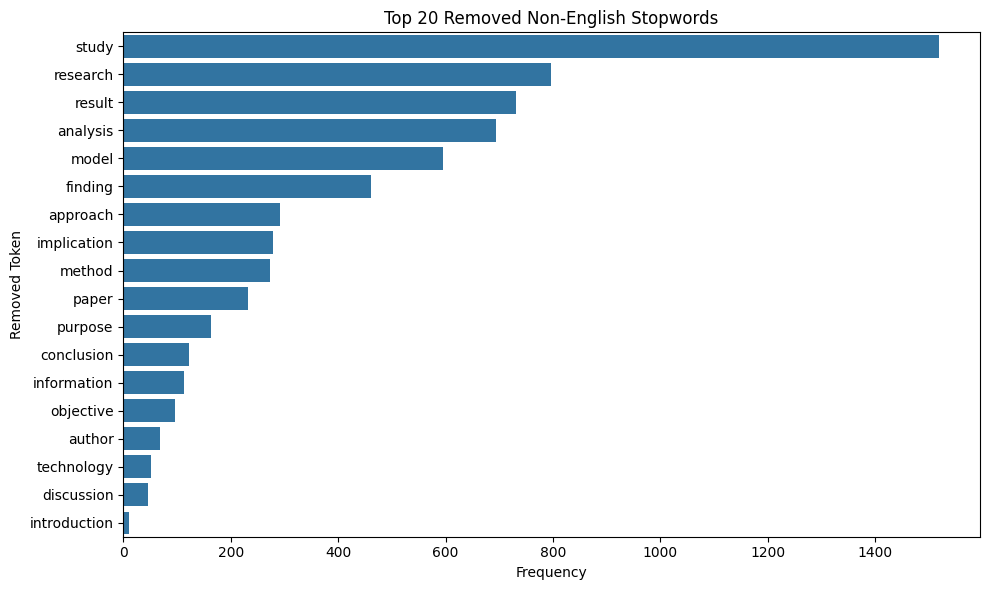

🔍 Top removed non-English stopwords (full corpus):
study                1519
research             797
result               731
analysis             693
model                596
finding              461
approach             292
implication          279
method               274
paper                232
purpose              163
conclusion           123
information          113
objective            96
author               68
technology           52
discussion           46
introduction         11


In [ ]:
# ---------------------------------------------------------------
# 3.1d (Full Dataset) – Global Analysis of Removed Tokens
# ---------------------------------------------------------------
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

def get_removed_tokens_full(text, stopwords):
    """Return list of removed tokens for a full row."""
    if not isinstance(text, str):
        return []
    tokens = text.split()
    return [t.lower() for t in tokens if t.lower() in stopwords]

all_removed_full = []

# Iterate over ALL rows in the dataframe
for txt in df["__vectorizer_text__"].astype(str):
    all_removed_full.extend(get_removed_tokens_full(txt, FINAL_STOPWORDS))

print(f"📦 Total removed tokens across corpus (including English stopwords): {len(all_removed_full)}")

# Focus on non-English stopwords (i.e., custom academic + domain stopwords)
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
EN_STOPWORDS = set(ENGLISH_STOP_WORDS)

non_english_removed = [tok for tok in all_removed_full if tok not in EN_STOPWORDS]

print(f"📦 Removed non-English stopwords (academic + domain etc.): {len(non_english_removed)}")

# Frequency count
removed_counter_full = Counter(non_english_removed)
top_removed_full = removed_counter_full.most_common(20)  # top 20

if not top_removed_full:
    print("⚠️ No non-English stopwords removed across the corpus.")
else:
    tokens, counts = zip(*top_removed_full)

    # Barplot: Top removed non-English stopwords (full dataset)
    plt.figure(figsize=(10, 6))
    sns.barplot(x=list(counts), y=list(tokens))
    plt.title("Top 20 Removed Non-English Stopwords")
    plt.xlabel("Frequency")
    plt.ylabel("Removed Token")
    plt.tight_layout()
    plt.show()

    print("🔍 Top removed non-English stopwords (full corpus):")
    for tok, cnt in top_removed_full:
        print(f"{tok:<20} {cnt}")


### 3.1e) Inspect Underscore-Protected Tokens in `__vectorizer_text__`

To verify that our concept normalization and underscore protection are
working correctly, we inspect tokens that contain underscores in
`__vectorizer_text__`.

These underscore tokens typically represent multiword criminology or AI
concepts such as:

- `routine_activity_theory`
- `situational_action_theory`
- `artificial_intelligence`
- `risk_need_responsivity`

We list a sample of documents that contain such tokens and show the
actual underscore terms. This helps confirm that important concepts are
being preserved as single tokens for BERTopic.

In [ ]:
# ---------------------------------------------------------------
# 3.1e Inspect underscore-protected tokens in __vectorizer_text__
# ---------------------------------------------------------------
import re
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

def extract_underscore_tokens(text):
    """Extract tokens with underscores from a string."""
    if not isinstance(text, str):
        return []
    return re.findall(r"\b[a-zA-Z0-9]+(?:_[a-zA-Z0-9]+)+\b", text)

# Extract all underscore tokens into a list
all_underscore_tokens = []

df["__underscore_hits__"] = df["__vectorizer_text__"].apply(
    lambda x: extract_underscore_tokens(x)
)

# Flatten all underscore tokens from the full dataset
for lst in df["__underscore_hits__"]:
    if isinstance(lst, list):
        all_underscore_tokens.extend(lst)

num_docs = df["__underscore_hits__"].astype(bool).sum()
print(f"📌 Documents containing underscore-protected tokens: {num_docs}")
print(f"📦 Total underscore tokens across corpus: {len(all_underscore_tokens)}")

# Show examples
print("\n🔍 Example rows with underscore tokens:")
display(
    df[df["__underscore_hits__"].astype(bool)]
      [["id", "unique_id", "__underscore_hits__", "__vectorizer_text__"]]
      .head(2)
)



📌 Documents containing underscore-protected tokens: 926
📦 Total underscore tokens across corpus: 4016

🔍 Example rows with underscore tokens:


,id,unique_id,__underscore_hits__,__vectorizer_text__
1,1,WOS:001590485400001,"[risk_factors, criminogenic_need]",explore the factor that differentiate individual and group offender in cyber crime not much be know about the characteristic of solo offender relative to group offender engage in cyberdependent crime this cross survey study utilize a general population sample of 1240 dutch young people respondent complete a battery of validate measurement that measure lifetime offend behavior and screen for risk_factors. multinominal regression model be estimate to explore the factor that differentiate solo offender from group offender engage in low and high form of cybercrime analysis reveal that solo offender show a different profile than those who offend together with other and that correlate be particularly dependent on the level of technical sophistication of crime low solo offender seem to act more opportunistically whereas high solo offender have programming skill and higher level of self finding imply that co in cyber crime may be more of an instrumental choice for offender who have insufficient capability to offend alone co cybercrime cyber crime solo offend criminogenic_need. criminal attitude cybercriminal network empirical status concise measure validity sample scale solo victimization organization
2,2,WOS:001584267400001,"[risk_assessment, level_of_service_case_management_inventory, level_of_service_case_management_inventory, level_of_service_case_management_inventory, risk_assessment, criminogenic_need, level_of_service, case_management_inventory, risk_assessment]","validation of the orac an actuarial risk_assessment tool for general recidivism a psychometric analysis base on messick validity framework this article introduce messick approach to validation by examine the psychometric property of orac an actuarial tool that have be use in the province of quebec since 2019 the instrument replace the level_of_service_case_management_inventory, which be deem too time consume for quebec correctional system which deal with short incarceration term less than 2 year and probation the instrument maintain adherence to risk need and responsivity principle espouse by other comparable instrument but it be more tailor toward short sentence messick approach to validity testing which depart from prior psychometric test use with actuarial assessment tool be use to assess the psychometric quality of the orac empirical analysis be conduct with both the orac and the level_of_service_case_management_inventory use datum from two sample each 19,349 man and 3522 woman with the orac and 44,077 man and 6490 woman with the level_of_service_case_management_inventory . the promise result stress the relevance of messick approach as a more advance validation process by which risk_assessment tool can be examine criminogenic_need; messick model level_of_service; case_management_inventory; orac risk_assessment; validity psychological service level rehabilitation prediction female alpha score area"


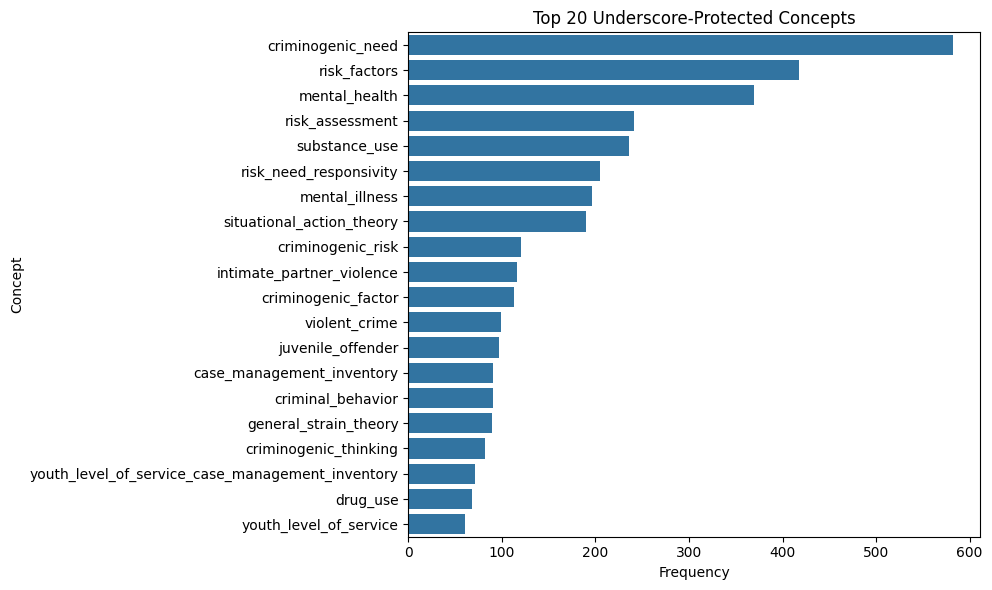


🔍 Top underscore concepts:
criminogenic_need                        582
risk_factors                             418
mental_health                            369
risk_assessment                          241
substance_use                            236
risk_need_responsivity                   205
mental_illness                           196
situational_action_theory                190
criminogenic_risk                        121
intimate_partner_violence                116
criminogenic_factor                      113
violent_crime                            99
juvenile_offender                        97
case_management_inventory                91
criminal_behavior                        91
general_strain_theory                    89
criminogenic_thinking                    82
youth_level_of_service_case_management_inventory 71
drug_use                                 68
youth_level_of_service                   61


In [ ]:
# ---------------------------------------------------------------
# Visualization 1: Barplot of Top Underscore Concepts
# ---------------------------------------------------------------

freq = Counter(all_underscore_tokens)
top_underscore = freq.most_common(20)

if top_underscore:
    tokens, counts = zip(*top_underscore)

    plt.figure(figsize=(10, 6))
    sns.barplot(x=list(counts), y=list(tokens))
    plt.title("Top 20 Underscore-Protected Concepts")
    plt.xlabel("Frequency")
    plt.ylabel("Concept")
    plt.tight_layout()
    plt.show()

    print("\n🔍 Top underscore concepts:")
    for t, c in top_underscore:
        print(f"{t:<40} {c}")
else:
    print("⚠️ No underscore tokens found.")



### 3.1f) Conclusion

In this section, we transformed our cleaned text into a format optimized
for BERTopic’s C-TF-IDF topic modelling pipeline. This involved several
carefully structured preprocessing steps to ensure high-quality,
interpretable topics.

#### 🔧 Key Steps Completed

1. **Built `__vectorizer_text__`**  
   - Started from the lightly cleaned `__clean__` column  
   - Standardized sentence boundaries  
   - Normalized multi-word criminology/AI concepts into
     underscore-protected tokens (e.g., `routine_activity_theory`)  
   - Ensured these conceptual tokens behave as single units in topic modelling

2. **Explored TF–IDF Distributions (`3.1a`)**  
   - Computed corpus-wide TF–IDF scores (excluding English stopwords)  
   - Identified high-impact and rare terms  
   - Used these insights to guide our stopword and boilerplate decisions

3. **Defined Lemma-Friendly Stopwords (`3.1b`)**  
   - Combined English stopwords, academic boilerplate, and generic
     domain terms  
   - Excluded all criminology-core words such as “crime”, “offender”,
     “delinquency”, etc.  
   - Designed the stopword sets to align with upcoming lemmatization

4. **Lemmatized `__vectorizer_text__` (`3.1c`)**  
   - Reduced tokens to their lemma form  
   - Preserved underscore-protected criminological concepts  
   - Ensured accurate matching with our lemma-based stopword lists

5. **Inspected Stopword Removal (`3.1d`)**  
   - Previewed how stopwords affect text  
   - Verified that only generic academic/domain terms were removed  
   - Confirmed that key criminology concepts remained untouched  
   - Visualized the most frequently removed non-English stopwords across
     the full dataset

6. **Inspected Underscore-Protected Tokens (`3.1e`)**  
   - Extracted and reviewed all conceptual multi-word tokens  
   - Verified the presence of core criminogenic constructs  
   - Visualized the most common protected concepts to ensure proper
     phrase normalization

#### 🧠 Why This Matters

This multi-step preparation ensures that:

- BERTopic receives clean, semantically meaningful documents  
- High-frequency noise and academic boilerplate do not overwhelm topics  
- Conceptual criminology constructs remain intact  
- Topic clusters will be sharper, more coherent, and more interpretable  
- The pipeline is fully aligned with your methodological requirements for
  the review article

With these steps complete, our text is now fully prepared for BERTopic’s
embedding alignment and clustering process.

---

### ▶️ Next Step: **3.2 Prepare Documents & Check Embedding Alignment**
We now convert the processed vectorizer text into a `docs` list and
validate alignment with the embedding matrix generated in Section 2.


## 3.2) Prepare Documents and Validate Embedding Alignment

BERTopic requires two perfectly aligned inputs:

1. **Documents (`docs`)**  
   - These are the lemmatized + cleaned strings from `__vectorizer_text__`.  
   - They are used by BERTopic’s CountVectorizer to build the C-TF-IDF representation of topics.

2. **Embeddings (`embeddings`)**  
   - These were generated previously in Section 2 using the
     SPECTER2 embedding model (`__embed_text__`).
   - Each embedding vector must correspond *exactly* to the same row in `docs`.

This step performs:
- conversion of `__vectorizer_text__` into a document list  
- validation that the number of embeddings matches the number of documents  
- a hard safety check to prevent misalignment errors in BERTopic

If a mismatch is detected, we stop the pipeline immediately.


In [ ]:
# ---------------------------------------------------------------
# 3.2 Prepare documents and embeddings for BERTopic
# ---------------------------------------------------------------

# Documents for BERTopic's CountVectorizer
docs = df["__vectorizer_text__"].fillna("").astype(str).tolist()

# Number of documents
n_docs = len(docs)
print(f"📄 Documents for BERTopic: {n_docs}")

# Embedding alignment check
embedding_rows = embeddings.shape[0]
embedding_dim = embeddings.shape[1]

if embedding_rows != n_docs:
    raise ValueError(
        f"❌ Misalignment detected:\n"
        f"   ↳ embeddings rows = {embedding_rows}\n"
        f"   ↳ docs count      = {n_docs}\n"
        "\nThese MUST be identical before running BERTopic.\n"
        "Check filtering steps in Section 1 for any dropped rows."
    )

print(f"✅ Embeddings aligned: {embedding_rows} vectors match {n_docs} docs")
print(f"🔢 Embedding dimension: {embedding_dim}")


📄 Documents for BERTopic: 1352
✅ Embeddings aligned: 1352 vectors match 1352 docs
🔢 Embedding dimension: 768


### 3.2b) Document & Embedding Sanity Check

Before running BERTopic, we perform a quick diagnostic check on both the
lemmatized documents (`docs`) and their corresponding SPECTER2 embeddings.

This helps us detect:

- empty or near-empty documents  
- extremely short texts that may cause unstable clustering  
- unusual embedding vectors (e.g., zero vectors or extremely low norms)  
- alignment issues between text length and embedding magnitude  

These checks ensure that BERTopic receives clean, consistent inputs and
helps prevent silent failures or low-quality topic formation.


In [ ]:
# ---------------------------------------------------------------
# 3.2b Sanity Check: Document Text & Embedding Health
# ---------------------------------------------------------------
import numpy as np
import pandas as pd

# Convert docs to Series for easy processing
docs_series = pd.Series(docs)

# 1. Check document lengths
doc_lengths = docs_series.str.split().apply(len)

print("📏 Document Length Statistics:")
print(doc_lengths.describe())

# Show extreme short docs (length < 5)
short_docs_idx = doc_lengths[doc_lengths < 5].index.tolist()
print(f"\n⚠️ Documents with fewer than 5 tokens: {len(short_docs_idx)}")

if short_docs_idx:
    display(df.loc[short_docs_idx, ["id", "__vectorizer_text__", "__clean__"]].head(10))

# 2. Embedding vector norms (to detect abnormal vectors)
embedding_norms = np.linalg.norm(embeddings, axis=1)

print("\n📐 Embedding Norm Statistics:")
print(pd.Series(embedding_norms).describe())

zero_vec_idx = np.where(embedding_norms == 0)[0]
tiny_vec_idx = np.where(embedding_norms < 1e-6)[0]

print(f"\n⚠️ Zero embedding vectors: {len(zero_vec_idx)}")
print(f"⚠️ Nearly-zero embedding vectors (<1e-6): {len(tiny_vec_idx)}")

if len(zero_vec_idx) > 0:
    print("\n🔍 Example rows with zero embeddings:")
    display(df.loc[zero_vec_idx, ["id", "__embed_text__"]].head())

# 3. Correlation between doc length and embedding norm (optional insight)
corr = np.corrcoef(doc_lengths, embedding_norms)[0, 1]
print(f"\n🔗 Correlation between document length and embedding norm: {corr:.4f}")


📏 Document Length Statistics:
count    1352.000000
mean      184.872781
std        72.477466
min        15.000000
25%       142.000000
50%       177.000000
75%       220.000000
max      1079.000000
dtype: float64

⚠️ Documents with fewer than 5 tokens: 0

📐 Embedding Norm Statistics:
count    1.352000e+03
mean     1.000000e+00
std      4.835076e-08
min      9.999998e-01
25%      9.999999e-01
50%      1.000000e+00
75%      1.000000e+00
max      1.000000e+00
dtype: float64

⚠️ Zero embedding vectors: 0
⚠️ Nearly-zero embedding vectors (<1e-6): 0

🔗 Correlation between document length and embedding norm: -0.0174


## 3.3) BERTopic

### 3.3a) Imports & Helper Functions

In [ ]:
# ---------------------------------------------------------------
# Imports & Helper Functions
# ---------------------------------------------------------------

import umap.umap_ as umap
import hdbscan
from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora import Dictionary
import numpy as np, pandas as pd

# ------------ Helpers ------------
def topic_top_words(model: BERTopic, top_n: int = 10):
    info = model.get_topic_info()
    tids = [t for t in info.Topic if t != -1]
    return {t: [w for w, _ in model.get_topic(t)[:top_n]] for t in tids}

def topic_diversity(tw: dict) -> float:
    allw = [w for ws in tw.values() for w in ws]
    return 100.0 * (len(set(allw)) / max(1, len(allw)))

def c_npmi_from_texts(tw: dict, texts: list) -> float:
    if not tw:  # no topics
        return -1.0
    tokenized_docs = [t.split() for t in texts]
    dictionary = Dictionary(tokenized_docs)
    cm = CoherenceModel(
        topics=list(tw.values()),
        texts=tokenized_docs,
        dictionary=dictionary,
        coherence='c_npmi'
    )
    return float(cm.get_coherence())

def evaluate(model: BERTopic, docs: list, top_n=10):
    info = model.get_topic_info()
    has_noise = (-1 in info.Topic.values) if hasattr(info, "Topic") else False
    noise_count = int(info[info.Topic == -1]['Count']) if has_noise else 0
    n_topics = int((info.Topic != -1).sum())
    if n_topics == 0:
        return {"n_topics": 0, "noise_frac": 1.0, "diversity": 0.0, "c_npmi": -1.0}
    noise_frac = noise_count / max(1, len(docs))
    tw = topic_top_words(model, top_n)
    return {
        "n_topics": n_topics,
        "noise_frac": noise_frac,
        "diversity": topic_diversity(tw),
        "c_npmi": c_npmi_from_texts(tw, docs),
    }

def build_model(umap_params, hdb_params, vectorizer_params, min_topic_size, stop_words=None):
    """
    Build BERTopic model using custom UMAP, HDBSCAN, and CountVectorizer.
    - Preserves underscored tokens
    - Accepts merged FINAL_STOPWORDS
    - Embeddings will be passed manually at fit_transform()
    """
    umap_model = umap.UMAP(**umap_params)
    hdbscan_model = hdbscan.HDBSCAN(**hdb_params)
    vectorizer_model = CountVectorizer(
        **vectorizer_params,
        stop_words=stop_words,
        token_pattern=r"(?u)\b\w+\b"  # keep underscored tokens intact
    )
    model = BERTopic(
        embedding_model=None,          # we pass embeddings manually
        umap_model=umap_model,
        hdbscan_model=hdbscan_model,
        vectorizer_model=vectorizer_model,
        min_topic_size=min_topic_size,
        calculate_probabilities=True,
        verbose=False
    )
    return model


### 3.3b) Parameter grid for BERTopic auto-tuning

In [ ]:
# ---------------------------------------------------------------
# Parameter grid for BERTopic auto-tuning
# ---------------------------------------------------------------
SEED = 42

# IMPORTANT: use vectorizer-ready text (after boilerplate removal + optional lemmatization)
docs = df["__vectorizer_text__"].tolist()

desired_K = 60          # soft target for #topics
min_topics_allowed = 6  # skip degenerate runs

param_grid = []

# -------------------- UMAP --------------------
for n_neighbors in [10, 15]:
    for min_dist in [0.05, 0.1]:
        for n_components in [10, 15]:
            # -------------------- HDBSCAN --------------------
            for min_cluster_size in [8, 10]:
                for min_samples in [1, 2]:
                    # -------------------- BERTopic min topic size --------------------
                    for min_topic_size in [5, 8]:
                        # -------------------- Merge tolerance (epsilon) --------------------
                        for eps in [0.00, 0.05]:
                            param_grid.append({
                                "umap": {
                                    "n_neighbors": n_neighbors,
                                    "n_components": n_components,
                                    "min_dist": min_dist,
                                    "metric": "cosine",
                                    "random_state": SEED,
                                },
                                "hdb": {
                                    "min_cluster_size": min_cluster_size,
                                    "min_samples": min_samples,
                                    "metric": "euclidean",
                                    "cluster_selection_method": "eom",
                                    "cluster_selection_epsilon": eps,
                                    "prediction_data": True,
                                },
                                "vec": {
                                    "ngram_range": (1, 2),
                                    "min_df": 2,
                                    "max_df": 1.0,
                                    # NOTE: stopwords are passed via build_model(..., stop_words=FINAL_STOPWORDS)
                                    # We do NOT set stop_words here to avoid duplication.
                                },
                                "min_topic_size": min_topic_size,
                            })

len(param_grid)

128

In [ ]:
# ---------------------------------------------------------------
# Parameter grid for BERTopic auto-tuning
# ---------------------------------------------------------------
SEED = 42

# IMPORTANT: use vectorizer-ready text (after boilerplate removal + optional lemmatization)
docs = df["__vectorizer_text__"].tolist()

desired_K = 60          # soft target for #topics
min_topics_allowed = 6  # skip degenerate runs

param_grid = []

# -------------------- UMAP --------------------
for n_neighbors in [10]:
    for min_dist in [0.05]:
        for n_components in [10]:
            # -------------------- HDBSCAN --------------------
            for min_cluster_size in [8, 10]:
                for min_samples in [1]:
                    # -------------------- BERTopic min topic size --------------------
                    for min_topic_size in [5, 8]:
                        # -------------------- Merge tolerance (epsilon) --------------------
                        for eps in [0.00, 0.05]:
                            param_grid.append({
                                "umap": {
                                    "n_neighbors": n_neighbors,
                                    "n_components": n_components,
                                    "min_dist": min_dist,
                                    "metric": "cosine",
                                    "random_state": SEED,
                                },
                                "hdb": {
                                    "min_cluster_size": min_cluster_size,
                                    "min_samples": min_samples,
                                    "metric": "euclidean",
                                    "cluster_selection_method": "eom",
                                    "cluster_selection_epsilon": eps,
                                    "prediction_data": True,
                                },
                                "vec": {
                                    "ngram_range": (1, 2),
                                    "min_df": 2,
                                    "max_df": 1.0,
                                    # NOTE: stopwords are passed via build_model(..., stop_words=FINAL_STOPWORDS)
                                    # We do NOT set stop_words here to avoid duplication.
                                },
                                "min_topic_size": min_topic_size,
                            })

len(param_grid)

8

### 3.3c) Grid Search & Scoring

In [ ]:
# ---------------------------------------------------------------
# Grid Search & Scoring (with Topic −1 band preference)
# ---------------------------------------------------------------
best = {"score": -1}
results = []

# Topic −1 target band (noise fraction)
target_low, target_high = 0.10, 0.15
target_mid = 0.125

best_inband = None

for i, p in enumerate(param_grid, 1):
    print(
        f"\n[{i}/{len(param_grid)}] "
        f"UMAP(n_neighbors={p['umap']['n_neighbors']}, min_dist={p['umap']['min_dist']}, n_comp={p['umap']['n_components']}) | "
        f"HDB(min_clust={p['hdb']['min_cluster_size']}, min_samp={p['hdb']['min_samples']}, eps={p['hdb']['cluster_selection_epsilon']}) | "
        f"min_topic_size={p['min_topic_size']}"
    )

    # Build model; pass merged stopwords (keeps underscored tokens via helper's token_pattern)
    m = build_model(
        umap_params=p["umap"],
        hdb_params=p["hdb"],
        vectorizer_params=p["vec"],
        min_topic_size=p["min_topic_size"],
        stop_words=list(FINAL_STOPWORDS) # <-- from your earlier boilerplate/stopword cell
    )

    # Fit with precomputed embeddings and vectorizer-ready docs
    topics_try, probs_try = m.fit_transform(docs, embeddings=embeddings)

    met = evaluate(m, docs, top_n=10)

    # Skip if too few topics
    if met["n_topics"] < min_topics_allowed:
        results.append({"i": i, "params": p, **met, "score": -1.0})
        continue

    # Composite score
    noise_pen = max(0.0, met["noise_frac"] - 0.30)  # allow up to 30% noise before penalizing
    target_bonus = 1.0 - min(1.0, abs(met["n_topics"] - desired_K) / max(1, desired_K))  # 0..1
    base_score = (
        (1.0 * max(0, met["c_npmi"])) +
        (0.7 * (met["diversity"] / 100.0)) -
        (0.8 * noise_pen) +
        (0.5 * target_bonus)
    )

    # Soft preference for noise in 10–15%
    noise_band_pen = min(1.0, abs(met["noise_frac"] - target_mid) / target_mid)  # 0..1
    score = base_score - 0.25 * noise_band_pen

    # Record
    results.append({"i": i, "params": p, **met, "score": score})

    # Track best overall
    if score > best["score"]:
        best = {
            "score": score, "model": m, "topics": topics_try, "probs": probs_try,
            "params": p, "metrics": met
        }

    # Track best inside the Topic −1 band
    in_band = (target_low <= met["noise_frac"] <= target_high)
    if in_band and (best_inband is None or score > best_inband["score"]):
        best_inband = {
            "score": score, "model": m, "topics": topics_try, "probs": probs_try,
            "params": p, "metrics": met
        }

# Prefer in-band result if available
if best_inband is not None:
    best = best_inband
    print("\n✅ Selected best configuration INSIDE the Topic −1 target band (10–15%).")
else:
    print("\nℹ️ No configuration landed inside the Topic −1 band; kept best overall by score.")



[1/8] UMAP(n_neighbors=10, min_dist=0.05, n_comp=10) | HDB(min_clust=8, min_samp=1, eps=0.0) | min_topic_size=5

[2/8] UMAP(n_neighbors=10, min_dist=0.05, n_comp=10) | HDB(min_clust=8, min_samp=1, eps=0.05) | min_topic_size=5

[3/8] UMAP(n_neighbors=10, min_dist=0.05, n_comp=10) | HDB(min_clust=8, min_samp=1, eps=0.0) | min_topic_size=8

[4/8] UMAP(n_neighbors=10, min_dist=0.05, n_comp=10) | HDB(min_clust=8, min_samp=1, eps=0.05) | min_topic_size=8

[5/8] UMAP(n_neighbors=10, min_dist=0.05, n_comp=10) | HDB(min_clust=10, min_samp=1, eps=0.0) | min_topic_size=5

[6/8] UMAP(n_neighbors=10, min_dist=0.05, n_comp=10) | HDB(min_clust=10, min_samp=1, eps=0.05) | min_topic_size=5

[7/8] UMAP(n_neighbors=10, min_dist=0.05, n_comp=10) | HDB(min_clust=10, min_samp=1, eps=0.0) | min_topic_size=8

[8/8] UMAP(n_neighbors=10, min_dist=0.05, n_comp=10) | HDB(min_clust=10, min_samp=1, eps=0.05) | min_topic_size=8

ℹ️ No configuration landed inside the Topic −1 band; kept best overall by score.


### 3.3d) Composite Scoring Formula for Topic Model Evaluation

In [ ]:
# ---------------------------------------------------------------
# Composite Scoring Formula for Topic Model Evaluation
# ---------------------------------------------------------------
# The final score used for model selection is a weighted hybrid metric:
#
#   score = base_score - 0.25 * noise_band_pen
#
#   base_score = (1.0 * coherence)                  # topic semantic coherence (c_npmi)
#               + (0.7 * (diversity / 100))         # encourages distinct topic vocabularies
#               - (0.8 * noise_pen)                 # penalizes high proportion of Topic −1
#               + (0.5 * target_bonus)              # rewards closeness to desired topic count (K)
#
#   noise_pen = max(0, noise_frac - 0.30)
#       → allows up to 30% unclustered documents before penalizing
#
#   target_bonus = 1 - min(1, abs(n_topics - desired_K) / desired_K)
#       → ranges [0,1]; higher when closer to desired topic count
#
#   noise_band_pen = min(1, abs(noise_frac - 0.125) / 0.125)
#       → softly prefers Topic −1 fraction near 10–15% (empirically stable models)
#
# ---------------------------------------------------------------
# 📚 References / Rationale:
#
# - Lau, J., Newman, D., & Baldwin, T. (2014).
#   Machine Reading Tea Leaves: Automatically Evaluating Topic Coherence and Topic Model Quality.
#   *EACL 2014.*
#
# - Röder, M., Both, A., & Hinneburg, A. (2015).
#   Exploring the Space of Topic Coherence Measures.
#   *WSDM 2015.* https://doi.org/10.1145/2684822.2685324
#
# - Grootendorst, M. (2022).
#   BERTopic: Neural topic modeling with a class-based TF-IDF procedure.
#   *arXiv:2203.05794.*  (esp. discussion of topic diversity & topic −1 trade-off)
#
# These papers motivate combining coherence, diversity, and noise-control
# to balance interpretability and stability in topic model selection.
# ---------------------------------------------------------------


In [ ]:
# ---------------------------------------------------------------
# Inspect grid-search results BEFORE leaf refinement
# ---------------------------------------------------------------
import pandas as pd

total_runs = len(results)  # or len(param_grid)

res_df = (
    pd.DataFrame(results)
    .sort_values("score", ascending=False)
    .reset_index(drop=True)
)

print(f"✅ Grid search completed with {total_runs} configurations.\n")

# unpack a few params for readability
res_df["umap_n_neighbors"] = res_df["params"].apply(lambda p: p["umap"]["n_neighbors"])
res_df["hdb_min_cluster"]  = res_df["params"].apply(lambda p: p["hdb"]["min_cluster_size"])
res_df["hdb_min_samples"]  = res_df["params"].apply(lambda p: p["hdb"]["min_samples"])
res_df["hdb_eps"]          = res_df["params"].apply(lambda p: p["hdb"].get("cluster_selection_epsilon", 0.0))

# nice run-id
res_df["run_id"] = res_df["i"].astype(str) + f"/{total_runs}"

print("🔎 Top 10 configurations from grid search (EOM only):")
display(
    res_df[[
        "run_id",
        "n_topics",
        "noise_frac",
        "diversity",
        "c_npmi",
        "score",
        "umap_n_neighbors",
        "hdb_min_cluster",
        "hdb_min_samples",
        "hdb_eps",
    ]].head(10)
)

# ---------------------------------------------------------------
# Highlight current best model (EOM)
# ---------------------------------------------------------------
print("\n🏆 CURRENT BEST MODEL (EOM)")
print("────────────────────────────")
print(f"• Topics discovered : {best['metrics']['n_topics']}")
print(f"• Noise fraction    : {best['metrics']['noise_frac']:.2%}")
print(f"• Diversity         : {best['metrics']['diversity']:.2f}")
print(f"• c_npmi (coherence): {best['metrics']['c_npmi']:.4f}")

umap_n       = best["params"]["umap"]["n_neighbors"]
hdb_minclust = best["params"]["hdb"]["min_cluster_size"]
hdb_minsamp  = best["params"]["hdb"]["min_samples"]
hdb_eps      = best["params"]["hdb"].get("cluster_selection_epsilon", 0.0)

print(f"• Params (UMAP/HDB) : n_neighbors={umap_n}, "
      f"min_cluster_size={hdb_minclust}, min_samples={hdb_minsamp}, eps={hdb_eps}")

# ---------------------------------------------------------------
# Should you run leaf-mode refinement?
# ---------------------------------------------------------------
RUN_LEAF = False  # 👈 set to True manually if you want to run 7.4

under_topic = best["metrics"]["n_topics"] < 0.8 * desired_K
low_noise   = best["metrics"]["noise_frac"] < 0.20

print("\n💡 DECISION GUIDANCE")
print("─────────────────────")
if under_topic:
    print("⚙️  Topic count is below 80% of target → leaf could help refine more subtopics.")
else:
    print("✅  Topic count is close to your desired K — leaf refinement optional.")

if low_noise:
    print("⚙️  Noise is modest (<20%) → safe to try leaf for finer splits.")
else:
    print("⚠️  Noise is slightly above 20% → leaf may over-split and add more noise.")

print("\n👉 Set RUN_LEAF = True in the next cell if you decide to run leaf refinement.")


✅ Grid search completed with 8 configurations.

🔎 Top 10 configurations from grid search (EOM only):


,run_id,n_topics,noise_frac,diversity,c_npmi,score,umap_n_neighbors,hdb_min_cluster,hdb_min_samples,hdb_eps
0,1/8,55,0.172337,68.909091,0.059404,0.905426,10,8,1,0.00
1,2/8,55,0.172337,68.909091,0.059404,0.905426,10,8,1,0.05
2,3/8,55,0.172337,68.909091,0.059404,0.905426,10,8,1,0.00
3,4/8,55,0.172337,68.909091,0.059404,0.905426,10,8,1,0.05
4,5/8,42,0.178254,69.047619,0.065597,0.792422,10,10,1,0.00
5,6/8,42,0.178254,69.047619,0.065597,0.792422,10,10,1,0.05
6,7/8,42,0.178254,69.047619,0.065597,0.792422,10,10,1,0.00
7,8/8,42,0.178254,69.047619,0.065597,0.792422,10,10,1,0.05



🏆 CURRENT BEST MODEL (EOM)
────────────────────────────
• Topics discovered : 55
• Noise fraction    : 17.23%
• Diversity         : 68.91
• c_npmi (coherence): 0.0594
• Params (UMAP/HDB) : n_neighbors=10, min_cluster_size=8, min_samples=1, eps=0.0

💡 DECISION GUIDANCE
─────────────────────
✅  Topic count is close to your desired K — leaf refinement optional.
⚙️  Noise is modest (<20%) → safe to try leaf for finer splits.

👉 Set RUN_LEAF = True in the next cell if you decide to run leaf refinement.


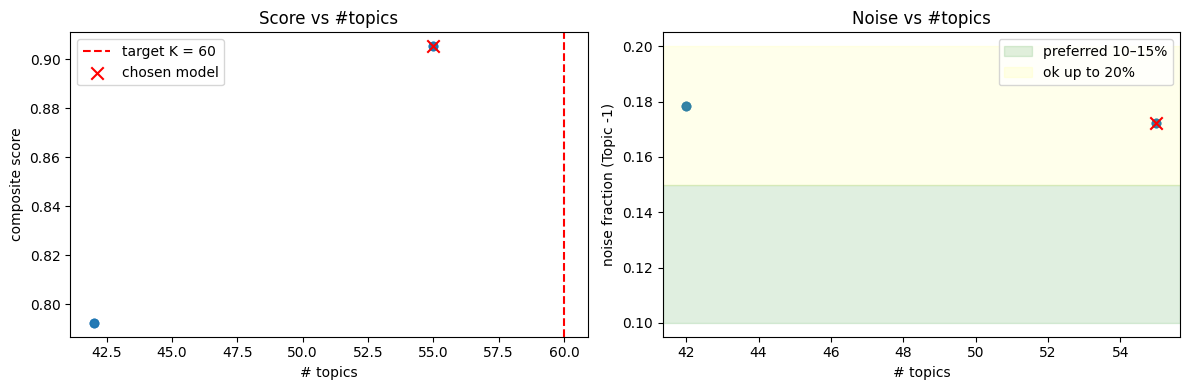

In [ ]:
# ---------------------------------------------------------------
# Visualize how we chose the best model
# ---------------------------------------------------------------
import matplotlib.pyplot as plt

# make sure res_df exists (from 7.3b)
# and best / desired_K exist
total_runs = len(res_df)

fig, ax = plt.subplots(1, 2, figsize=(12, 4))

# -----------------------------------------------------------
# (1) Score vs #topics  → which topic counts perform better?
# -----------------------------------------------------------
ax[0].scatter(res_df["n_topics"], res_df["score"], alpha=0.6)
ax[0].axvline(desired_K, color="red", linestyle="--", label=f"target K = {desired_K}")

# highlight chosen best
best_ntop = best["metrics"]["n_topics"]
best_score = best["score"]
ax[0].scatter([best_ntop], [best_score], color="red", s=80, marker="x", label="chosen model")

ax[0].set_xlabel("# topics")
ax[0].set_ylabel("composite score")
ax[0].set_title("Score vs #topics")
ax[0].legend()

# -----------------------------------------------------------
# (2) Noise vs #topics  → we wanted Topic −1 in a band
# -----------------------------------------------------------
ax[1].scatter(res_df["n_topics"], res_df["noise_frac"], alpha=0.6)

# show preferred noise band (your 0.10–0.15 / 0.10–0.20 idea)
ax[1].axhspan(0.10, 0.15, color="green", alpha=0.12, label="preferred 10–15%")
ax[1].axhspan(0.15, 0.20, color="yellow", alpha=0.08, label="ok up to 20%")

# highlight chosen best
ax[1].scatter([best_ntop], [best["metrics"]["noise_frac"]], color="red", s=80, marker="x")

ax[1].set_xlabel("# topics")
ax[1].set_ylabel("noise fraction (Topic -1)")
ax[1].set_title("Noise vs #topics")
ax[1].legend()

plt.tight_layout()
plt.show()


### 3.3e) (Optional) Leaf-mode refinement near best EOM

In [ ]:
# ---------------------------------------------------------------
# (Optional) Leaf-mode refinement near best EOM
# ---------------------------------------------------------------
if not RUN_LEAF:
    print("ℹ️ Skipping leaf refinement (RUN_LEAF=False).")
else:
    # ------------- your existing leaf code -------------
    print("\n[Leaf refinement] Starting from current best (eom).")
    start_noise = best["metrics"]["noise_frac"]
    start_cnpmi = best["metrics"]["c_npmi"]
    start_div   = best["metrics"]["diversity"]
    start_score = best["score"]

    # Acceptance constraints (tune if you like)
    MAX_NOISE   = 0.25        # don't accept leaf if Topic -1 > 25%
    MIN_COH     = max(0.0, (start_cnpmi if start_cnpmi is not None else 0) - 0.02)   # coherence must be within 0.02
    MIN_SCORE   = start_score - 0.05   # allow tiny tolerance
    TARGET_LOW, TARGET_HIGH = 0.10, 0.20  # we still prefer to stay in/near the band

    base_p   = best["params"]
    curr_nn  = base_p["umap"]["n_neighbors"]
    curr_mcs = base_p["hdb"]["min_cluster_size"]
    curr_ms  = base_p["hdb"]["min_samples"]
    curr_eps = base_p["hdb"].get("cluster_selection_epsilon", 0.0)

    # Build a tiny local neighborhood for 'leaf'
    cands = []
    mcs_opts = sorted(set([max(2, curr_mcs - 2), curr_mcs - 1, curr_mcs, curr_mcs + 1, curr_mcs + 2]))
    ms_opts  = sorted(set([max(1, curr_ms - 1), curr_ms, curr_ms + 1]))
    eps_opts = sorted(set([0.0, min(0.02, max(0.0, curr_eps)), 0.05]))  # small merging tolerance
    nn_opts  = sorted(set([max(5, curr_nn - 5), curr_nn, curr_nn + 5])) # small UMAP n_neighbors wiggle

    for mcs in mcs_opts:
        for ms in ms_opts:
            for eps in eps_opts:
                for nn in nn_opts:
                    p_leaf = {
                        "umap": {**base_p["umap"], "n_neighbors": nn},
                        "hdb":  {
                            **base_p["hdb"],
                            "cluster_selection_method": "leaf",          # switch to leaf
                            "min_cluster_size": mcs,
                            "min_samples": ms,
                            "cluster_selection_epsilon": eps,
                        },
                        "vec":  base_p["vec"],
                        "min_topic_size": base_p["min_topic_size"],
                    }
                    cands.append(p_leaf)

    def refit_and_eval(params):
        m = build_model(params["umap"], params["hdb"], params["vec"], params["min_topic_size"])
        t_try, pr_try = m.fit_transform(docs, embeddings=embeddings)
        met = evaluate(m, docs, top_n=10)

        # rebuild the same composite score you used (with noise band preference)
        noise_pen = max(0.0, met["noise_frac"] - 0.30)
        target_bonus = 1.0 - min(1.0, abs(met["n_topics"] - desired_K) / max(1, desired_K))
        base_score = (
            (1.0 * max(0, met["c_npmi"]))
            + (0.7 * (met["diversity"] / 100.0))
            - (0.8 * noise_pen)
            + (0.5 * target_bonus)
        )

        target_mid = 0.15 if (TARGET_LOW, TARGET_HIGH) == (0.10, 0.20) else (TARGET_LOW + TARGET_HIGH) / 2
        noise_band_pen = min(1.0, abs(met["noise_frac"] - target_mid) / target_mid)
        score = base_score - 0.25 * noise_band_pen
        return m, t_try, pr_try, met, score

    best_leaf = None
    for p in cands:
        m, t_try, pr_try, met, score = refit_and_eval(p)

        # Hard constraints first
        if met["noise_frac"] > MAX_NOISE:
            continue
        if met["c_npmi"] < MIN_COH:
            continue
        if score < MIN_SCORE:
            continue

        # Prefer in-band noise if possible
        in_band = (TARGET_LOW <= met["noise_frac"] <= TARGET_HIGH)

        if best_leaf is None:
            best_leaf = {
                "model": m,
                "topics": t_try,
                "probs": pr_try,
                "params": p,
                "metrics": met,
                "score": score,
                "in_band": in_band,
            }
        else:
            # rank: in-band first, then higher score
            if (in_band and not best_leaf["in_band"]) or (
                in_band == best_leaf["in_band"] and score > best_leaf["score"]
            ):
                best_leaf = {
                    "model": m,
                    "topics": t_try,
                    "probs": pr_try,
                    "params": p,
                    "metrics": met,
                    "score": score,
                    "in_band": in_band,
                }

    if best_leaf is not None:
        # adopt only if it's meaningfully competitive
        topic_model = best_leaf["model"]
        topics      = best_leaf["topics"]
        probs       = best_leaf["probs"]

        best["model"]   = topic_model
        best["topics"]  = topics
        best["probs"]   = probs
        best["params"]  = best_leaf["params"]
        best["metrics"] = best_leaf["metrics"]
        best["score"]   = best_leaf["score"]

        print(
            f"✅ Adopted 'leaf' refinement. "
            f"Noise: {best['metrics']['noise_frac']:.2%}, "
            f"c_npmi: {best['metrics']['c_npmi']:.3f}, "
            f"score: {best['score']:.3f}"
        )
    else:
        print("ℹ️ No 'leaf' candidate met the constraints; kept the 'eom' model.")


ℹ️ Skipping leaf refinement (RUN_LEAF=False).


In [ ]:
# ---------------------------------------------------------------
# Adopt the Best Model for Downstream Use
# ---------------------------------------------------------------

# Select the winning model (either best EOM or refined leaf)
topic_model = best["model"]
topics      = best["topics"]
probs       = best["probs"]

print("✅ Adopted best model for downstream analysis.")
print(f"   → Topics discovered : {best['metrics']['n_topics']}")
print(f"   → Noise fraction    : {best['metrics']['noise_frac']:.2%}")
print(f"   → Coherence (c_npmi): {best['metrics']['c_npmi']:.4f}")

✅ Adopted best model for downstream analysis.
   → Topics discovered : 55
   → Noise fraction    : 17.23%
   → Coherence (c_npmi): 0.0594


In [ ]:
# ---------------------------------------------------------------
# View Topics from the Adopted Model
# ---------------------------------------------------------------
topic_info = topic_model.get_topic_info()

print(f"📊 Found {len(topic_info) - 1} topics (excluding noise).")
print("   Top 10 topics by size:")
display(topic_info.head(10))

# Inspect top words for the largest topic (Topic 0)
print("\n🔍 Top words for Topic 0:")
print(topic_model.get_topic(0))

📊 Found 55 topics (excluding noise).
   Top 10 topics by size:


Topic  Count                                                     Name  \
0     -1    233                         -1_recidivism_offender_risk_need   
1      0    137                       0_crime_spatial_place_neighborhood   
2      1     59                         1_state_state crime_market_crime   
3      2     52       2_situationalactiontheory_morality_propensity_self   
4      3     40                   3_prison_pretrial_effect_incarceration   
5      4     34     4_think_criminal think_criminogenicthinking_criminal   
6      5     32                  5_parenting_delinquency_peer_adolescent   
7      6     29                               6_racial_race_black_ethnic   
8      7     28                 7_delinquency_school_family_relationship   
9      8     24  8_cyberbullye_cybercrime_online_situationalactiontheory   

                                                                                                                                Representation  \
0                                          [recidivism, offender, risk, need, treatment, assessment, justice, youth, criminogenicneed, sample]   
1                                                           [crime, spatial, place, neighborhood, street, robbery, pattern, area, block, city]   
2                                                   [state, state crime, market, crime, fraud, financial, tax, global, industry, criminogenic]   
3          [situationalactiontheory, morality, propensity, self, crime, crime propensity, exposure, moral, criminogenic exposure, interaction]   
4                        [prison, pretrial, effect, incarceration, imprisonment, detention, pretrial detention, misconduct, recidivism, match]   
5  [think, criminal think, criminogenicthinking, criminal, cognition, criminogenic cognition, scale, style, attitude, psychological inventory]   
6                                 [parenting, delinquency, peer, adolescent, delinquent, parental, criminogenic setting, spend, self, genetic]   
7                                     [racial, race, black, ethnic, socialization, neighborhood, discrimination, poverty, segregation, latino]   
8                                                   [delinquency, school, family, relationship, effect, label, desistance, self, peer, police]   
9          [cyberbullye, cybercrime, online, situationalactiontheory, self, propensity, theory, victimization, criminogenic exposure, digital]   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       


🔍 Top words for Topic 0:
[('crime', 0.03890413300070834), ('spatial', 0.027382794215206705), ('place', 0.02589570767821805), ('neighborhood', 0.022072256130318636), ('street', 0.020299986605453586), ('robbery', 0.018417852638903186), ('pattern', 0.016400566028805727), ('area', 0.015817376545274646), ('block', 0.015513337812378581), ('city', 0.014134603461074894)]


In [ ]:
# ---------------------------------------------------------------
# Build ALIASES automatically from your CONCEPT_PATTERNS
# ---------------------------------------------------------------
import re

# Set active model for this section
active_model = topic_model

# 1) Build ALIASES from existing CONCEPT_PATTERNS
ALIASES = {}
if "CONCEPT_PATTERNS" in globals():
    for pat, canon in CONCEPT_PATTERNS:
        canon_l = canon.lower()
        # map concatenated and underscored variants -> long form
        ALIASES[canon_l.replace(" ", "")] = canon_l                 # e.g., "situationalactiontheory"
        ALIASES[canon_l.replace(" ", "_")] = canon_l                # e.g., "situational_action_theory"
        # extract any acronyms from the regex (e.g., sat, rat, gst...)
        # (Simple heuristic to catch 2-8 letter words inside regex boundaries)
        for a in re.findall(r"\\b([a-z]{2,8})\\b", pat, flags=re.I):
            ALIASES[a.lower()] = canon_l
    print(f"✅ Built {len(ALIASES)} aliases from CONCEPT_PATTERNS.")
else:
    print("⚠️ CONCEPT_PATTERNS not found in memory. Aliases will be empty.")

# ---------------------------------------------------------------
# Minimal topic label cleaner (uses ALIASES, no phrase stitching)
# ---------------------------------------------------------------
def normalize_token(tok: str) -> str:
    t_raw = (tok or "").strip()
    if not t_raw:
        return ""
    t = t_raw.lower()
    t_nounder = t.replace("_", "")
    # alias lookup by (1) raw token, (2) no-underscore token
    if t in ALIASES:
        return ALIASES[t]
    if t_nounder in ALIASES:
        return ALIASES[t_nounder]
    # if underscored multiword, make it spaced
    if "_" in t:
        return t.replace("_", " ")
    return t

def clean_topic_label(words):
    seen, out = set(), []
    for w in words:
        if not isinstance(w, str) or not w.strip():
            continue
        norm = normalize_token(w)
        if norm and norm not in seen:
            seen.add(norm)
            out.append(norm)
    return " / ".join(w.title() for w in out)

# apply to your active model
topic_labels = {}
ti = active_model.get_topic_info()
for t in ti.Topic[ti.Topic != -1]:
    top_words = [w for w, _ in active_model.get_topic(t)[:5]]
    topic_labels[t] = clean_topic_label(top_words)

active_model.set_topic_labels(topic_labels)
print(f"✅ Applied {len(topic_labels)} cleaned labels from CONCEPT_PATTERNS.")

✅ Built 126 aliases from CONCEPT_PATTERNS.
✅ Applied 55 cleaned labels from CONCEPT_PATTERNS.


In [ ]:
# ---------------------------------------------------------------
# View Topics with Cleaned Labels
# ---------------------------------------------------------------
info_clean = active_model.get_topic_info()

# Map the computed labels from the previous step
info_clean["Cleaned_Label"] = info_clean["Topic"].map(topic_labels)

# Show top 15 topics (excluding noise if preferred, here showing all)
print("✨ Topics with cleaned labels:")
display(info_clean[["Topic", "Count", "Cleaned_Label", "Name"]].head(15))

✨ Topics with cleaned labels:


,Topic,Count,Cleaned_Label,Name
0,-1,233,NaN,-1_recidivism_offender_risk_need
1,0,137,Crime / Spatial / Place / Neighborhood / Street,0_crime_spatial_place_neighborhood
2,1,59,State / State Crime / Market / Crime / Fraud,1_state_state crime_market_crime
3,2,52,Situational Action Theory / Morality / Propensity / Self / Crime,2_situationalactiontheory_morality_propensity_self
4,3,40,Prison / Pretrial / Effect / Incarceration / Imprisonment,3_prison_pretrial_effect_incarceration
5,4,34,Think / Criminal Think / Criminogenic Thinking / Criminal / Cognition,4_think_criminal think_criminogenicthinking_criminal
6,5,32,Parenting / Delinquency / Peer / Adolescent / Delinquent,5_parenting_delinquency_peer_adolescent
7,6,29,Racial / Race / Black / Ethnic / Socialization,6_racial_race_black_ethnic
8,7,28,Delinquency / School / Family / Relationship / Effect,7_delinquency_school_family_relationship
9,8,24,Cyberbullye / Cybercrime / Online / Situational Action Theory / Self,8_cyberbullye_cybercrime_online_situationalactiontheory


In [ ]:
# ---------------------------------------------------------------
# AI Topic Labeling (OpenAI)
# ---------------------------------------------------------------
import pandas as pd
import json
from tqdm.auto import tqdm
from typing import Dict, Union, List

# 1. Define the Labeling Function
def label_topic_openai(topic_id, model, df_docs, text_col="__clean__"):
    """Generates a short label and rationale for a topic using OpenAI."""

    if topic_id == -1:
        return "Uncategorized", "Noise topic containing diverse documents."

    # Get top keywords
    keywords = [w for w, _ in model.get_topic(topic_id)[:10]]

    # Get representative documents
    rep_docs = df_docs.loc[df_docs['topic_id'] == topic_id, text_col].head(3).tolist()
    docs_text = "\n\n".join([d[:500] + "..." for d in rep_docs]) # Truncate for context window

    prompt = f"""
    You are a domain expert. Label this topic based on its keywords and documents.

    Keywords: {', '.join(keywords)}

    Documents:
    {docs_text}

    Return a JSON with:
    - "label": A short, descriptive topic name (max 5-7 words).
    - "rationale": A 1-sentence explanation.
    """

    try:
        response = client.chat.completions.create(
            model="gpt-4o",
            messages=[{"role": "user", "content": prompt}],
            temperature=0.0,
            response_format={"type": "json_object"}
        )
        content = json.loads(response.choices[0].message.content)
        return content.get("label", f"Topic {topic_id}"), content.get("rationale", "")
    except Exception as e:
        print(f"Error labeling Topic {topic_id}: {e}")
        return f"Topic {topic_id}", "Error generating label"

# 2. Run Batch Labeling
print("🤖 Starting AI Labeling...")

# Ensure topic IDs are present in dataframe
df_topics_run = df.copy()
if "topic_id" not in df_topics_run.columns:
    df_topics_run["topic_id"] = topics

# Get list of topics (excluding noise)
topic_info = topic_model.get_topic_info()
target_topics = [t for t in topic_info['Topic'] if t != -1]

ai_results = []
for tid in tqdm(target_topics, desc="Labeling Topics"):
    lbl, rat = label_topic_openai(tid, topic_model, df_topics_run)
    ai_results.append({"topic_id": tid, "ai_label": lbl, "ai_rationale": rat})

# 3. Save Results
labels_df = pd.DataFrame(ai_results)
print(f"\n✅ Labeled {len(labels_df)} topics.")
display(labels_df.head(10))

🤖 Starting AI Labeling...


Labeling Topics:   0%|          | 0/55 [00:00<?, ?it/s]


✅ Labeled 55 topics.


,topic_id,ai_label,ai_rationale
0,0,Urban Crime Patterns and Spatial Analysis,"The keywords and documents focus on the spatial and environmental factors influencing crime patterns in urban areas, particularly through the analysis of neighborhood dynamics and mobility data."
1,1,State-Corporate Financial and Environmental Crimes,"The documents and keywords collectively highlight issues of state and corporate involvement in financial fraud, tax evasion, and environmental harm, emphasizing the criminogenic nature of these activities on a global scale."
2,2,Situational Action Theory in Criminology,"The documents and keywords focus on the interaction between individual crime propensity, morality, and criminogenic exposure as explained by situational action theory."
3,3,Effects of Pretrial Detention and Incarceration,"The documents and keywords focus on the impacts of pretrial detention and incarceration, including recidivism, parole, and criminogenic effects."
4,4,Criminogenic Cognitions and Thinking Styles,"The documents and keywords focus on the psychological evaluation and measurement of criminal thinking patterns and attitudes, particularly in incarcerated individuals."
5,5,Parental Influence on Adolescent Delinquency,"The documents and keywords focus on the impact of parental behavior and relationships on adolescent delinquency, highlighting factors like parental hostility, support, and peer influence."
6,6,"Race, Ethnicity, and Crime Dynamics","The keywords and documents focus on the intersection of race, ethnicity, and socio-economic factors with crime and legal system involvement, particularly among minority groups like Black and Latino communities."
7,7,Impact of Labeling on Youth Delinquency,"The documents and keywords focus on how labeling, particularly through school discipline and justice system contact, influences delinquency in youth, with considerations of self-control and family dynamics."
8,8,Cybercrime and Cyberbullying Dynamics,"The keywords and documents focus on the factors, differences, and influences related to cybercrime and cyberbullying, including individual and group behaviors, risk factors, and gender differences."
9,9,Offender Personality Disorder Treatment,"The documents and keywords focus on treatment programs and interventions for offenders with personality disorders, emphasizing therapeutic needs and criminogenic factors."


In [ ]:
# ---------------------------------------------------------------
# View AI-Labeled Topics with Counts
# ---------------------------------------------------------------

# Get base topic info (Counts, etc.)
info = topic_model.get_topic_info()

# Check if labels_df exists from the previous step
if "labels_df" in globals():
    # Prepare for merge
    info_view = info.copy()
    info_view["Topic"] = info_view["Topic"].astype(int)
    labels_df["topic_id"] = labels_df["topic_id"].astype(int)

    # Merge AI labels into the main topic info
    info_view = info_view.merge(labels_df, left_on="Topic", right_on="topic_id", how="left")

    # Fill NaNs for Noise (Topic -1) if not labeled
    info_view["ai_label"] = info_view["ai_label"].fillna("Uncategorized / Noise")
    info_view["ai_rationale"] = info_view["ai_rationale"].fillna("-")

    # Display Top 20 Topics
    print("✨ Top 20 Topics with AI Labels:")
    display(info_view[["Topic", "Count", "ai_label", "ai_rationale"]].head(20))
else:
    print("⚠️ 'labels_df' not found. Please run the AI labeling cell above first.")

✨ Top 20 Topics with AI Labels:


,Topic,Count,ai_label,ai_rationale
0,-1,233,Uncategorized / Noise,-
1,0,137,Urban Crime Patterns and Spatial Analysis,"The keywords and documents focus on the spatial and environmental factors influencing crime patterns in urban areas, particularly through the analysis of neighborhood dynamics and mobility data."
2,1,59,State-Corporate Financial and Environmental Crimes,"The documents and keywords collectively highlight issues of state and corporate involvement in financial fraud, tax evasion, and environmental harm, emphasizing the criminogenic nature of these activities on a global scale."
3,2,52,Situational Action Theory in Criminology,"The documents and keywords focus on the interaction between individual crime propensity, morality, and criminogenic exposure as explained by situational action theory."
4,3,40,Effects of Pretrial Detention and Incarceration,"The documents and keywords focus on the impacts of pretrial detention and incarceration, including recidivism, parole, and criminogenic effects."
5,4,34,Criminogenic Cognitions and Thinking Styles,"The documents and keywords focus on the psychological evaluation and measurement of criminal thinking patterns and attitudes, particularly in incarcerated individuals."
6,5,32,Parental Influence on Adolescent Delinquency,"The documents and keywords focus on the impact of parental behavior and relationships on adolescent delinquency, highlighting factors like parental hostility, support, and peer influence."
7,6,29,"Race, Ethnicity, and Crime Dynamics","The keywords and documents focus on the intersection of race, ethnicity, and socio-economic factors with crime and legal system involvement, particularly among minority groups like Black and Latino communities."
8,7,28,Impact of Labeling on Youth Delinquency,"The documents and keywords focus on how labeling, particularly through school discipline and justice system contact, influences delinquency in youth, with considerations of self-control and family dynamics."
9,8,24,Cybercrime and Cyberbullying Dynamics,"The keywords and documents focus on the factors, differences, and influences related to cybercrime and cyberbullying, including individual and group behaviors, risk factors, and gender differences."


# Section 4: Topic Interpretation

## 3.1) EST Tagging

In [ ]:
# 0) Compile EST patterns → regex
import re

def _to_regex_list(tokens):
    rx = []
    for t in tokens:
        pat = re.escape(t).replace("\\*", r"[a-z_]*")  # wildcard support like impulsiv*
        rx.append(re.compile(rf"\b{pat}\b", flags=re.IGNORECASE))
    return rx

assert "EST_PATTERNS" in globals(), "Define EST_PATTERNS first."
EST_REGEX = {k: _to_regex_list(v) for k, v in EST_PATTERNS.items()}
print("✅ EST patterns compiled:", {k: len(v) for k, v in EST_REGEX.items()})


✅ EST patterns compiled: {'Micro': 33, 'Meso': 35, 'Macro': 41}


In [ ]:
# ---------------------------------------------------------------
# Define EST_PATTERNS for Ecological Systems Theory Tagging
# ---------------------------------------------------------------
EST_PATTERNS = {
    "Micro": [
        # Individual traits, psychology, biology, risk
        "impulsiv*", "self_control", "moral*", "cognit*", "psycholog*", "personality",
        "mental_health", "mental_illness", "trauma", "ptsd", "tbi", "brain_injury",
        "substance_use", "drug_use", "alcohol", "addict*", "genetic*", "biologic*",
        "neuro*", "individual", "offender", "victim*", "attitude", "belief",
        "decision", "choice", "routine_activity", "risk_perception", "fear_of_crime",
        "criminal_thinking", "criminogenic_thinking", "propensity", "self_efficacy"
    ],
    "Meso": [
        # Community, institutions, immediate social groups
        "family", "parent*", "peer*", "gang", "school", "teacher", "classroom",
        "workplace", "employ*", "neighbor*", "neighbour*", "community", "local",
        "prison", "jail", "correction*", "probation", "parole", "police", "polic*",
        "court", "justice_system", "rehabilitation", "program", "treatment",
        "service", "agency", "organization", "institution", "case_management",
        "social_network", "relationship", "interaction", "group_home", "shelter"
    ],
    "Macro": [
        # Societal, structural, cultural, policy
        "policy", "policies", "law", "legal", "legislat*", "govern*", "state",
        "nation*", "internation*", "global", "society", "societal", "structur*",
        "econom*", "inequality", "poverty", "disadvantage", "deprivation",
        "segregation", "discriminat*", "racis*", "culture", "cultural", "norm*",
        "capitalis*", "neoliberal*", "politic*", "democracy", "welfare",
        "migration", "immigration", "urban", "rural", "environment*", "geograph*",
        "spatial", "hot_spot", "trend", "rate", "statistic*", "epidemiolog*"
    ]
}

print("✅ Defined EST_PATTERNS for Micro, Meso, and Macro layers.")

✅ Defined EST_PATTERNS for Micro, Meso, and Macro layers.


In [ ]:
# ---------------------------------------------------------------
# 4.1 Run Full EST Tagging Pipeline (Consolidated)
# ---------------------------------------------------------------
import re
import pandas as pd
from collections import defaultdict, Counter

# 1. Check patterns
if "EST_PATTERNS" not in globals():
    raise ValueError("⚠️ EST_PATTERNS not found. Please run the 'Define EST_PATTERNS' cell first.")

# 2. Compile Regex
print("⚙️ Compiling EST regex patterns...")
EST_REGEX = {}
for level, tokens in EST_PATTERNS.items():
    # escaped patterns, handling * wildcards
    patterns = []
    for t in tokens:
        pat = re.escape(t).replace("\\*", r"[a-z_]*")
        patterns.append(re.compile(rf"\b{pat}\b", flags=re.IGNORECASE))
    EST_REGEX[level] = patterns
print(f"   Micro: {len(EST_REGEX['Micro'])}, Meso: {len(EST_REGEX['Meso'])}, Macro: {len(EST_REGEX['Macro'])}")

# 3. Tagging Function
def get_est_tags(text):
    if not isinstance(text, str) or not text:
        return "Unclassified", {}

    hits = Counter()
    for level, regex_list in EST_REGEX.items():
        for rx in regex_list:
            if rx.search(text):
                hits[level] += 1

    if not hits:
        return "Unclassified", dict(hits)

    # Determine Primary: Max hits, tie-break Macro > Meso > Micro
    # Sort keys by (-count, priority_index)
    priority = ["Macro", "Meso", "Micro"]

    # helper to get sort key
    def sort_key(k):
        return (-hits[k], priority.index(k) if k in priority else 99)

    primary = sorted(hits.keys(), key=sort_key)[0]
    return primary, dict(hits)

# 4. Apply to Docs
print("🚀 Tagging documents...")
# Use vectorizer text for best matching (lemmatized/underscored) or clean text
text_col = "__vectorizer_text__" if "__vectorizer_text__" in df.columns else "__clean__"
print(f"   Using column: {text_col}")

est_results = df[text_col].apply(get_est_tags)
df["EST_Primary"] = [x[0] for x in est_results]

# 5. Aggregate to Topics
print("📊 Aggregating to Topics...")
# Ensure we have topic_id
if "topic_id" not in df.columns:
    df["topic_id"] = topics

# Create pivot table of counts
topic_est = df[df["topic_id"] != -1].groupby("topic_id")["EST_Primary"].value_counts().unstack(fill_value=0)

# Ensure all columns exist
for col in ["Macro", "Meso", "Micro", "Unclassified"]:
    if col not in topic_est.columns:
        topic_est[col] = 0

# Calculate Total Docs per topic
topic_est["Total_Docs"] = topic_est[["Macro", "Meso", "Micro", "Unclassified"]].sum(axis=1)

# Calculate dominant EST and share
dominant_est = []
est_shares = []

for tid in topic_est.index:
    row = topic_est.loc[tid]
    total = row["Total_Docs"]
    if total == 0:
        dominant_est.append("Unclassified")
        est_shares.append(0.0)
    else:
        # Exclude Total_Docs from max finding
        counts = row[["Macro", "Meso", "Micro", "Unclassified"]]
        dom = counts.idxmax()
        dominant_est.append(dom)
        est_shares.append(counts[dom] / total)

topic_est_summary = pd.DataFrame({
    "topic_id": topic_est.index,
    "Regex_EST_Primary": dominant_est,
    "Regex_EST_Share": est_shares,
    "Total_Docs": topic_est["Total_Docs"].values,
    "Count_Macro": topic_est["Macro"].values,
    "Count_Meso": topic_est["Meso"].values,
    "Count_Micro": topic_est["Micro"].values,
    "Count_Unclassified": topic_est["Unclassified"].values
})

# 6. Merge with existing info
# Merge into a master summary if possible, or display separately
if "labels_df" in globals():
    # Compare with AI
    comparison = labels_df.merge(topic_est_summary, on="topic_id", how="left")
    print("\n🔎 Topic EST Classification (AI vs Regex):")

    # Define columns to show
    cols = ["topic_id", "ai_label", "Total_Docs", "Regex_EST_Primary", "Regex_EST_Share",
            "Count_Macro", "Count_Meso", "Count_Micro"]

    if "ai_ecolayer" in comparison.columns:
        cols.insert(2, "ai_ecolayer")

    display(comparison[cols].head(15))
else:
    print("\n🔎 Topic EST Classification (Regex):")
    cols = ["topic_id", "Total_Docs", "Regex_EST_Primary", "Regex_EST_Share",
            "Count_Macro", "Count_Meso", "Count_Micro"]
    display(topic_est_summary[cols].head(15))

print("\n✅ EST Tagging Complete. 'EST_Primary' column added to df.")

⚙️ Compiling EST regex patterns...
   Micro: 33, Meso: 35, Macro: 41
🚀 Tagging documents...
   Using column: __vectorizer_text__
📊 Aggregating to Topics...

🔎 Topic EST Classification (AI vs Regex):


,topic_id,ai_label,Total_Docs,Regex_EST_Primary,Regex_EST_Share,Count_Macro,Count_Meso,Count_Micro
0,0,Urban Crime Patterns and Spatial Analysis,137,Macro,0.678832,93,39,5
1,1,State-Corporate Financial and Environmental Crimes,59,Macro,0.881356,52,6,0
2,2,Situational Action Theory in Criminology,52,Micro,0.461538,12,16,24
3,3,Effects of Pretrial Detention and Incarceration,40,Meso,0.675000,13,27,0
4,4,Criminogenic Cognitions and Thinking Styles,34,Micro,0.882353,1,3,30
5,5,Parental Influence on Adolescent Delinquency,32,Meso,0.718750,8,23,1
6,6,"Race, Ethnicity, and Crime Dynamics",29,Macro,0.896552,26,1,2
7,7,Impact of Labeling on Youth Delinquency,28,Meso,0.607143,8,17,3
8,8,Cybercrime and Cyberbullying Dynamics,24,Micro,0.458333,3,9,11
9,9,Offender Personality Disorder Treatment,24,Meso,0.791667,1,19,4



✅ EST Tagging Complete. 'EST_Primary' column added to df.


## 3.2) AI Topic Interpretation

In [ ]:
# ---------------------------------------------------------------
# GPT Labeller (dual): Topic Name + Ecological Layer (Macro/Meso/Micro)
#   - Robust to topic_labels being dict / list / Series / DataFrame
# ---------------------------------------------------------------
from typing import Dict, List, Union
import json, re
import numpy as np
import pandas as pd
from bertopic import BERTopic

ECO_DEFS = {
    "Macro": "Societal/structural systems: policy, economy, migration, inequality, spatial structure, law, governance.",
    "Meso":  "Community/institutional/organizational: neighbourhoods, schools, prisons, policing, programs, services.",
    "Micro": "Individual/interpersonal: psychology, cognition, trauma, risk, peers, family, identities."
}

def _guess_ecolayer_from_terms(terms: List[str]) -> str:
    # Fallback heuristics if API unavailable
    MACRO_HINTS = {"policy","policies","law","laws","governance","country","national","macro",
                   "immigration","welfare","econom","poverty","segregation","inequality",
                   "neighbourhood","neighborhood","spatial","city","urban","place","street","security"}
    MESO_HINTS  = {"institution","school","education","classroom","prison","correction","program",
                   "rehabilitation","treatment","policing","agency","organization","organisational",
                   "neighbourhood","neighborhood","community","service","case management"}
    MICRO_HINTS = {"cognition","cognitive","decision","impuls","moral","trauma","ptsd","tbi","mental",
                   "peer","family","identity","label","addiction","substance","offender","individual","attitude"}

    tset = {t.lower() for t in terms}
    def score(hints): return sum(any(h in tok for h in hints) for tok in tset)
    s_macro, s_meso, s_micro = score(MACRO_HINTS), score(MESO_HINTS), score(MICRO_HINTS)
    m = max(s_macro, s_meso, s_micro)
    if m == 0: return "Macro"  # conservative default
    return ["Macro","Meso","Micro"][[s_macro, s_meso, s_micro].index(m)]

def _coerce_labels_map(topic_labels: Union[None, Dict[int,str], List[str], pd.Series, pd.DataFrame], model: BERTopic) -> Dict[int, str]:
    info = model.get_topic_info()
    base = dict(zip(info["Topic"].astype(int), info["Name"].astype(str)))

    if topic_labels is None:
        return base
    if isinstance(topic_labels, dict):
        base.update({int(k): str(v) for k, v in topic_labels.items()})
        return base
    if isinstance(topic_labels, (list, pd.Series, np.ndarray)):
        # enumerate fallback
        for i, v in enumerate(topic_labels):
            base[int(i)] = str(v)
        return base
    return base

def gpt_label_topic_dual(
    topic_id: int,
    model: BERTopic,
    df_with_topics: pd.DataFrame,
    text_col: str = "__clean__",
    k: int = 10,
    n_docs: int = 3,
    topic_labels: Union[None, Dict[int,str], List[str], pd.Series, pd.DataFrame] = None,
) -> Dict[str, str]:
    # 1) Noise topic
    if topic_id == -1:
        return {
            "ai_label": "Uncategorized",
            "ai_ecolayer": "Macro",
            "ai_rationale": "Topic −1 contains documents that the model could not cluster confidently."
        }

    # 2) Top-k terms
    topic_terms = model.get_topic(topic_id) or []
    terms = [w for w, _ in topic_terms[:k]]

    # 3) Representative docs
    topic_docs = (
        df_with_topics.loc[df_with_topics["topic_id"] == topic_id, text_col]
        .dropna().astype(str).tolist()
    )
    sample_texts = topic_docs[:n_docs]
    docs_joined = "\n\n---\n\n".join(sample_texts)

    # 4) Cleaned label hint
    labels_map = _coerce_labels_map(topic_labels, model)
    clean_hint = labels_map.get(int(topic_id), "")

    # 5) JSON-only prompt
    prompt = f"""
You are a criminology expert labelling topics from a BERTopic model of academic articles.
The corpus spans crime, criminology, policing, social policy, justice, and AI.

You will receive:
- Top keywords (c-TF-IDF) for a topic
- A few representative article excerpts (cleaned title+abstract)
- An optional existing cleaned label (hint)

TASK:
1) Propose ONE concise, specific, human-readable label for this topic (max 7 words).
2) Assign ONE ecological layer from this set exactly: ["Macro","Meso","Micro"].
   - Macro = {ECO_DEFS["Macro"]}
   - Meso  = {ECO_DEFS["Meso"]}
   - Micro = {ECO_DEFS["Micro"]}
3) Provide 1–2 sentences justifying the label and ecological choice using the terms and excerpts.

REPLY STRICTLY AS MINIFIED JSON with keys:
{{
  "ai_label": "...",
  "ai_ecolayer": "Macro|Meso|Micro",
  "ai_rationale": "..."
}}

ExistingCleanLabelHint: "{clean_hint}"
TopTerms: {', '.join(terms)}
RepresentativeDocs:
{docs_joined}
""".strip()

    # 6) Call GPT (using 'client' from setup)
    ai_label, ai_ecolayer, ai_rationale = None, None, None

    # Check for 'client' (standard) or 'openai_client' (legacy)
    active_client = None
    if "client" in globals() and client is not None:
        active_client = client
    elif "openai_client" in globals() and openai_client is not None:
        active_client = openai_client

    if active_client:
        try:
            resp = active_client.chat.completions.create(
                model="gpt-4o",
                messages=[{"role": "user", "content": prompt}],
                temperature=0.2,
                response_format={"type": "json_object"},
            )
            txt = resp.choices[0].message.content.strip()
            obj = json.loads(txt)
            ai_label     = (obj.get("ai_label") or "").strip()
            ai_ecolayer  = (obj.get("ai_ecolayer") or "").strip().title()
            ai_rationale = (obj.get("ai_rationale") or "").strip()
        except Exception as e:
            print(f"[warn] OpenAI error on topic {topic_id}: {e}")

    # 7) Fallbacks
    if not ai_label:
        ai_label = " / ".join(terms[:3]).title() if terms else f"Topic {topic_id}"
    if ai_ecolayer not in {"Macro","Meso","Micro"}:
        ai_ecolayer = _guess_ecolayer_from_terms(terms)
    if not ai_rationale:
        ai_rationale = (
            f"Heuristic: labelled from top terms ({', '.join(terms[:k])}); "
            f"ecolayer guessed as {ai_ecolayer} based on keyword cues."
        )

    return {
        "ai_label": ai_label,
        "ai_ecolayer": ai_ecolayer,
        "ai_rationale": ai_rationale
    }

## 3.3) Generate Labels for All Non-Noise Topics

In [ ]:
# ---------------------------------------------------------------
# Batch: label all real topics (excl. -1) with AI Name + Eco Layer
# ---------------------------------------------------------------
import pandas as pd
from tqdm.auto import tqdm

# ⚙️ Fix: Use 'active_model' directly since 'best' variable is corrupted (is a string)
topic_model   = active_model
df_topics_all = df.copy()

# Attach current topic assignments if missing
if "topic_id" not in df_topics_all.columns:
    # Using 'topics' variable from the Adoption step
    df_topics_all["topic_id"] = pd.Series(topics, index=df.index)

# Topic set (exclude -1)
info = topic_model.get_topic_info()
topic_ids = [int(tid) for tid in info.Topic if int(tid) != -1]

# Optional cleaned-label hints: pass whatever you have (dict/list/Series/DataFrame/None)
try:
    _labels_hint = topic_labels  # may be dict or list — helper will coerce
except NameError:
    _labels_hint = None

rows = []
for tid in tqdm(topic_ids, desc="AI labelling (Name + Ecological Layer)"):
    out = gpt_label_topic_dual(
        topic_id=tid,
        model=topic_model,
        df_with_topics=df_topics_all,
        text_col="__clean__",     # cleaned combined text
        k=10,
        n_docs=3,
        topic_labels=_labels_hint # can be dict/list/Series/DF/None
    )
    rows.append({
        "topic_id": tid,
        "ai_label": out["ai_label"],
        "ai_ecolayer": out["ai_ecolayer"],
        "ai_rationale": out["ai_rationale"],
    })

labels_df = (
    pd.DataFrame(rows)
      .sort_values("topic_id")
      .reset_index(drop=True)
)

print(f"✅ Labeled {len(labels_df)} topics.")
display(labels_df.head(15))

AI labelling (Name + Ecological Layer):   0%|          | 0/55 [00:00<?, ?it/s]

✅ Labeled 55 topics.


,topic_id,ai_label,ai_ecolayer,ai_rationale
0,0,Crime Patterns in Urban Environments,Meso,"The topic focuses on the spatial and temporal dynamics of crime in urban settings, as evidenced by keywords like 'spatial,' 'place,' 'neighborhood,' and 'street,' and the representative documents discussing crime patterns, dynamic places, and population mobility. The meso layer is appropriate as it involves community and neighborhood-level analysis, examining how crime is influenced by the movement and interaction of people within urban areas."
1,1,State-Corporate Crime and Economic Exploitation,Macro,"The topic focuses on the intersection of state and corporate actions that lead to systemic economic exploitation and crime, as evidenced by the use of programs like the PPP to reinforce power structures and the role of corporations in perpetuating harm. The emphasis on state-corporate crime, colonialism, and economic policies situates this topic within the macro ecological layer, as it involves societal and structural systems impacting global and national economies."
2,2,Situational Action Theory and Crime Propensity,Micro,"The topic focuses on the interplay between individual factors such as personal morality, self-control, and crime propensity, as explained by Situational Action Theory. The emphasis on individual-level interactions and psychological constructs like self-control and morality aligns with the Micro ecological layer, which pertains to individual and interpersonal dynamics."
3,3,Effects of Pretrial Detention and Incarceration,Meso,"The topic focuses on the effects of pretrial detention and incarceration, particularly in institutional settings like jails and prisons. The excerpts discuss the impact of solitary confinement and pretrial detention on recidivism and public safety, highlighting the role of institutional practices and policies. This aligns with the 'Meso' ecological layer, which involves community and institutional dynamics."
4,4,Criminogenic Cognitions and Criminal Thinking,Micro,"The topic revolves around the psychological aspects of criminal behavior, specifically focusing on criminogenic cognitions and criminal thinking styles. The excerpts discuss the psychometric evaluation of criminogenic cognition scales, the relationship between cognitive factors like future time orientation and criminal thinking, and the influence of negative affectivity on criminogenic thinking. These elements pertain to individual psychological processes, thus fitting within the Micro ecological layer."
5,5,Parenting Influence on Adolescent Delinquency,Micro,"The topic focuses on the individual and interpersonal dynamics between parents and adolescents, specifically how parental behavior and relationships influence adolescent delinquency. The excerpts discuss parental hostility, support, and the parent-adolescent relationship as factors affecting youth offending, aligning with the 'Micro' ecological layer which pertains to individual and interpersonal factors."
6,6,Racial and Ethnic Disparities in Crime,Macro,"The topic focuses on the societal and structural aspects of racial and ethnic disparities in crime, as evidenced by the emphasis on racial categories, discrimination, and economic inequality. The excerpts discuss how race and ethnicity influence crime patterns and legal system involvement, highlighting macro-level factors such as immigration policies, economic inequality, and racialization processes that affect entire communities and societal structures."
7,7,Labeling Effects on Youth Delinquency,Micro,"The topic focuses on the impact of labeling, such as school suspensions and justice system contact, on youth delinquency, highlighting individual-level factors like self-control and childhood maltreatment. The emphasis on personal experiences and psychological responses to labeling aligns with the Micro ecological layer, as it pertains to individual and interpersonal dynamics."
8,8,Cybercrime Offending and Victimization Dynamics,Mic

## 3.4) Save as Final Excel

In [ ]:
# Install xlsxwriter if not already installed
!pip install xlsxwriter

In [ ]:
# ---------------------------------------------------------------
# Export Comprehensive Results to Excel
#   • Sheet "Topics": ID, Count, Keywords, AI Label, AI Rationale, EST Layer
#   • Sheet "Docs":   Article ID, Title, Assigned Topic, EST Tag, Probability
# ---------------------------------------------------------------
import pandas as pd

# 1. Prepare Topics DataFrame
print("📊 Preparing Topics Sheet...")
topics_df = topic_model.get_topic_info().copy()

# Merge AI Labels if available
if "labels_df" in globals():
    # labels_df has [topic_id, ai_label, ai_rationale, ai_ecolayer]
    topics_df = topics_df.merge(labels_df, left_on="Topic", right_on="topic_id", how="left")
    topics_df.drop(columns=["topic_id"], inplace=True, errors="ignore")

# Merge EST Tags (from topic_est_summary) if available
if "topic_est_summary" in globals():
    topics_df = topics_df.merge(
        topic_est_summary[["topic_id", "Regex_EST_Primary", "Regex_EST_Share"]],
        left_on="Topic",
        right_on="topic_id",
        how="left"
    )
    topics_df.drop(columns=["topic_id"], inplace=True, errors="ignore")

# Clean up column names
topics_df.rename(columns={
    "Topic": "Topic_ID",
    "Count": "Doc_Count",
    "Name": "Original_Name",
    "ai_label": "AI_Label",
    "ai_rationale": "AI_Rationale",
    "ai_ecolayer": "AI_Eco_Layer",
    "Regex_EST_Primary": "EST_Tag_Primary",
    "Regex_EST_Share": "EST_Tag_Share"
}, inplace=True)

# Reorder columns for readability
kb_cols = ["Topic_ID", "Doc_Count", "AI_Label", "EST_Tag_Primary", "AI_Rationale", "Original_Name"]
avail_cols = [c for c in kb_cols if c in topics_df.columns] + [c for c in topics_df.columns if c not in kb_cols]
topics_df = topics_df[avail_cols]


# 2. Prepare Documents DataFrame
print("📄 Preparing Documents Sheet...")
docs_export = df.copy()

# Ensure Topic ID is attached
if "topic_id" not in docs_export.columns:
    docs_export["topic_id"] = topics

# Add Topic Name/Label map
topic_label_map = topics_df.set_index("Topic_ID")["AI_Label"].to_dict() if "AI_Label" in topics_df.columns else {}
docs_export["Topic_Label"] = docs_export["topic_id"].map(topic_label_map).fillna("Uncategorized")

# Select useful columns
# Adjust these column names based on your actual csv structure
candidates = ["id", "unique_id", "title", "abstract", "year", "topic_id", "Topic_Label", "topic_prob", "EST_Primary", "__clean__"]
final_cols = [c for c in candidates if c in docs_export.columns]
docs_export = docs_export[final_cols]


# 3. Write to Excel
out_path = "bertopic_results_comprehensive.xlsx"
print(f"💾 Saving to {out_path}...")

with pd.ExcelWriter(out_path, engine="xlsxwriter") as writer:
    # Write sheets
    topics_df.to_excel(writer, sheet_name="Topics", index=False)
    docs_export.to_excel(writer, sheet_name="Docs", index=False)

    # Auto-adjust column widths
    for sheetname, dframe in {"Topics": topics_df, "Docs": docs_export}.items():
        worksheet = writer.sheets[sheetname]
        for idx, col in enumerate(dframe.columns):
            max_len = min(50, max(10, dframe[col].astype(str).map(len).max()))
            worksheet.set_column(idx, idx, max_len)

print("✅ Export complete!")

📊 Preparing Topics Sheet...
📄 Preparing Documents Sheet...
💾 Saving to bertopic_results_comprehensive.xlsx...
✅ Export complete!


# Section 14: Semantic Search

Use the embedding model (SPECTER2) to find articles that are semantically similar to your query.
This goes beyond keyword matching and finds conceptual matches.

**How it works:**
1.  We embed your query using the same transformer model used for the articles.
2.  We calculate the cosine similarity between your query vector and all article vectors.
3.  We return the top matching results.

In [ ]:
# ---------------------------------------------------------------
# 14.1 Semantic Search Tool
# ---------------------------------------------------------------
import torch
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity

# Ensure model/tokenizer are loaded (from Section 2)
if "model" not in globals() or "tokenizer" not in globals():
    print("⚠️ Model/Tokenizer not found. Reloading SPECTER2...")
    from transformers import AutoTokenizer, AutoModel
    MODEL_NAME = "allenai/specter2_aug2023refresh_base"
    tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
    model = AutoModel.from_pretrained(MODEL_NAME).to("cuda" if torch.cuda.is_available() else "cpu")

def search_articles(query, top_k=5):
    """Finds articles semantically similar to the query string."""
    device = model.device
    model.eval()

    # 1. Embed the query
    inputs = tokenizer(
        [query],
        padding=True,
        truncation=True,
        max_length=512,
        return_tensors="pt"
    ).to(device)

    with torch.no_grad():
        output = model(**inputs)
        # Mean pooling
        last_hidden = output.last_hidden_state
        attention = inputs["attention_mask"].unsqueeze(-1)
        embedding = (last_hidden * attention).sum(dim=1) / attention.sum(dim=1)
        # Normalize
        embedding = embedding.cpu().numpy()
        embedding = embedding / np.linalg.norm(embedding, axis=1, keepdims=True)

    # 2. Calculate Similarity
    # 'embeddings' is the global matrix from Section 2
    sims = cosine_similarity(embedding, embeddings).flatten()

    # 3. Retrieve Top K
    top_indices = sims.argsort()[::-1][:top_k]

    results = []
    for idx in top_indices:
        # Use df_topics_all if available for rich info, else df
        source_df = df_topics_all if "df_topics_all" in globals() else df
        row = source_df.iloc[idx]

        results.append({
            "Score": f"{sims[idx]:.4f}",
            "Topic": f"{row.get('topic_id', 'N/A')}: {row.get('ai_label', 'N/A')}",
            "Title": row.get("title", "No Title"),
            "Abstract": str(row.get("abstract", ""))[:200] + "..."
        })

    return pd.DataFrame(results)

# --- Interactive Example ---
query = "machine learning for risk assessment"
print(f"🔎 Searching for: '{query}'")
display(search_articles(query, top_k=5))

🔎 Searching for: 'machine learning for risk assessment'


,Score,Topic,Title,Abstract
0,0.9001,20: N/A,Needle in a Haystack Logical Parameters of Treatment Based on Actuarial Risk-Needs Assessments,nan...
1,0.8795,20: N/A,The Application of Machine Learning to a General Risk-Need Assessment Instrument in the Prediction of Criminal Recidivism,The Level of Service/Case Management Inventory (LS/CMI) is one of the most frequently used tools to assess criminogenic risk-need in justice-involved individuals. Meta-analytic research demonstrat...
2,0.8731,0: N/A,The Long-Term Theft Prediction in Beijing Using Machine Learning Algorithms: Comparison and Interpretation,"To advance the interpretability of machine learning for long-term crime prediction in China, we compared the performance of multiple machine learning algorithms in predicting the spatial pattern o..."
3,0.8615,20: N/A,EVALUATING THE PREDICTIVE VALIDITY OF THE COMPAS RISK AND NEEDS ASSESSMENT SYSTEM,"This study examines the statistical validation of a recently developed, fourth-generation (4G) risk-need assessment system (Correctional Offender Management Profiling for Alternative Sanctions; CO..."
4,0.8590,0: N/A,Mapping the Risk Terrain for Crime Using Machine Learning,"Objectives We illustrate how a machine learning algorithm, Random Forests, can provide accurate long-term predictions of crime at micro places relative to other popular techniques. We also show ho..."


# Section 4: Topic Analysis

In [ ]:
# ---------------------------------------------------------------
# Plot: Standard BERTopic Intertopic Distance Map
# ---------------------------------------------------------------

# This uses the built-in visualization from BERTopic
fig = active_model.visualize_topics()
fig.show()

In [ ]:
# ---------------------------------------------------------------
# c-TF-IDF weight bar chart for Top 8 Topics
# ---------------------------------------------------------------

# Get top 8 topics (excluding noise -1)
top_topics_info = active_model.get_topic_info()
top_ids = [t for t in top_topics_info['Topic'] if t != -1][:8]

fig = active_model.visualize_barchart(
    topics=top_ids,
    top_n_topics=len(top_ids),
    n_words=10,
    custom_labels=True,
    title="Top Words & c-TF-IDF Weights for Major Topics"
)

fig.update_layout(
    margin=dict(t=60, b=60, l=60, r=40),
    height=800,
    showlegend=False
)
fig.show()

In [ ]:
# ---------------------------------------------------------------
# Focused topic similarity heatmap for Top 5 Topics
# ---------------------------------------------------------------
import numpy as np
import pandas as pd
import plotly.express as px
from sklearn.metrics.pairwise import cosine_similarity

# 1. Select Top 5 Topics (by size)
info = active_model.get_topic_info()
# Exclude noise (-1)
focus_topics = info[info["Topic"] != -1].head(5)["Topic"].tolist()

print(f"🔍 Analyzing similarity for Top 5 Topics: {focus_topics}")

# 2. Compute Topic Centroids from Document Embeddings
# (Robust method: average SPECTER2 embeddings of docs in each topic)
topic_vecs = []
topic_labels_list = []

# Use global label_map if available, else fallback
current_labels = label_map if "label_map" in globals() else {}

for t in focus_topics:
    # Find docs belonging to this topic
    # df_topics_all was created in Section 7.8
    indices = df_topics_all[df_topics_all["topic_id"] == t].index

    if len(indices) > 0 and "embeddings" in globals():
        # Average embedding
        centroid = np.mean(embeddings[indices], axis=0)
        topic_vecs.append(centroid)

        # Label
        lbl = current_labels.get(t, f"Topic {t}")
        topic_labels_list.append(f"T{t}: {lbl}")
    else:
        print(f"⚠️ No embeddings found for Topic {t}")

if topic_vecs:
    # 3. Compute Cosine Similarity
    sim_matrix = cosine_similarity(np.array(topic_vecs))

    # 4. Plot Heatmap
    fig = px.imshow(
        sim_matrix,
        x=topic_labels_list,
        y=topic_labels_list,
        text_auto=".2f",
        color_continuous_scale="Blues",
        title="Semantic Similarity: Top 5 Active Topics",
        aspect="auto"
    )
    fig.update_layout(margin=dict(l=20, r=20, t=50, b=20))
    fig.show()
else:
    print("❌ Could not compute similarity (missing embeddings or topics).")

🔍 Analyzing similarity for Top 5 Topics: [0, 1, 2, 3, 4]


In [ ]:
def top_words(t, n=15):
    return {w for w,_ in active_model.get_topic(t)[:n]}

from itertools import combinations

# Use the same focus topics as before (Top 5)
focus_topics = [0, 1, 2, 3, 4]

print(f"🔍 Jaccard Similarity (Word Overlap) for Top Topics: {focus_topics}\n")

for a,b in combinations(focus_topics, 2):
    words_a = top_words(a)
    words_b = top_words(b)

    # Jaccard = intersection / union
    intersection = len(words_a & words_b)
    union = len(words_a | words_b)
    jacc = intersection / union if union > 0 else 0

    # Print overlap
    print(f"T{a}–T{b}: Jaccard = {jacc:.2f} ({intersection} shared words)")

🔍 Jaccard Similarity (Word Overlap) for Top Topics: [0, 1, 2, 3, 4]

T0–T1: Jaccard = 0.05 (1 shared words)
T0–T2: Jaccard = 0.05 (1 shared words)
T0–T3: Jaccard = 0.00 (0 shared words)
T0–T4: Jaccard = 0.00 (0 shared words)
T1–T2: Jaccard = 0.05 (1 shared words)
T1–T3: Jaccard = 0.00 (0 shared words)
T1–T4: Jaccard = 0.00 (0 shared words)
T2–T3: Jaccard = 0.00 (0 shared words)
T2–T4: Jaccard = 0.00 (0 shared words)
T3–T4: Jaccard = 0.00 (0 shared words)


In [ ]:
# ---------------------------------------------------------------
# Representative docs → IDs for top active topics [0, 1, 2, 3]
# Also prints ID overlaps across topics
# ---------------------------------------------------------------
from collections import defaultdict

# Focus on Top 4 topics for inspection
focus_topics = [0, 1, 2, 3]
TOPK = 5

# 1) Choose the exact text list used when fitting BERTopic
docs_used = df["__vectorizer_text__"].fillna("").astype(str).tolist()

# 2) Build a lookup: text -> [indices]
text2idx = defaultdict(list)
for i, txt in enumerate(docs_used):
    text2idx[txt].append(i)

# 3) Pick a doc id column (fallback to index if none)
doc_id_col = None
for cand in ["unique_id", "id", "document", "record_id"]:
    if cand in df.columns:
        doc_id_col = cand
        break
if doc_id_col is None:
    df = df.reset_index().rename(columns={"index": "doc_index"})
    doc_id_col = "doc_index"

# 4) Helper to get top-K representative indices for a topic
def rep_indices_for_topic(t, k=TOPK):
    reps = None
    if hasattr(active_model, "get_representative_docs"):
        try:
            reps = active_model.get_representative_docs(t)
        except Exception:
            reps = None
    idxs = []
    if reps:
        # map representative texts back to indices
        for txt in reps:
            for i in text2idx.get(txt, []):
                idxs.append(i)
                if len(idxs) >= k:
                    break
            if len(idxs) >= k:
                break
    # Fallback if mapping failed or unavailable: use top-prob docs in this topic
    if not idxs:
        # Filter for topic t
        t_indices = [i for i, tp in enumerate(topics) if tp == t]
        if probs is not None:
            # Sort by probability
            # probs might be 1D or 2D. If 2D, take column t if available or max
            if len(probs.shape) == 1:
                # 1D array of max probs
                # We need the specific prob for this topic?
                # Usually probs is max prob. So just sort descending.
                # But we need to ensure the doc actually belongs to topic t.
                # best["probs"] is just the probability of the assigned topic.
                sub_probs = [(i, probs[i]) for i in t_indices]
                sub_probs.sort(key=lambda x: x[1], reverse=True)
                idxs = [x[0] for x in sub_probs[:k]]
            else:
                # 2D array
                sub_probs = [(i, probs[i][t]) for i in t_indices]
                sub_probs.sort(key=lambda x: x[1], reverse=True)
                idxs = [x[0] for x in sub_probs[:k]]
        else:
            idxs = t_indices[:k]

    return idxs

# 5) Collect and print IDs per topic
topic_to_ids = {}
for t in focus_topics:
    idxs = rep_indices_for_topic(t, TOPK)
    # Get original IDs
    ids = [df.iloc[i][doc_id_col] for i in idxs]
    topic_to_ids[t] = list(ids)

    # Get label
    lbl = label_map.get(t, f"Topic {t}")
    print(f"\n📌 {lbl} (Topic {t}):")
    print(f"   ids: {ids}")

    # Show snippets
    print("   📝 Snippets:")
    for i in idxs[:2]:
        snippet = df.iloc[i]["title"] if "title" in df.columns else df.iloc[i]["__clean__"][:100]
        print(f"      - {snippet}")

# 6) Show overlaps between topics (by IDs)
from itertools import combinations
print("\n🔗 ID overlaps (representatives):")
for a, b in combinations(focus_topics, 2):
    A, B = set(topic_to_ids[a]), set(topic_to_ids[b])
    inter = A & B
    print(f"T{a} ∩ T{b}: {len(inter)}  {sorted(inter)}")


📌 Crime Patterns in Urban Environments (Topic 0):
   ids: ['WOS:001129495700001', 'WOS:000500855000001', 'WOS:000469354900002']
   📝 Snippets:
      - Risk Terrain and Multilevel Modeling of Street Robbery Distribution in   Baltimore City
      - The Influence of Stadia and the Built Environment on the Spatial   Distribution of Crime

📌 State-Corporate Crime and Economic Exploitation (Topic 1):
   ids: ['WOS:000469017600004', 'WOS:001396634600001', 'WOS:000286338300003']
   📝 Snippets:
      - Criminogenic Policy as a Crime of the Powerful: A Case Study on NAFTA's   Negotiation Process
      - Funding the colonial tax haven: unpacking the role of the paycheck   protection program in Puerto Rico's state-corporate crimes

📌 Situational Action Theory and Crime Propensity (Topic 2):
   ids: ['WOS:000274548000004', 'WOS:001522705500001', 'WOS:000419947800002']
   📝 Snippets:
      - Activity Fields and the Dynamics of Crime
      - Crime propensity and lifestyle risk: The interplay of pers

In [ ]:
# ---------------------------------------------------------------
# Phase 3 (Cluster = [0, 8, 32, 45]) → assemble topic info
# ---------------------------------------------------------------
import pandas as pd

# The specific cluster of interest defined in the workflow
cluster_topics = [0, 8, 32, 45]

# 1. Get base stats from the active model
ti = active_model.get_topic_info()
cluster_stats = ti[ti["Topic"].isin(cluster_topics)].copy()

# 2. Merge with AI Labels for interpretation
if "labels_df" in globals():
    cluster_stats = cluster_stats.merge(
        labels_df[["topic_id", "ai_label", "ai_rationale"]],
        left_on="Topic", right_on="topic_id", how="left"
    )
    # Columns to display
    cols = ["Topic", "Count", "ai_label", "ai_rationale"]
    print(f"🔍 Analysis for Cluster {cluster_topics} (using AI Labels):")
else:
    # Fallback if AI labels missing
    cols = ["Topic", "Count", "Name"]
    print(f"🔍 Analysis for Cluster {cluster_topics} (using Raw Names):")

# 3. Display
display(cluster_stats[cols])

🔍 Analysis for Cluster [0, 8, 32, 45] (using AI Labels):


,Topic,Count,ai_label,ai_rationale
0,0,137,Crime Patterns in Urban Environments,"The topic focuses on the spatial and temporal dynamics of crime in urban settings, as evidenced by keywords like 'spatial,' 'place,' 'neighborhood,' and 'street,' and the representative documents discussing crime patterns, dynamic places, and population mobility. The meso layer is appropriate as it involves community and neighborhood-level analysis, examining how crime is influenced by the movement and interaction of people within urban areas."
1,8,24,Cybercrime Offending and Victimization Dynamics,"The topic revolves around individual behaviors and psychological factors influencing cybercrime, including cyberbullying, as well as the interplay between offending and victimization. The focus on individual traits, such as self-control and personality, and their impact on cybercrime involvement, aligns with the Micro ecological layer, which emphasizes individual and interpersonal dynamics."
2,32,14,Forensic Psychiatry and Schizophrenia,"The topic focuses on the intersection of forensic psychiatry and schizophrenia, examining how mental disorders relate to criminal behavior within institutional settings. The excerpts discuss subgroups of offenders with psychotic illnesses and their criminogenic needs, highlighting the role of forensic psychiatric institutions in managing these cases. This aligns with the 'Meso' layer, as it involves community and institutional factors rather than individual psychological aspects or broader societal structures."
3,45,10,Risk Management in Penal Systems,"The topic revolves around the management of risk within penal systems, focusing on correctional institutions and probation practices. The excerpts discuss the role of penal administrators and probation officers in managing risk and maintaining order, highlighting the use of risk assessment tools and the impact of these practices on institutional stability and individual supervision. This aligns with the 'Meso' ecological layer as it pertains to organizational practices within correctional and probationary institutions."


## 10) Visualization — Top Terms per Topic

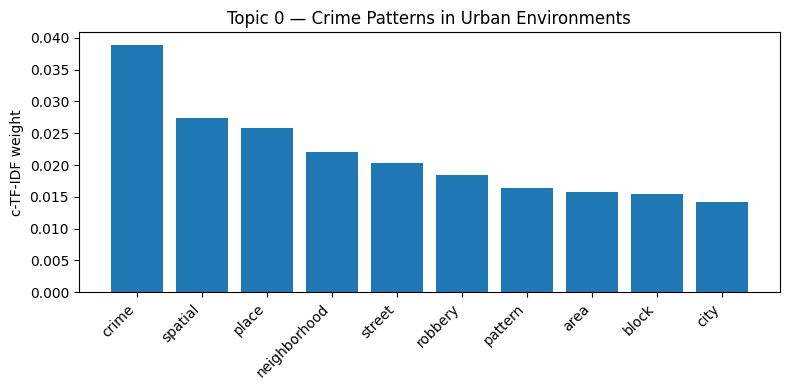

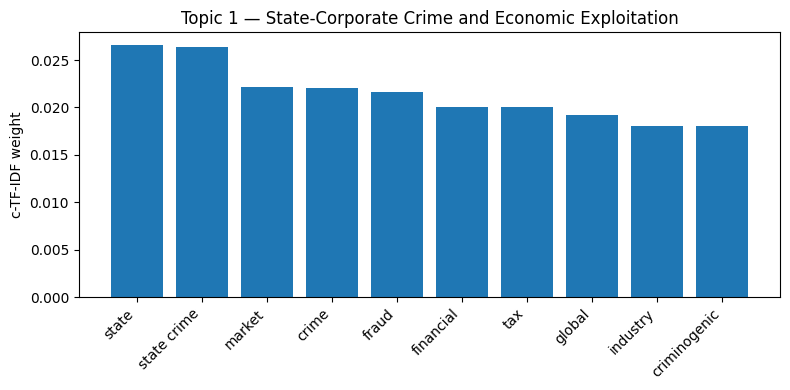

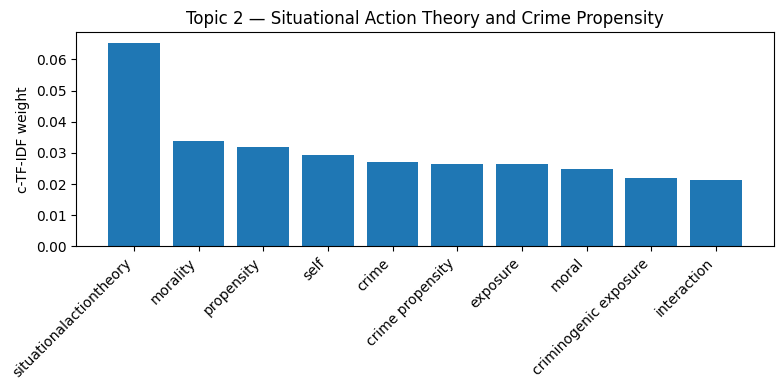

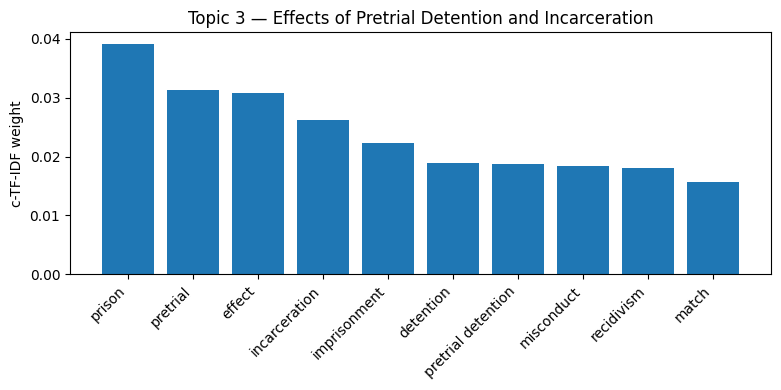

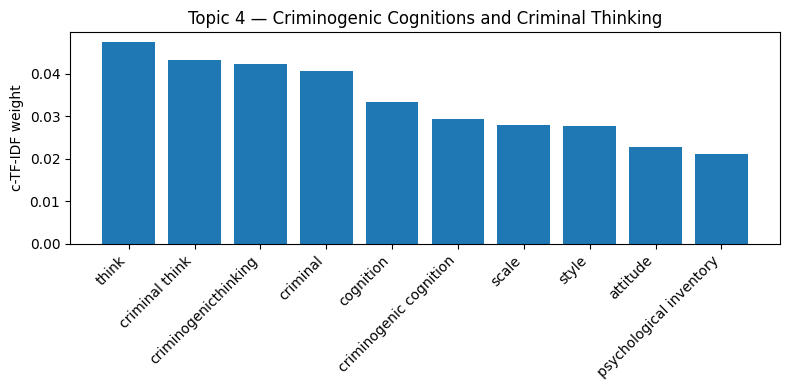

In [ ]:
import matplotlib.pyplot as plt

def plot_top_terms(model: BERTopic, topic_id: int, top_n: int = 10):
    # get top terms from BERTopic
    terms = model.get_topic(topic_id)[:top_n]
    if not terms:
        print(f"No terms for topic {topic_id}")
        return

    words = [w for w, _ in terms]
    weights = [float(wt) for _, wt in terms]

    # default title
    title_txt = f"Topic {topic_id}"

    # try to show AI label if we have it
    if "labels_df" in globals():
        # in our latest flow the column name is ai_label
        m = labels_df.set_index("topic_id")["ai_label"].to_dict()
        if topic_id in m and isinstance(m[topic_id], str) and m[topic_id]:
            title_txt = f"{title_txt} — {m[topic_id]}"

    plt.figure(figsize=(8, 4))
    plt.bar(range(len(words)), weights)
    plt.xticks(range(len(words)), words, rotation=45, ha="right")
    plt.title(title_txt)
    plt.ylabel("c-TF-IDF weight")
    plt.tight_layout()
    plt.show()


# ---------------------------------------------------------------
# pick topics to plot
# ---------------------------------------------------------------

# prefer AI-labelled topics
if "labels_df" in globals() and not labels_df.empty:
    topic_list = labels_df["topic_id"].tolist()[:5]
else:
    # fallback: get from the model
    info = topic_model.get_topic_info()
    topic_list = [int(t) for t in info.Topic.tolist() if t != -1][:5]

# plot
for tid in topic_list:
    plot_top_terms(topic_model, int(tid), top_n=10)


## 11) Topic Similarity Heatmap + Correlation Table

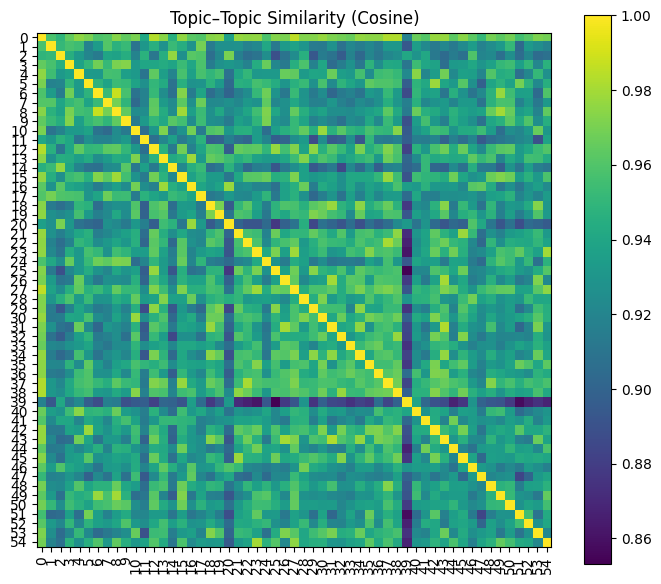

In [ ]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

# 1️⃣ Get active model and topics
active_model = topic_model
info = active_model.get_topic_info()
topic_ids_sorted = sorted([int(tid) for tid in info.Topic.tolist() if tid != -1])

# 2️⃣ Try to use topic embeddings (preferred)
emb = getattr(active_model, "topic_embeddings_", None)

if emb is not None:
    emb_ordered = np.vstack([emb[tid] for tid in topic_ids_sorted])
    sim = cosine_similarity(emb_ordered)
else:
    # fallback: bag-of-top-words similarity
    top_words = {
        tid: [w for w, _ in active_model.get_topic(tid)[:15]]
        for tid in topic_ids_sorted
    }
    vocab = sorted(list({w for ws in top_words.values() for w in ws}))
    word2idx = {w: i for i, w in enumerate(vocab)}

    mat = np.zeros((len(topic_ids_sorted), len(vocab)), dtype=float)
    for i, tid in enumerate(topic_ids_sorted):
        for w in top_words[tid]:
            mat[i, word2idx[w]] = 1.0

    sim = cosine_similarity(mat)

# 3️⃣ Plot heatmap (topic numbers only)
plt.figure(figsize=(7, 6))
plt.imshow(sim, interpolation="nearest", cmap="viridis")
plt.title("Topic–Topic Similarity (Cosine)")
plt.colorbar()
plt.xticks(range(len(topic_ids_sorted)), topic_ids_sorted, rotation=90)
plt.yticks(range(len(topic_ids_sorted)), topic_ids_sorted)
plt.tight_layout()
plt.show()

# keep similarity matrix for next cell
similarity_matrix = sim


In [ ]:
# 4️⃣ Build similarity / correlation table
corr_df = pd.DataFrame(similarity_matrix, index=topic_ids_sorted, columns=topic_ids_sorted)

print("📈 Topic–Topic Similarity (first 10 topics):")
display(corr_df.head(10))

# 5️⃣ Optional: Topic ID → Label reference
if "labels_df" in globals():
    topic_lookup = labels_df[["topic_id", "ai_label"]].sort_values("topic_id")
    print("\n🧠 Topic ID → AI Label Reference")
    display(topic_lookup.head(15))


📈 Topic–Topic Similarity (first 10 topics):


,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,50
0,1.000000,0.964174,0.943142,0.971339,0.976071,0.975213,0.960424,0.951436,0.980893,0.983042,...,0.968143,0.969481,0.960095,0.923834,0.973680,0.977359,0.958208,0.972651,0.934281,0.977208
1,0.964174,1.000000,0.956722,0.961363,0.943402,0.931868,0.956154,0.945755,0.937651,0.936863,...,0.922015,0.932590,0.929165,0.925742,0.921736,0.927648,0.939195,0.960014,0.940771,0.946100
2,0.943142,0.956722,1.000000,0.932306,0.912550,0.917163,0.932094,0.976557,0.904837,0.910660,...,0.911057,0.916722,0.901971,0.947823,0.905956,0.905175,0.918822,0.923939,0.975462,0.921112
3,0.971339,0.961363,0.932306,1.000000,0.975952,0.933343,0.930166,0.924110,0.953391,0.960451,...,0.929677,0.947859,0.921803,0.903088,0.931613,0.935775,0.967042,0.947824,0.913229,0.941272
4,0.976071,0.943402,0.912550,0.975952,1.000000,0.938333,0.905394,0.915117,0.971239,0.971811,...,0.933041,0.949532,0.918986,0.904055,0.947076,0.948924,0.934878,0.945779,0.901307,0.944306
5,0.975213,0.931868,0.917163,0.933343,0.938333,1.000000,0.946373,0.923703,0.954765,0.955402,...,0.937675,0.938065,0.950118,0.885365,0.973948,0.958779,0.941899,0.939993,0.913323,0.953139
6,0.960424,0.956154,0.932094,0.930166,0.905394,0.946373,1.000000,0.935642,0.924098,0.918464,...,0.925744,0.914947,0.940554,0.899842,0.923397,0.923908,0.944649,0.949264,0.917372,0.944840
7,0.951436,0.945755,0.976557,0.924110,0.915117,0.923703,0.935642,1.000000,0.916016,0.917166,...,0.915747,0.936372,0.905911,0.972257,0.915891,0.924614,0.914931,0.920191,0.976756,0.920445
8,0.980893,0.937651,0.904837,0.953391,0.971239,0.954765,0.924098,0.916016,1.000000,0.964383,...,0.944306,0.962692,0.935722,0.888922,0.959766,0.969593,0.933891,0.952530,0.891521,0.957609
9,0.983042,0.936863,0.910660,0.960451,0.971811,0.955402,0.918464,0.917166,0.964383,1.000000,...,0.958956,0.952800,0.934086,0.889619,0.963671,0.977640,0.929936,0.953396,0.903710,0.960603


## 12) Topic Trends Over Time

### 12.1) Build the base trend table
Why: everything (active, emerging, declining) needs the same base data: how many docs per topic per year.

In [ ]:
# ---------------------------------------------------------------
# Topic Trends Over Time — build base trend table
# ---------------------------------------------------------------
import pandas as pd

# 1) Detect year column
year_col = None
for cand in ["year", "publication_year", "py", "pub_year", "Year"]:
    if cand in df_topics_all.columns:
        year_col = cand
        break

if year_col:
    print(f"📅 Using year column: '{year_col}'")

    # 2) Clean year data
    df_trends_src = df_topics_all[df_topics_all["topic_id"] != -1].copy()
    df_trends_src[year_col] = pd.to_numeric(df_trends_src[year_col], errors='coerce')
    df_trends_src = df_trends_src.dropna(subset=[year_col])
    df_trends_src[year_col] = df_trends_src[year_col].astype(int)

    # 3) Aggregate: Count per Topic per Year
    trend_df = (
        df_trends_src
        .groupby(["topic_id", year_col])
        .size()
        .reset_index(name="count")
        .sort_values(["topic_id", year_col])
    )

    # 4) Create Pivot for easier lookup: {topic: {year: count}}
    trend_dict = {}
    for pid, grp in trend_df.groupby("topic_id"):
        trend_dict[pid] = dict(zip(grp[year_col], grp["count"]))

    print(f"✅ Trend data prepared for {len(trend_dict)} topics.")
    display(trend_df.head())
else:
    print("⚠️ No suitable 'year' column found. Trend analysis skipped.")
    trend_df = pd.DataFrame()
    trend_dict = {}

📅 Using year column: 'year'
✅ Trend data prepared for 55 topics.


,topic_id,year,count
0,0,2006,2
1,0,2007,1
2,0,2008,1
3,0,2009,4
4,0,2010,1


### 12.2) Compute topic-level metrics
Why: to classify topics, we need features: total volume, first/last year, trend (slope), variability. Slope tells us emerging vs declining.

Decision explanation:

* total_docs → to find Most Active

* slope → to find Emerging (slope > 0) and Declining (slope < 0)

* first_year → to spot Newest topics

* volatility → to spot event-driven topics

In [ ]:
import numpy as np

topic_metrics = []

if not trend_df.empty:
    for tid, counts in trend_dict.items():
        years = sorted(counts.keys())
        vals = [counts[y] for y in years]

        # Basic stats
        total_docs = sum(vals)
        first_year = years[0]
        last_year = years[-1]

        # Slope (growth rate)
        if len(years) > 1:
            slope = np.polyfit(years, vals, 1)[0]
        else:
            slope = 0.0

        # Volatility (std/mean)
        mean_val = np.mean(vals)
        volatility = (np.std(vals) / mean_val) if mean_val > 0 else 0

        topic_metrics.append({
            "topic_id": tid,
            "total_docs": total_docs,
            "first_year": first_year,
            "last_year": last_year,
            "slope": slope,
            "volatility": volatility
        })

    metrics_df = pd.DataFrame(topic_metrics)

    # Merge with AI Labels for readability
    if "labels_df" in globals():
        metrics_df = metrics_df.merge(labels_df[["topic_id", "ai_label"]], on="topic_id", how="left")

    print("✅ Calculated trend metrics (slope, volatility).")
    display(metrics_df.sort_values("slope", ascending=False).head(5))
else:
    print("⚠️ No trend data available.")
    metrics_df = pd.DataFrame()

✅ Calculated trend metrics (slope, volatility).


,topic_id,total_docs,first_year,last_year,slope,volatility,ai_label
0,0,137,2006,2025,0.715038,0.734692,Crime Patterns in Urban Environments
8,8,24,2013,2025,0.305970,0.750000,Cybercrime Offending and Victimization Dynamics
13,13,23,2008,2025,0.232759,0.717062,Illicit Markets on Social Media Platforms
44,44,10,2013,2025,0.210526,0.894427,Risk Assessment Tool Validation
50,50,8,2016,2025,0.200599,0.500000,Psychopathy and Aggression in Youth and Prisons


## 12.3) Most Active Topics (by total documents)
Why: this is the most common view in bibliometric papers — “what are the dominant themes?”

This gives you the topic IDs to plot.

In [ ]:
TOP_N = 5  # change if needed

# Select top topics by total document volume
most_active = (
    topic_metrics_df
    .sort_values("total_docs", ascending=False)
    .head(TOP_N)
    .reset_index(drop=True)
)

print(f"Top {TOP_N} Most Active Topics")
display(most_active[["topic_id", "total_docs", "slope", "first_year", "last_year", "volatility"]])



NameError: name 'topic_metrics_df' is not defined

## 12.4) Emerging / Fast-Growing Topics
Why: sometimes a topic is small overall but exploding recently. We detect those by slope and recency.

Decision:

* we require recent presence so we don’t accidentally pick an old topic that just had a fluke increase early on

* we sort by slope because we care about rate of growth, not just volume

In [ ]:
# ---------------------------------------------------------------
# Emerging / Fast-Growing Topics
# ---------------------------------------------------------------
# Uses:
# - topic_metrics_df  (slope, last_year, total_docs)
# - trend (dict)      (for plotting later)
# ---------------------------------------------------------------

# latest year in your corpus
max_year = trend_df["year"].max()

EMERGING_TOP_N = 5  # change if needed

emerging = (
    topic_metrics_df
    .query("slope > 0")                    # growing
    .query("last_year >= @max_year - 2")   # active in the last 2 years
    .sort_values("slope", ascending=False)
    .head(EMERGING_TOP_N)
    .reset_index(drop=True)
)

print(f"🚀 Emerging / Fast-Growing Topics (top {EMERGING_TOP_N})")
display(emerging[["topic_id", "total_docs", "slope", "first_year", "last_year", "volatility"]])



🚀 Emerging / Fast-Growing Topics (top 5)


,topic_id,total_docs,slope,first_year,last_year,volatility
0,0,196,0.709028,1995,2025,0.786972
1,21,20,0.319832,2015,2025,0.758288
2,17,21,0.180113,2008,2025,0.638877
3,3,41,0.158707,2004,2025,0.617512
4,12,24,0.148315,2009,2025,0.623610


### 12.5) Declining Topics
Why: nice for discussion sections — “earlier work focused on X but is now declining.”

In [ ]:
# ---------------------------------------------------------------
# Declining Topics
# ---------------------------------------------------------------
# Uses:
# - topic_metrics_df  (slope, first_year, total_docs)
# - trend (dict)      (for plotting later)
# ---------------------------------------------------------------

# latest year from your trend_df
max_year = trend_df["year"].max()

DECLINING_TOP_N = 5  # change if needed

declining = (
    topic_metrics_df
    .query("slope < 0")                    # shrinking
    .query("first_year <= @max_year - 3")  # existed for a while
    .sort_values("slope", ascending=True)  # more negative = steeper decline
    .head(DECLINING_TOP_N)
    .reset_index(drop=True)
)

print(f"📉 Declining Topics (top {DECLINING_TOP_N})")
display(declining[["topic_id", "total_docs", "slope", "first_year", "last_year", "volatility"]])



📉 Declining Topics (top 5)


,topic_id,total_docs,slope,first_year,last_year,volatility
0,41,10,-1.224490e-02,2003,2025,0.282843
1,47,8,-9.146341e-03,2011,2025,0.306186
2,19,20,-6.993007e-03,2006,2025,0.565685
3,26,17,-1.921599e-03,2003,2025,0.348005
4,44,9,-4.859522e-17,2008,2025,0.000000


### 12.6) Plot any category
Why: we don’t want to rewrite the plotting code every time. Let’s make a tiny function that accepts a list of topic IDs and uses your existing trend dict.

In [ ]:
# --- after you created most_active, emerging, declining ---

# ---------------------------------------------------------------
# Cross-check: topic IDs used in plots vs AI labels
# (for inspection only – NOT used in visualization)
# ---------------------------------------------------------------
def show_topic_check(title, df_topics, labels_df):
    print(f"\n🔎 {title}")
    tmp = df_topics[["topic_id"]].merge(
        labels_df[["topic_id", "ai_label"]],
        on="topic_id",
        how="left"
    )
    display(tmp)

# only run if we actually have AI labels
if "labels_df" in globals():
    show_topic_check("Most Active Topics", most_active, labels_df)
    show_topic_check("Emerging / Fast-Growing Topics", emerging, labels_df)
    show_topic_check("Declining Topics", declining, labels_df)
else:
    print("ℹ️ labels_df not found – run AI labelling section first.")


ℹ️ labels_df not found – run AI labelling section first.


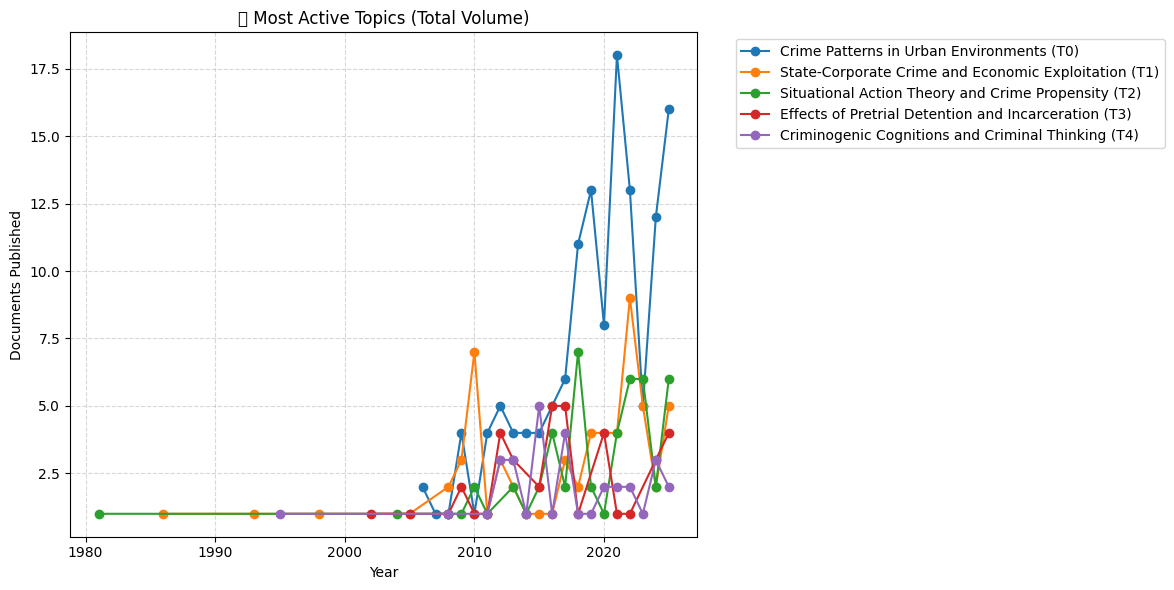

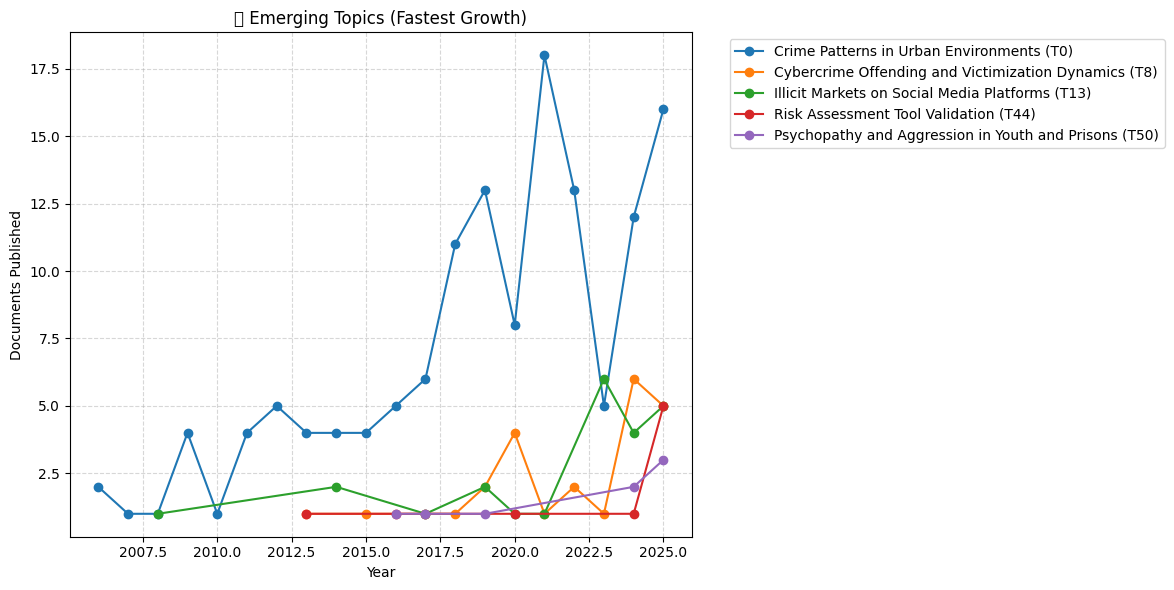

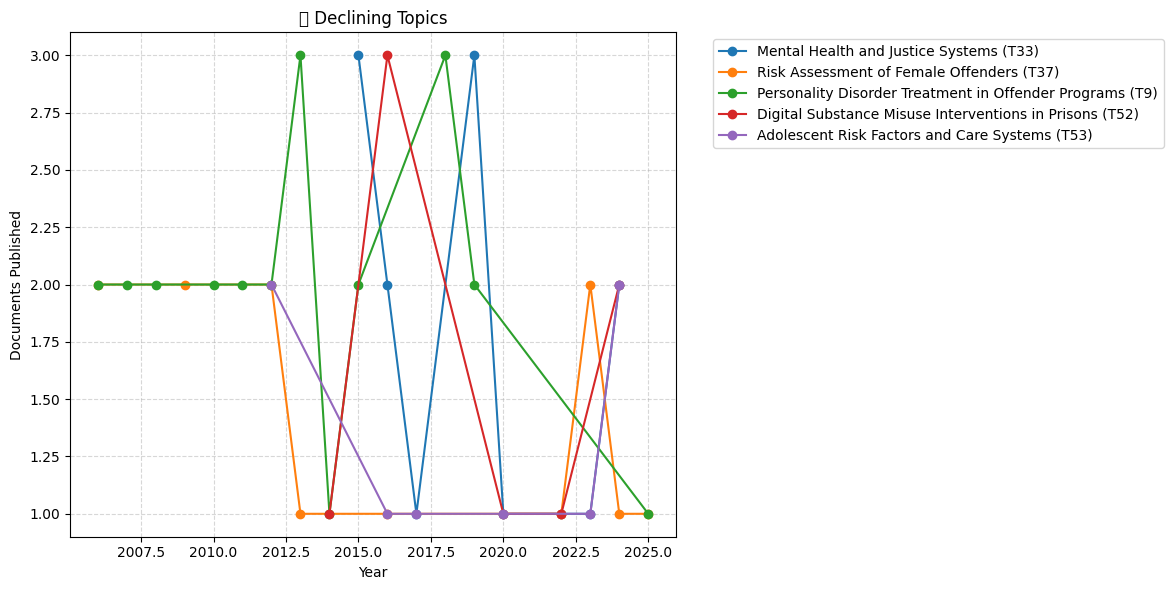

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_topic_trends(metrics_subset, title="Topic Trends"):
    if metrics_subset.empty:
        print("No topics to plot.")
        return

    plt.figure(figsize=(12, 6))

    # Plot each topic in the subset
    for _, row in metrics_subset.iterrows():
        tid = row["topic_id"]
        label = row.get("ai_label", f"Topic {tid}")

        # Get data
        data = trend_dict.get(tid, {})
        if not data: continue

        x = sorted(data.keys())
        y = [data[yr] for yr in x]

        # Plot line + markers
        plt.plot(x, y, marker='o', label=f"{label} (T{tid})")

    plt.title(title)
    plt.xlabel("Year")
    plt.ylabel("Documents Published")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

if not metrics_df.empty:
    # 1. Top Active (Volume)
    top_active = metrics_df.sort_values("total_docs", ascending=False).head(5)
    plot_topic_trends(top_active, "🔥 Most Active Topics (Total Volume)")

    # 2. Emerging (High Slope, Recent Activity)
    # Filter: Active in last 3 years, positive slope
    max_yr = trend_df[year_col].max()
    emerging = metrics_df[
        (metrics_df["slope"] > 0) &
        (metrics_df["last_year"] >= max_yr - 2)
    ].sort_values("slope", ascending=False).head(5)

    plot_topic_trends(emerging, "🚀 Emerging Topics (Fastest Growth)")

    # 3. Declining (Negative Slope)
    declining = metrics_df[
        metrics_df["slope"] < 0
    ].sort_values("slope", ascending=True).head(5)

    plot_topic_trends(declining, "📉 Declining Topics")
else:
    print("Metrics DF is empty, cannot plot trends.")